In [1]:
import sys
!{sys.executable} -m pip install squarify

In [2]:
#states under consideration: Illinois, Florida, Oregon, New Hampshire, Colorado, California, New Jersey, Arizona

In [65]:
import scipy.stats
import matplotlib.pyplot as plt
import copy
from sklearn import linear_model

import matplotlib
import matplotlib.patches as mpatches
from scipy import stats
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import seaborn as sns
import json
import statsmodels.api as sm
import squarify

import pandas as pd
import numpy as np
import folium
from folium.features import DivIcon
import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [91]:
#existing data
floridaFrame = pd.read_csv('FloridaResults.csv')
floridaCounties = ["Alachua","Baker","Bay","Bradford","Brevard","Broward","Calhoun","Charlotte","Citrus","Clay","Collier","Columbia","DeSoto","Dixie","Duval","Escambia","Flagler","Franklin","Gadsden","Gilchrist","Glades","Gulf","Hamilton","Hardee","Hendry","Hernando","Highlands","Hillsborough","Holmes","Indian River","Jackson","Jefferson","Lafayette","Lake","Lee","Leon","Levy","Liberty","Madison","Manatee","Marion","Martin","Miami-Dade","Monroe","Nassau","Okaloosa","Okeechobee","Orange","Osceola","Palm Beach","Pasco","Pinellas","Polk","Putnam","Santa Rosa","Sarasota","Seminole","St. Johns","St. Lucie","Sumter","Suwannee","Taylor","Union","Volusia","Wakulla","Walton","Washington"]

In [5]:
#lets compute centroids of counties

In [92]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [93]:
counties = pd.read_json('us-counties.json')
floridacounties = []
floridaPoints = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "12"):
         floridacounties.append(county)
         floridaPoints.append(county["geometry"]["coordinates"][0])
jsonDict = {"type": "FeatureCollection", "features": floridacounties}
with open('fl-counties.json', 'w') as outfile:  
    json.dump(jsonDict, outfile)

In [85]:
def plotSums(df):
    demCountiesSums = []
    repCountiesSums = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
          if (county > 0):
             demList.append(county)
          else:
             repList.append(county) 
        
        demCountiesSums.append(len(demList))
        repCountiesSums.append(len(repList))
    sumDataframe = pd.DataFrame({'year': years, 'demList': demCountiesSums, 'repList': repCountiesSums})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=sumDataframe, color='blue')
    sns.pointplot(x="year", y="repList", data=sumDataframe, color='red')
    ax.set_title("Counties by Party")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of counties")
    ax.set_yticks(list(range(0, 70, 5)))
    
    red_patch = mpatches.Patch(color='red', label='Republican')
    blue_patch = mpatches.Patch(color='blue', label="Democratic")
    ax.legend(handles=[blue_patch, red_patch])
    
    fig = plt.gcf()
    fig.set_size_inches(20, 8)

In [88]:
def plotLeans(df):
    demAverageLean = []
    repAverageLean = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
            if (county > 0):
                demList.append(county)
            else:
                repList.append(county) 
        if (len(demList) != 0):
            demAverageLean.append((sum(demList)*1.0)/len(demList))
        else:
            demAverageLean.append(0.0)
        if (len(repList) != 0):
            repAverageLean.append((sum(repList)*1.0)/len(repList))
        else:
            repAverageLean.append(0.0)
    leanDF = pd.DataFrame({'year': years, 'demList': demAverageLean, 'repList': repAverageLean})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=leanDF, color='blue')
    sns.pointplot(x="year", y="repList", data=leanDF, color='red')
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean")

    yList = [-.4]
    s = -.40
    for a in range(20):
        s += .05
        yList.append(s)
    
    ax.set_yticks(yList)
    ax.legend(["Democratic", "Republican"])
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean value")
    ax.set_title("Partisan Lean (1976-2040)")
    
    red_patch = mpatches.Patch(color='red', label='Republican')
    blue_patch = mpatches.Patch(color='blue', label="Democratic")
    ax.legend(handles=[blue_patch, red_patch])
    
    fig = plt.gcf()
    fig.set_size_inches(20, 8)

In [87]:
def plotPercentages(df):
    demPercentagesSums = []
    repPercentagesSums = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for i in range(len(df)):
            countyPartisanLean = df.get_value(i, 'Partisan Lean ' + str(year))
            if (countyPartisanLean > 0):
               demList.append(df.get_value(i, str(year)+"Total"))
            else:
               repList.append(df.get_value(i, str(year)+"Total")) 
            
        totalSum = sum(demList) + sum(repList)
        demPercentagesSums.append(sum(demList)/totalSum)
        repPercentagesSums.append(sum(repList)/totalSum)
        
    print(demPercentagesSums)
    sumDataframe = pd.DataFrame({'year': years, 'demList': demPercentagesSums, 'repList':  repPercentagesSums})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=sumDataframe, color='blue')
    sns.pointplot(x="year", y="repList", data=sumDataframe, color='red')
    ax.set_title("Counties by Party")
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage living in counties leaning D/R")
    
    yList = [0.0]
    s = 0.0
    for a in range(10):
        s += .1
        yList.append(s)
    ax.set_yticks(yList)
    ax.legend(["Democratic", "Republican"])
    
    red_patch = mpatches.Patch(color='red', label='Republican')
    blue_patch = mpatches.Patch(color='blue', label="Democratic")
    ax.legend(handles=[blue_patch, red_patch])
    
    fig = plt.gcf()
    fig.set_size_inches(20, 8)

In [11]:
def func(x, a, b):
    return a*np.log(x) + b

In [12]:
def extendedMap(df, year, loc, zoom, points):
    foliumMap = folium.Map(location=loc, zoom_start=zoom)
    yearCol = "Partisan Lean " + str(year)
    legendCol = "Partisan Lean " + str(year)
    foliumMap.choropleth(geo_data=geo, data=df,
             columns=['counties', yearCol],
             key_on='feature.properties.name', threshold_scale=[-.10, -.05, 0, .05, .10],
             fill_color='RdBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legendCol)
    a = 0
#     for county in df['counties']:
#         latitude = None
#         longitude = None
#         try:
#            longitude, latitude = centeroidnp(np.array(points[a]))
#            folium.features.Marker(location=[latitude, longitude], icon=DivIcon(icon_size=(20,15),icon_anchor=(0,0), html='<div style="font-size: 8pt">'+ county + '</div>')).add_to(foliumMap)
#            a += 1
#         except (IndexError):
#             print("Index Error")
#             break
    return foliumMap

In [94]:
geo = r'fl-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(floridaFrame), year=slider, loc=fixed((27.7, -81.5)), zoom=fixed(6), points=fixed(floridaPoints))
None

In [95]:
def constructExtendedTreemap(df, year):
    cmap = matplotlib.cm.RdBu
    dfSorted = df.sort_values(str(year)+"Total", ascending=False)
    mini=min(df['Partisan Lean '+str(year)])
    maxi=max(df['Partisan Lean '+str(year)])
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    colors = [cmap(norm(value)) for value in dfSorted['Partisan Lean '+str(year)]]
    
    plt.rc('font', size=22)
    squarify.plot(sizes=dfSorted[str(year)+"Total"], label=dfSorted['counties'], alpha=0.8, color=colors )
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.show()

In [96]:
geo = r'fl-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(floridaFrame), year=slider)
None

In [16]:
def constructBarplot(df, minYear, maxYear, title):
    demTotals = []
    repubTotals = []

    for year in range(minYear, maxYear, 4):
       dTotal = 0.0
       rTotal = 0.0
       if (year <= 2016):
          for i in range(len(df)):
              dTotal += df.get_value(i, str(year)+"D") * df.get_value(i, str(year)+"Total") 
              rTotal += df.get_value(i, str(year)+"R") * df.get_value(i, str(year)+"Total")
       else: #based on partisan lean and national vote being tied
          for i in range(len(df)):
              dPerc = .5 + df.get_value(i, "Partisan Lean " + str(year))
              rPerc = .5 - df.get_value(i, "Partisan Lean " + str(year)) 
              if (dPerc < 0):
                 dPerc = 0.0
              if (dPerc > 1):
                 dPerc = 1.0
              if (rPerc < 0):
                  rPerc = 0.0
              if (rPerc > 1):
                  rPerc = 1.0
                
              dTotal += df.get_value(i, str(year)+"Total") * dPerc
              rTotal += df.get_value(i, str(year)+"Total") * rPerc  
       
       print("Year: " + str(year) + "DemTotal: " + str(dTotal) + "RepTotal: " + str(rTotal))
       demTotals.append(dTotal/(dTotal+rTotal))
       repubTotals.append(rTotal/(dTotal+rTotal))
        
    ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=demTotals)
    fig = plt.gcf()

    demList = []
    s = 0.0
    for a in range(15):
        s += .05
        demList.append(s)
    
    ax.set_yticks(demList)
    fig.set_size_inches(30, 36)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage Lean")
    
#     ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=repubTotals)
#     fig = plt.gcf()

#     repubList = []
#     s = 0.0
#     for a in range(20):
#         s += .05
#         repubList.append(s)
    
#     ax.set_yticks(repubList)
#     fig.set_size_inches(20, 16)

Year: 1976DemTotal: 1659873.45889RepTotal: 1490640.54111
Year: 1980DemTotal: 1509681.25198RepTotal: 2177285.74802
Year: 1984DemTotal: 1448618.80742RepTotal: 2731431.19258
Year: 1988DemTotal: 1666803.69945RepTotal: 2635463.30055
Year: 1992DemTotal: 2586087.66723RepTotal: 2728268.33277
Year: 1996DemTotal: 2814664.93417RepTotal: 2489071.06583
Year: 2000DemTotal: 2980730.03284RepTotal: 2982239.96716
Year: 2004DemTotal: 3612763.54839RepTotal: 3996961.45161
Year: 2008DemTotal: 4324458.07089RepTotal: 4087663.92911
Year: 2012DemTotal: 4282004.10456RepTotal: 4209986.89544
Year: 2016DemTotal: 4688393.61906RepTotal: 4814043.38094
Year: 2020DemTotal: 5159676.59264RepTotal: 5091770.94307
Year: 2024DemTotal: 5616998.00732RepTotal: 5387559.98078
Year: 2028DemTotal: 6085993.84365RepTotal: 5671674.59682
Year: 2032DemTotal: 6567143.69868RepTotal: 5943635.19418
Year: 2036DemTotal: 7060583.88036RepTotal: 6203305.46488
Year: 2040DemTotal: 7565929.67819RepTotal: 6451070.11943


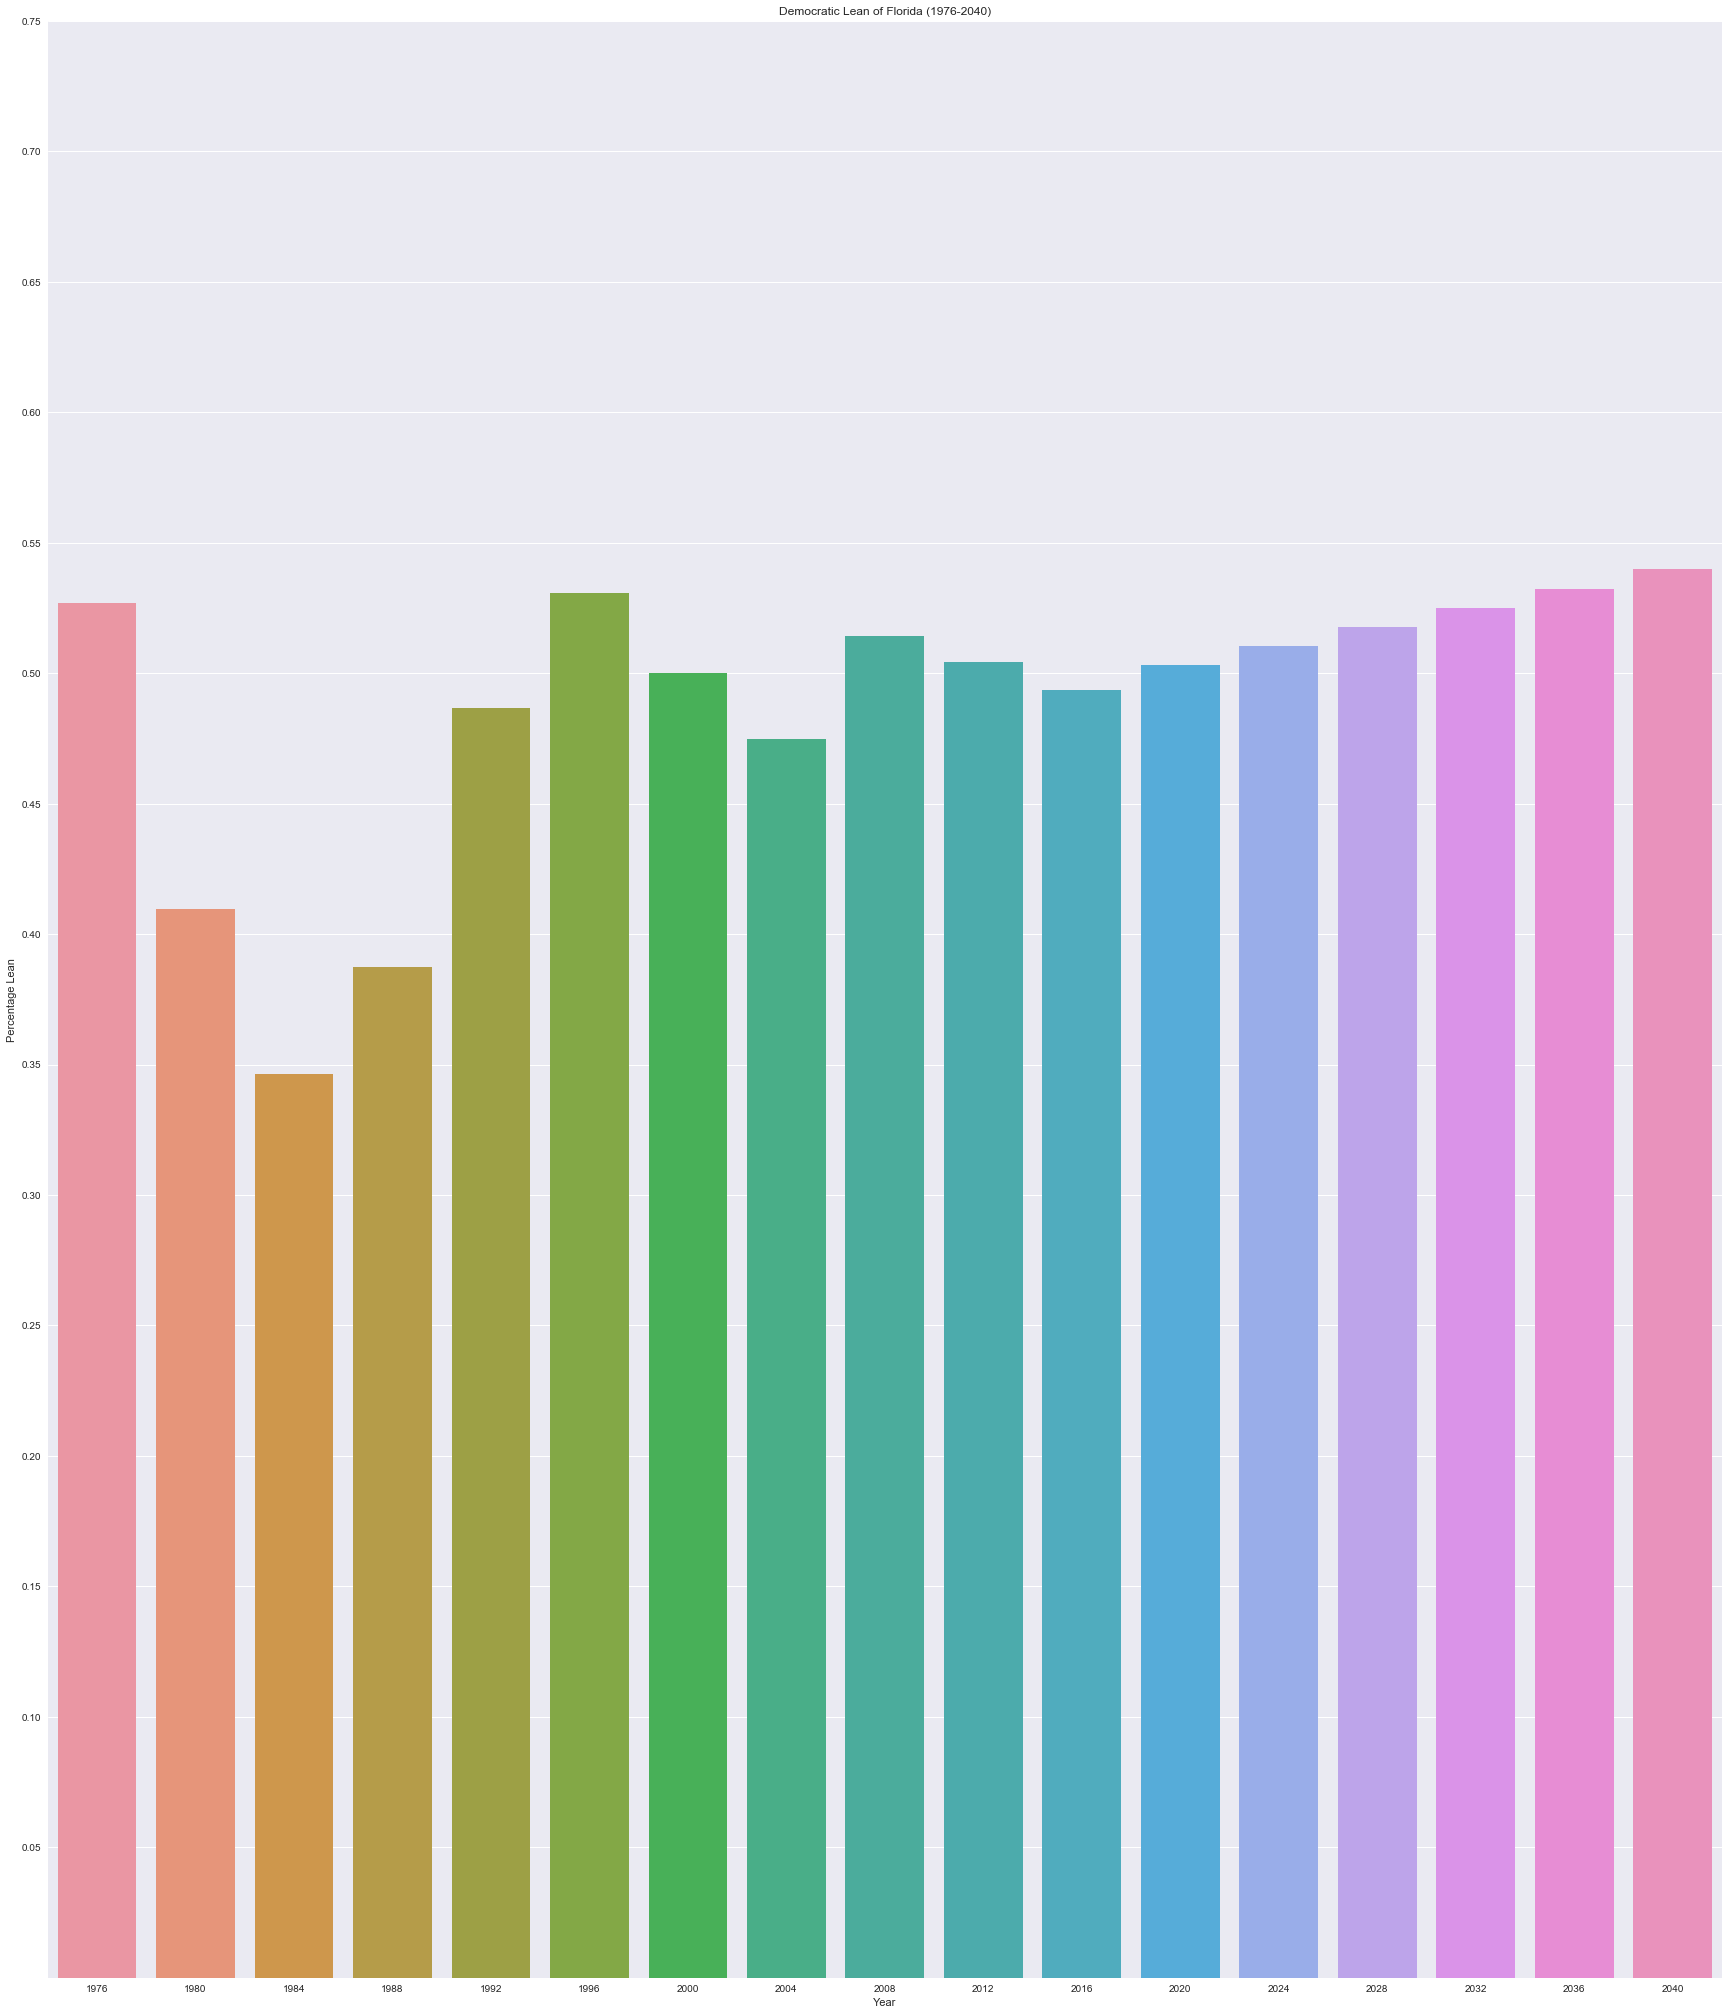

In [97]:
constructBarplot(floridaFrame, 1976, 2044, "Democratic Lean of Florida (1976-2040)")

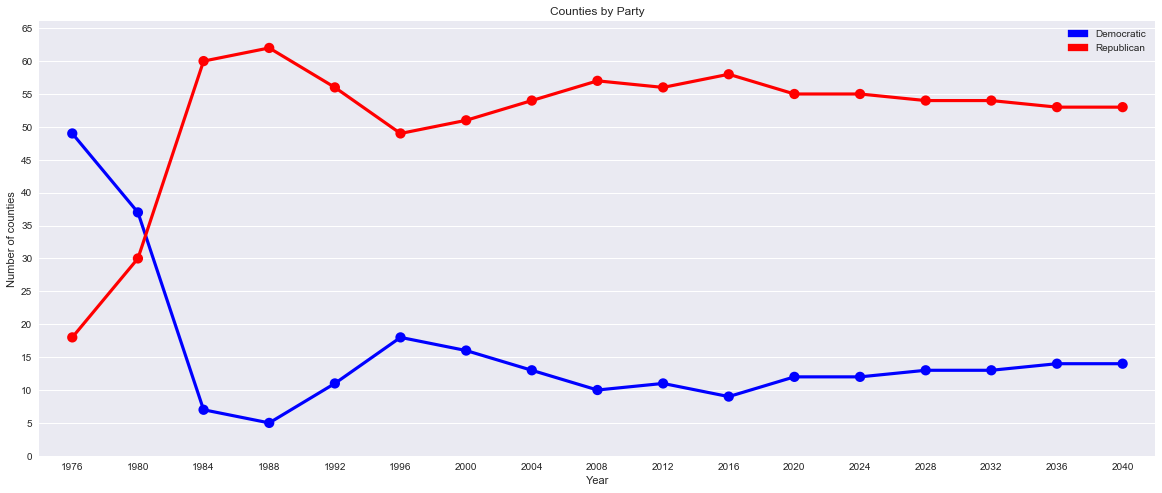

In [99]:
plotSums(floridaFrame)

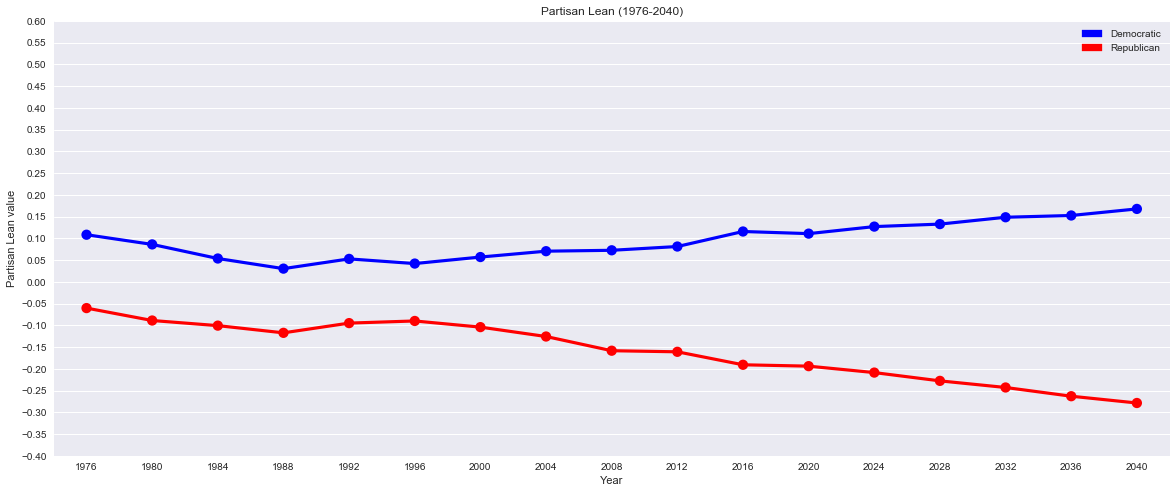

In [100]:
plotLeans(floridaFrame)

[0.62964106809238107, 0.22083897143641373, 0.14312771378332795, 0.13666074188329083, 0.22259799682219256, 0.47606856751542687, 0.52127530408504485, 0.46291173465532592, 0.4325535221671773, 0.49835285977104782, 0.43086273552773885, 0.51759236398569808, 0.51638118357128227, 0.56322744944444558, 0.56231324229330493, 0.58417725828559919, 0.58325263957991047]


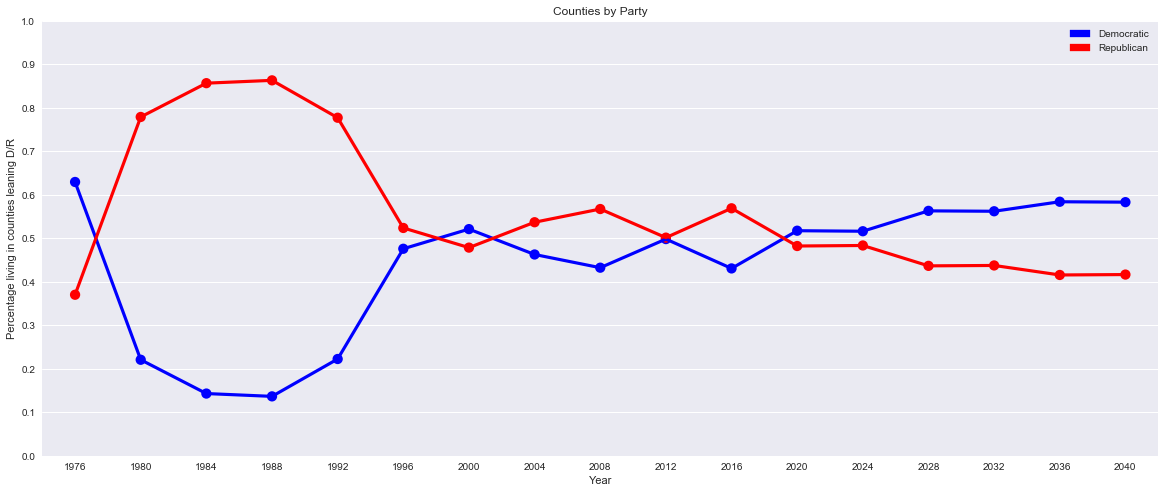

In [101]:
plotPercentages(floridaFrame)

In [21]:
oregonFrame = pd.read_csv("OregonResults.csv")
oregonCounties = ['Baker', 'Benton', 'Clackamas', 'Clatsop', 'Columbia', 'Coos', 'Crook', 'Curry', 'Deschutes', 'Douglas', 'Gilliam', 'Grant', 'Harney', 'Hood River', 'Jackson', 'Jefferson', 'Josephine', 'Klamath', 'Lake', 'Lane', 'Lincoln', 'Linn', 'Malheur', 'Marion', 'Morrow', 'Multnomah', 'Polk', 'Sherman', 'Tillamook', 'Umatilla', 'Union', 'Wallowa', 'Wasco', 'Washington', 'Wheeler', 'Yamhill']

In [22]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "41"):
         points.append(county["geometry"]["coordinates"][0])

In [23]:
geo = r'or-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(oregonFrame), year=slider, points=fixed(points))
None

In [24]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(oregonFrame), year=slider, loc=fixed((44, -121)),zoom=fixed(6), points=fixed(points))
None

Year: 1976DemTotal: 513757.076155RepTotal: 515264.923845
Year: 1980DemTotal: 526264.034819RepTotal: 654350.965181
Year: 1984DemTotal: 538386.811932RepTotal: 688036.188068
Year: 1988DemTotal: 629013.332371RepTotal: 572036.667629
Year: 1992DemTotal: 824462.85231RepTotal: 637927.14769
Year: 1996DemTotal: 753482.700843RepTotal: 623033.299157
Year: 2000DemTotal: 771997.55734RepTotal: 761364.44266
Year: 2004DemTotal: 956671.866649RepTotal: 879379.133351
Year: 2008DemTotal: 1066607.42131RepTotal: 759917.578686
Year: 2012DemTotal: 1006624.77325RepTotal: 781043.226752
Year: 2016DemTotal: 1121074.88938RepTotal: 874059.110624
Year: 2020DemTotal: 1096974.41957RepTotal: 1003810.47329
Year: 2024DemTotal: 1128929.8842RepTotal: 1077065.65151
Year: 2028DemTotal: 1159013.19904RepTotal: 1152192.97953
Year: 2032DemTotal: 1187650.78089RepTotal: 1228766.04054
Year: 2036DemTotal: 1214956.18334RepTotal: 1306671.28094
Year: 2040DemTotal: 1241558.34416RepTotal: 1385279.76298


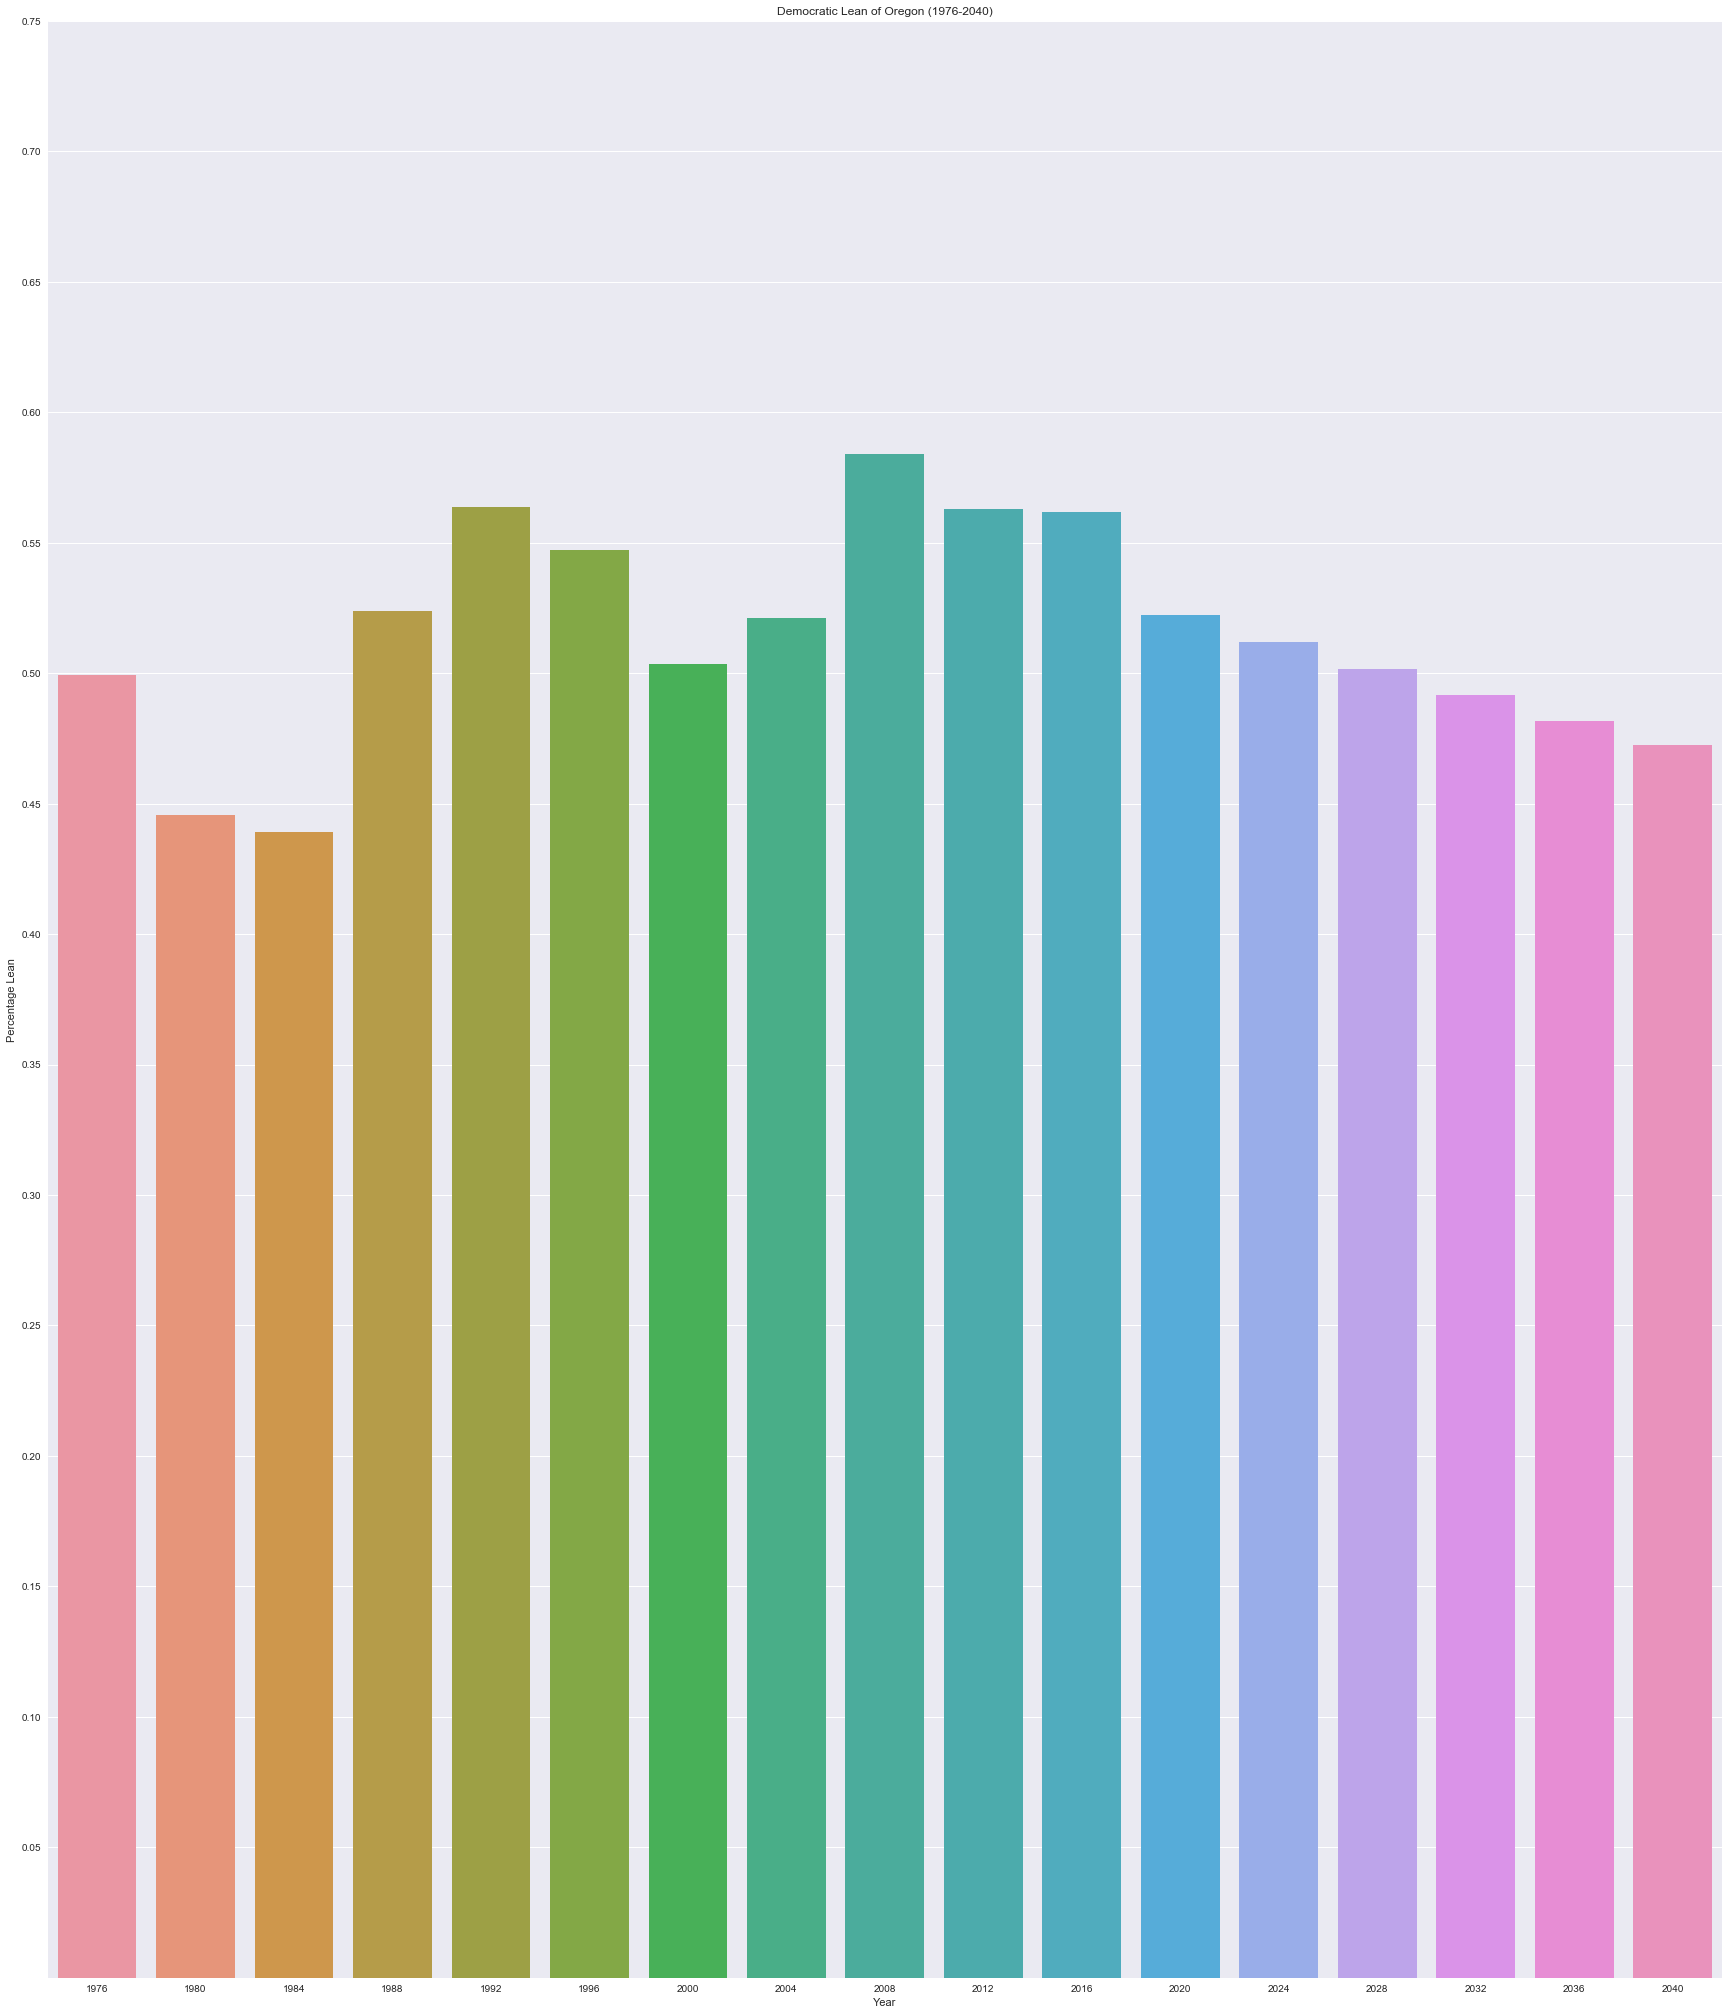

In [25]:
constructBarplot(oregonFrame, 1976, 2044, "Democratic Lean of Oregon (1976-2040)")

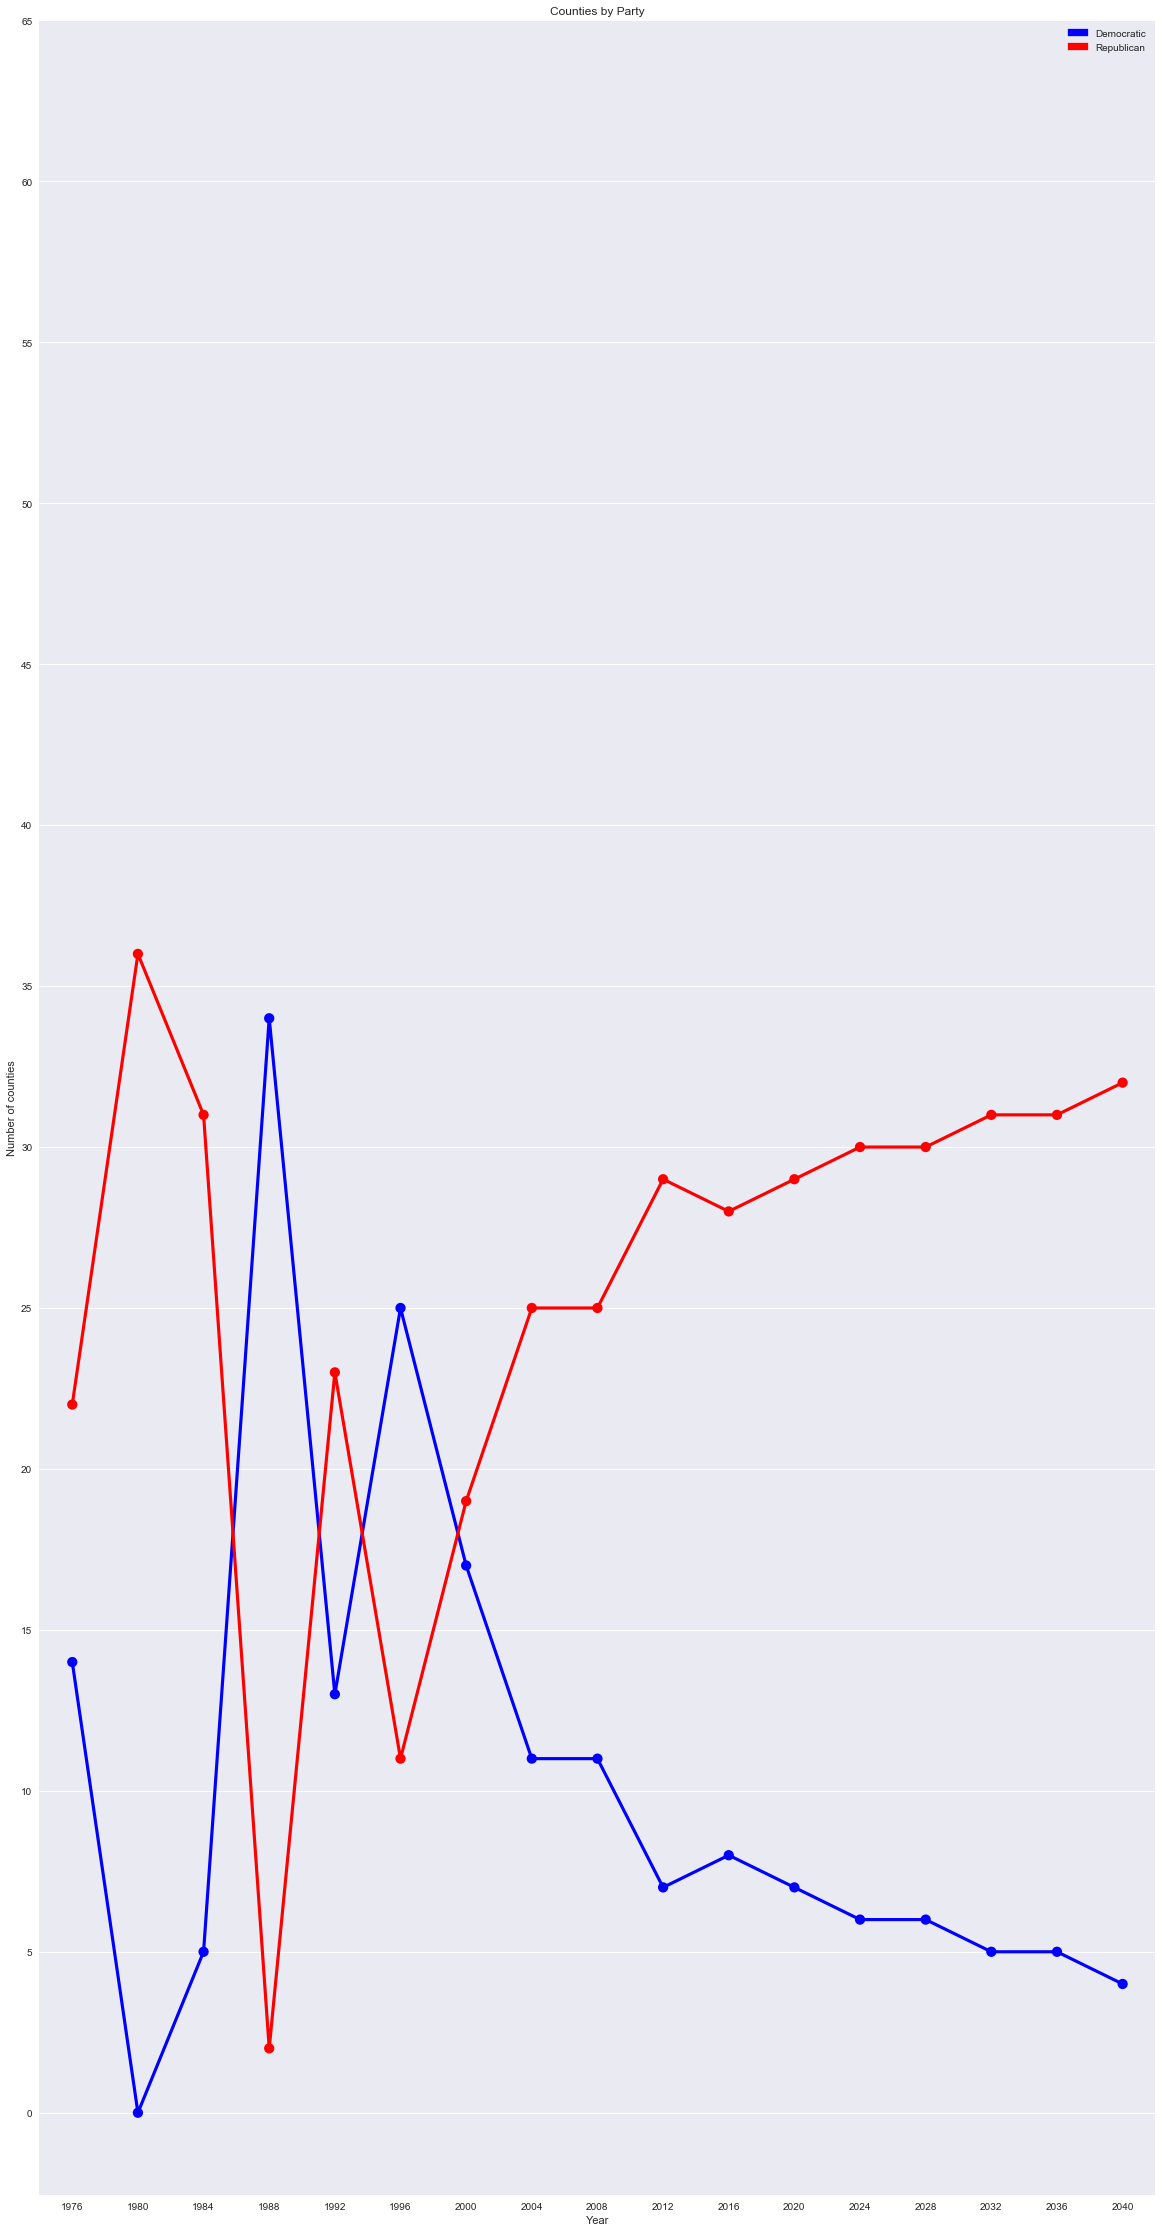

In [26]:
plotSums(oregonFrame)

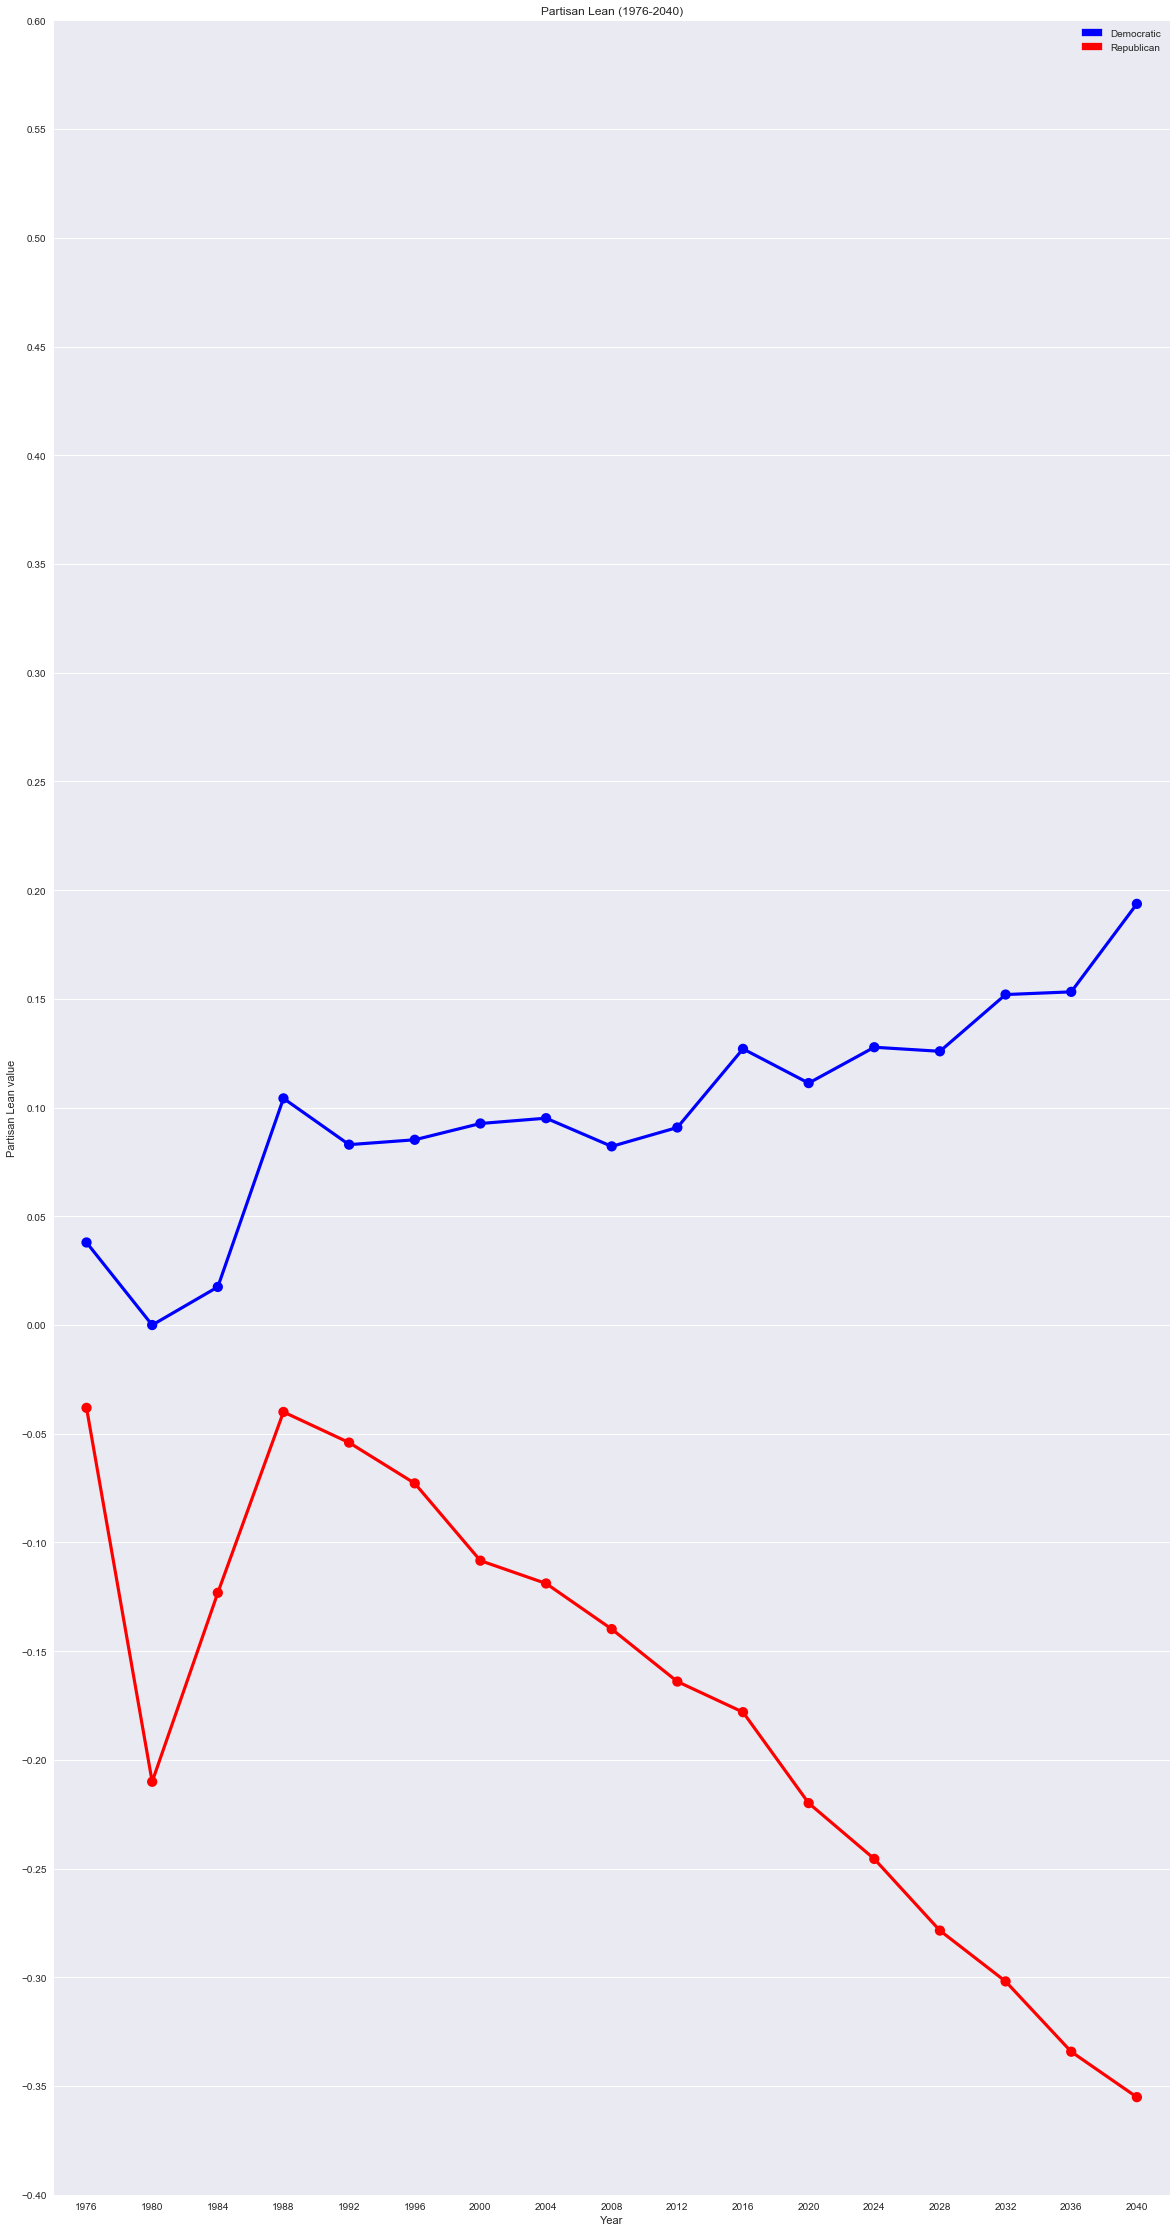

In [27]:
plotLeans(oregonFrame)

In [28]:
illinoisFrame = pd.read_csv('IllinoisResults.csv')
illinoisCounties = ["Adams","Alexander","Bond","Boone","Brown","Bureau","Calhoun","Carroll","Cass","Champaign","Christian","Clark","Clay","Clinton","Coles","Cook","Crawford","Cumberland","De Witt","DeKalb","Douglas","DuPage","Edgar","Edwards","Effingham","Fayette","Ford","Franklin","Fulton","Gallatin","Greene","Grundy","Hamilton","Hancock","Hardin","Henderson","Henry","Iroquois","Jackson","Jasper","Jefferson","Jersey","Jo Daviess","Johnson","Kane","Kankakee","Kendall","Knox","LaSalle","Lake","Lawrence","Lee","Livingston","Logan","Macon","Macoupin","Madison","Marion","Marshall","Mason","Massac","McDonough","McHenry","McLean","Menard","Mercer","Monroe","Montgomery","Morgan","Moultrie","Ogle","Peoria","Perry","Piatt","Pike","Pope","Pulaski","Putnam","Randolph","Richland","Rock Island","Saline","Sangamon","Schuyler","Scott","Shelby","St. Clair","Stark","Stephenson","Tazewell","Union","Vermilion","Wabash","Warren","Washington","Wayne","White","Whiteside","Will","Williamson","Winnebago","Woodford"]

In [29]:
geo = r'il-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(illinoisFrame), year=slider)
None

In [30]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "17"):
         points.append(county["geometry"]["coordinates"][0])

In [31]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(illinoisFrame), year=slider, loc=fixed((40, -90)),zoom=fixed(6), points=fixed(points))
None

Year: 1976DemTotal: 1766474.40081RepTotal: 1952172.59919
Year: 1980DemTotal: 1597958.04619RepTotal: 2151548.95381
Year: 1984DemTotal: 1071109.5496RepTotal: 1747889.4504
Year: 1988DemTotal: 1669396.5442RepTotal: 1889646.4558
Year: 1992DemTotal: 2267105.28771RepTotal: 1783001.71229
Year: 1996DemTotal: 1847314.00757RepTotal: 1464000.99243
Year: 2000DemTotal: 1958458.58615RepTotal: 1783568.41385
Year: 2004DemTotal: 2204830.35762RepTotal: 2069392.64238
Year: 2008DemTotal: 2697362.42578RepTotal: 1832466.57422
Year: 2012DemTotal: 2323858.06358RepTotal: 1927168.93642
Year: 2016DemTotal: 2515689.51349RepTotal: 2077725.48651
Year: 2020DemTotal: 2491757.74399RepTotal: 2213165.9703
Year: 2024DemTotal: 2541994.83159RepTotal: 2310940.09698
Year: 2028DemTotal: 2593196.41245RepTotal: 2407749.73041
Year: 2032DemTotal: 2646101.18458RepTotal: 2502856.17256
Year: 2036DemTotal: 2704329.57465RepTotal: 2592638.99678
Year: 2040DemTotal: 2769251.44273RepTotal: 2675728.34298


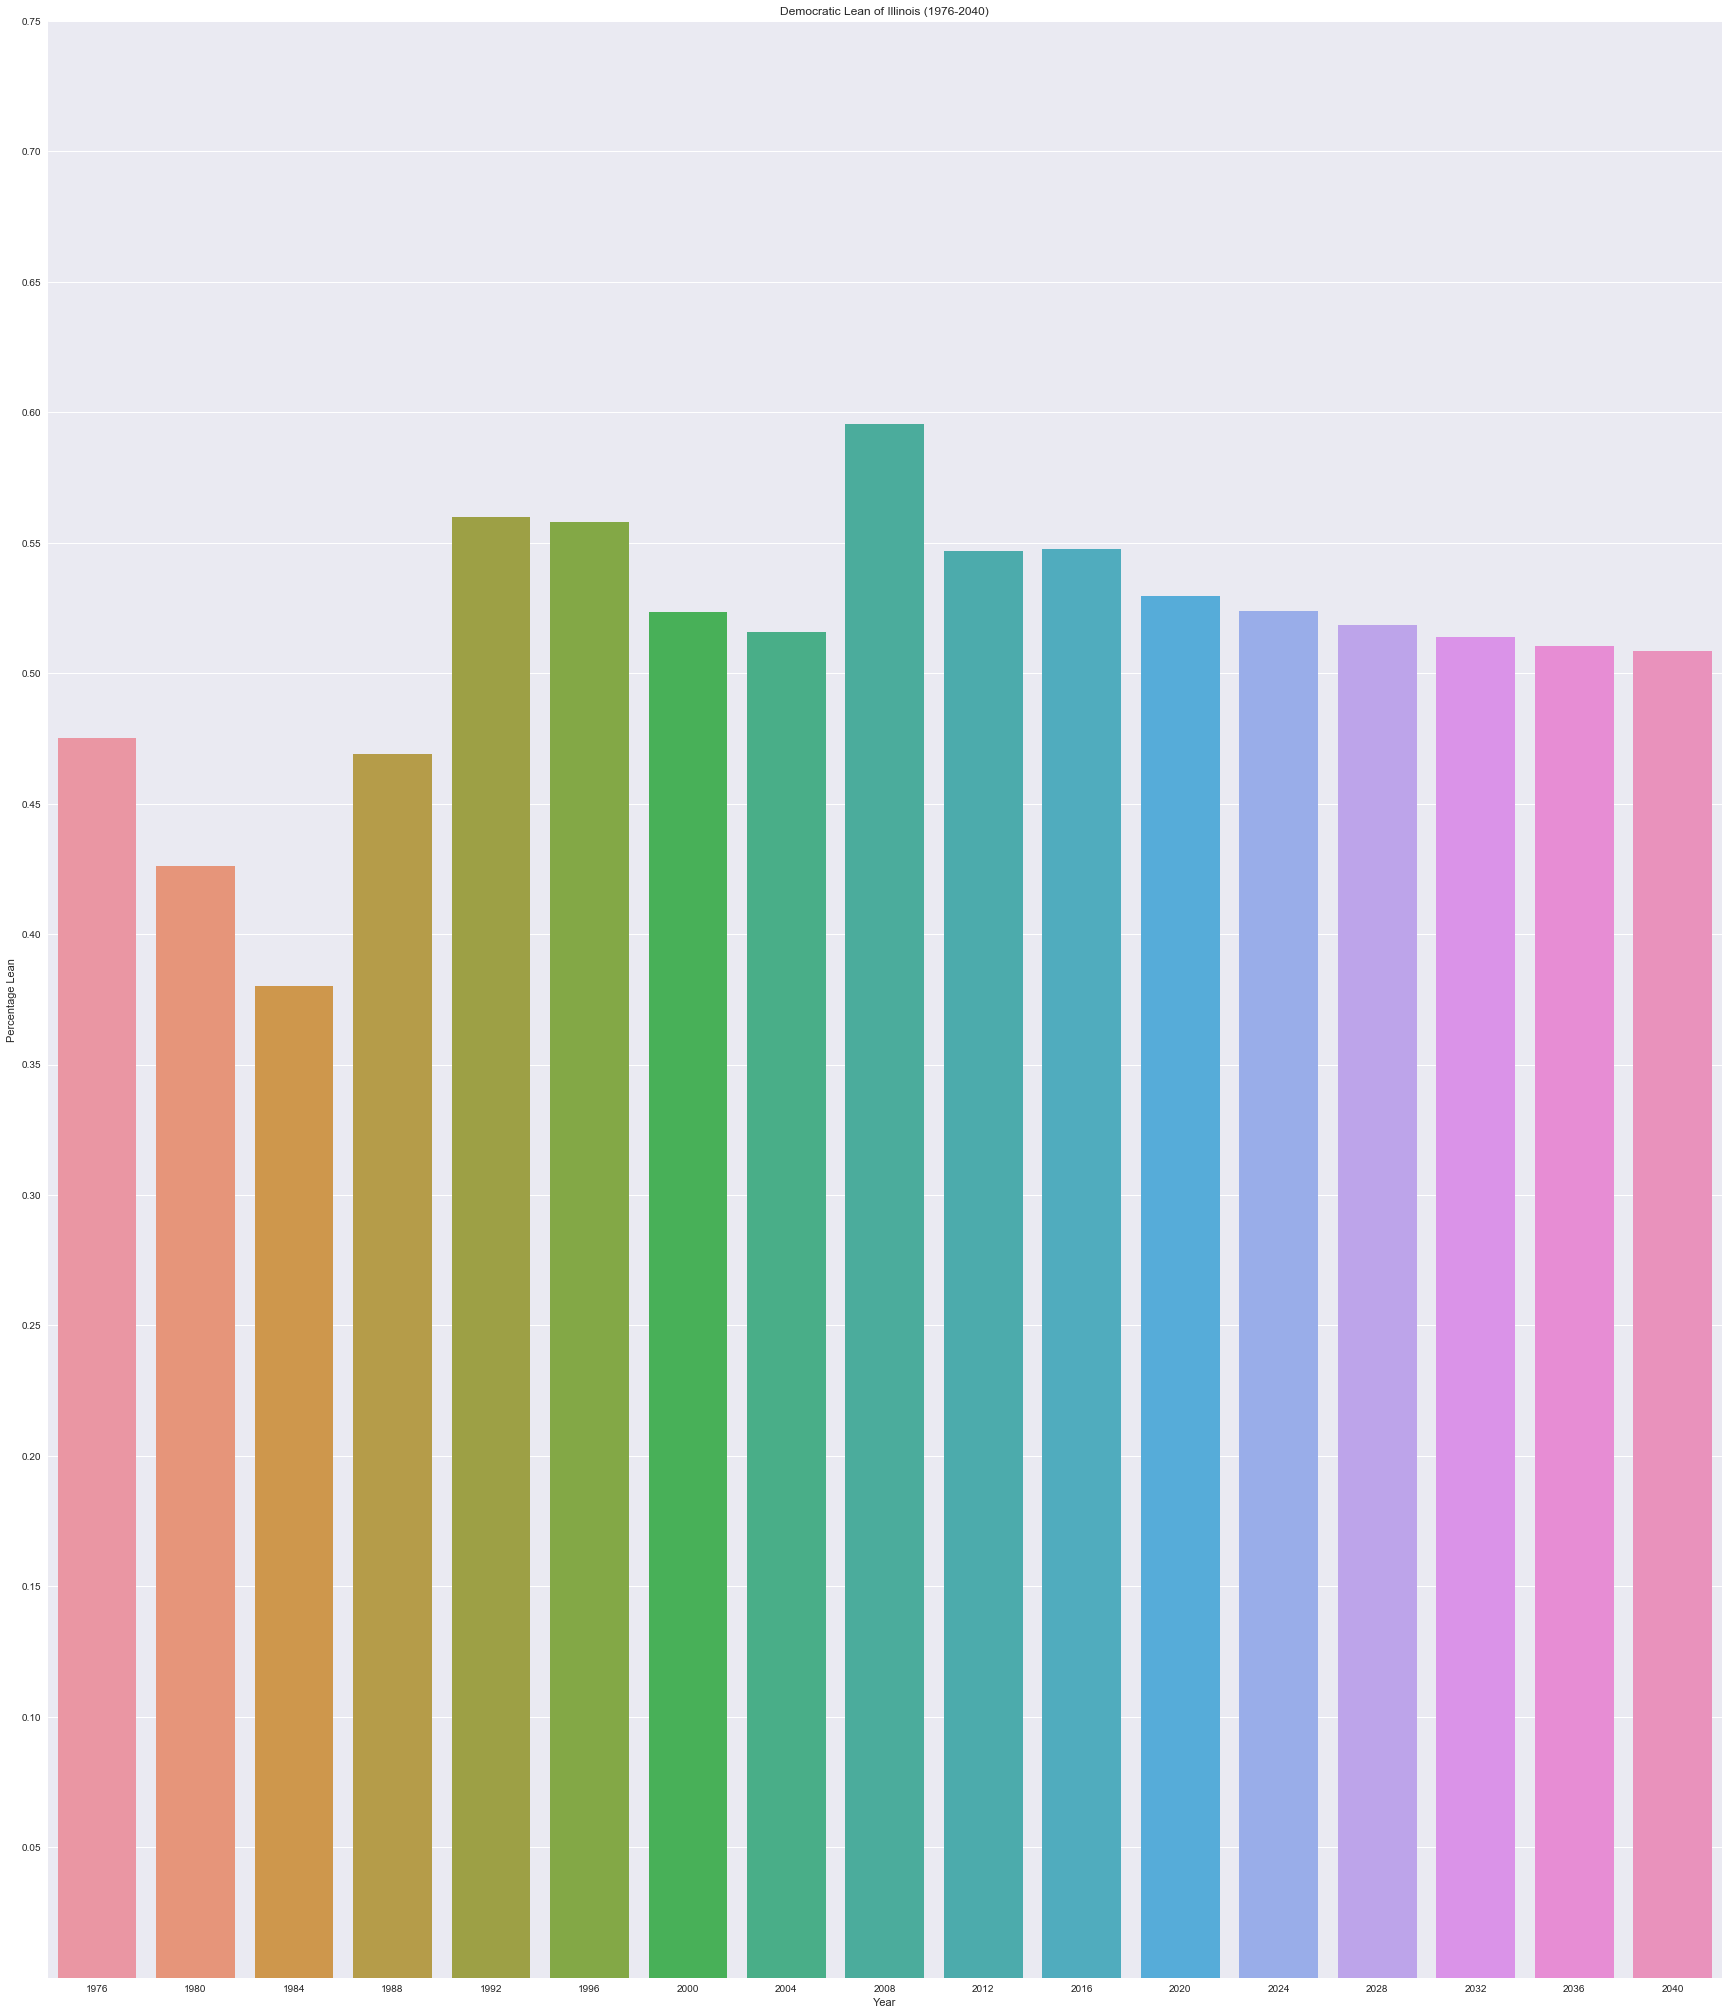

In [32]:
constructBarplot(illinoisFrame, 1976, 2044, "Democratic Lean of Illinois (1976-2040)")

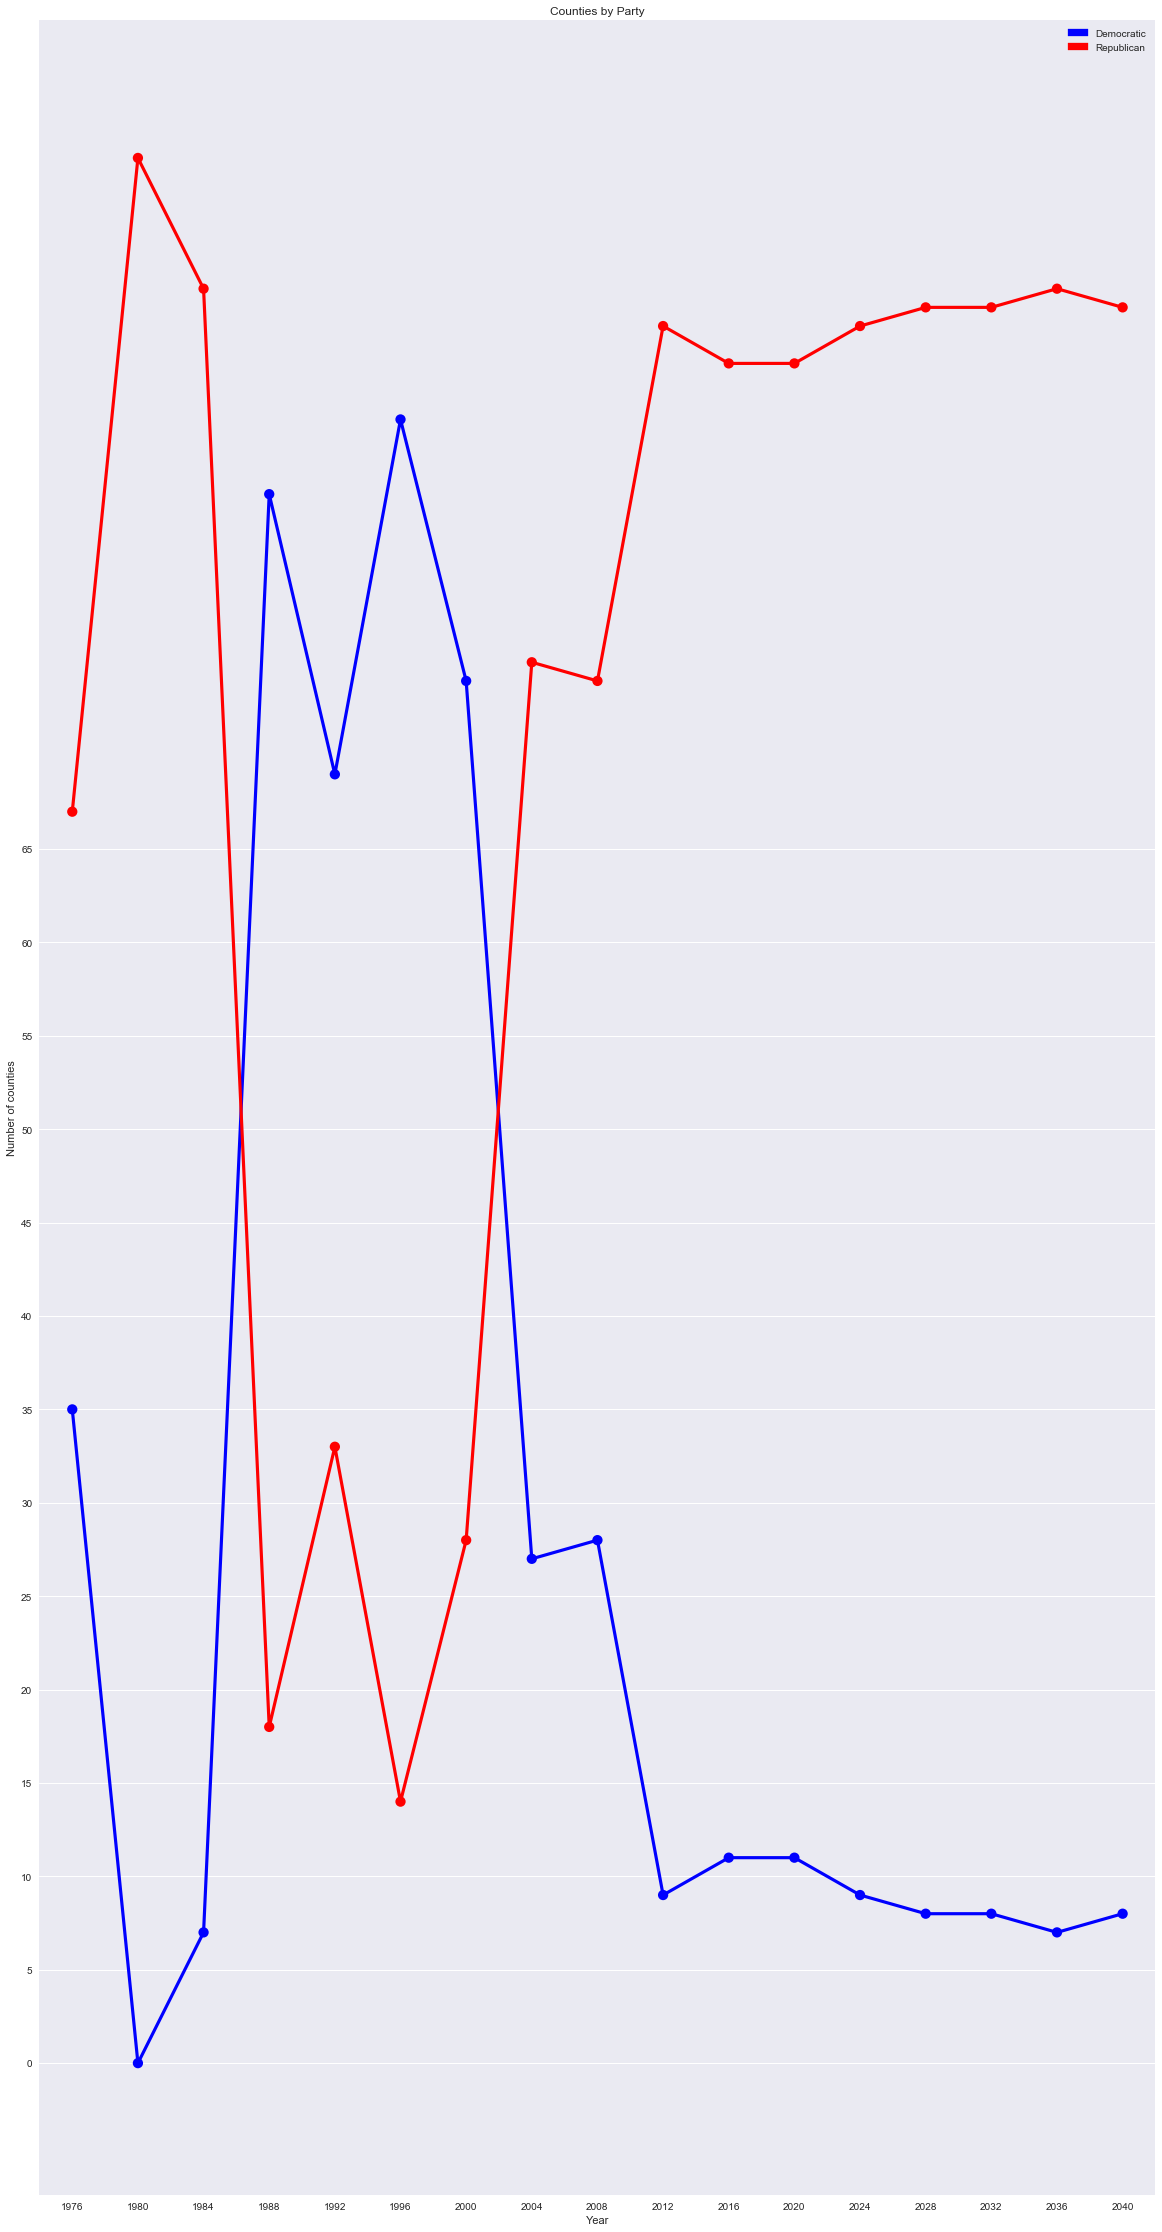

In [33]:
plotSums(illinoisFrame)

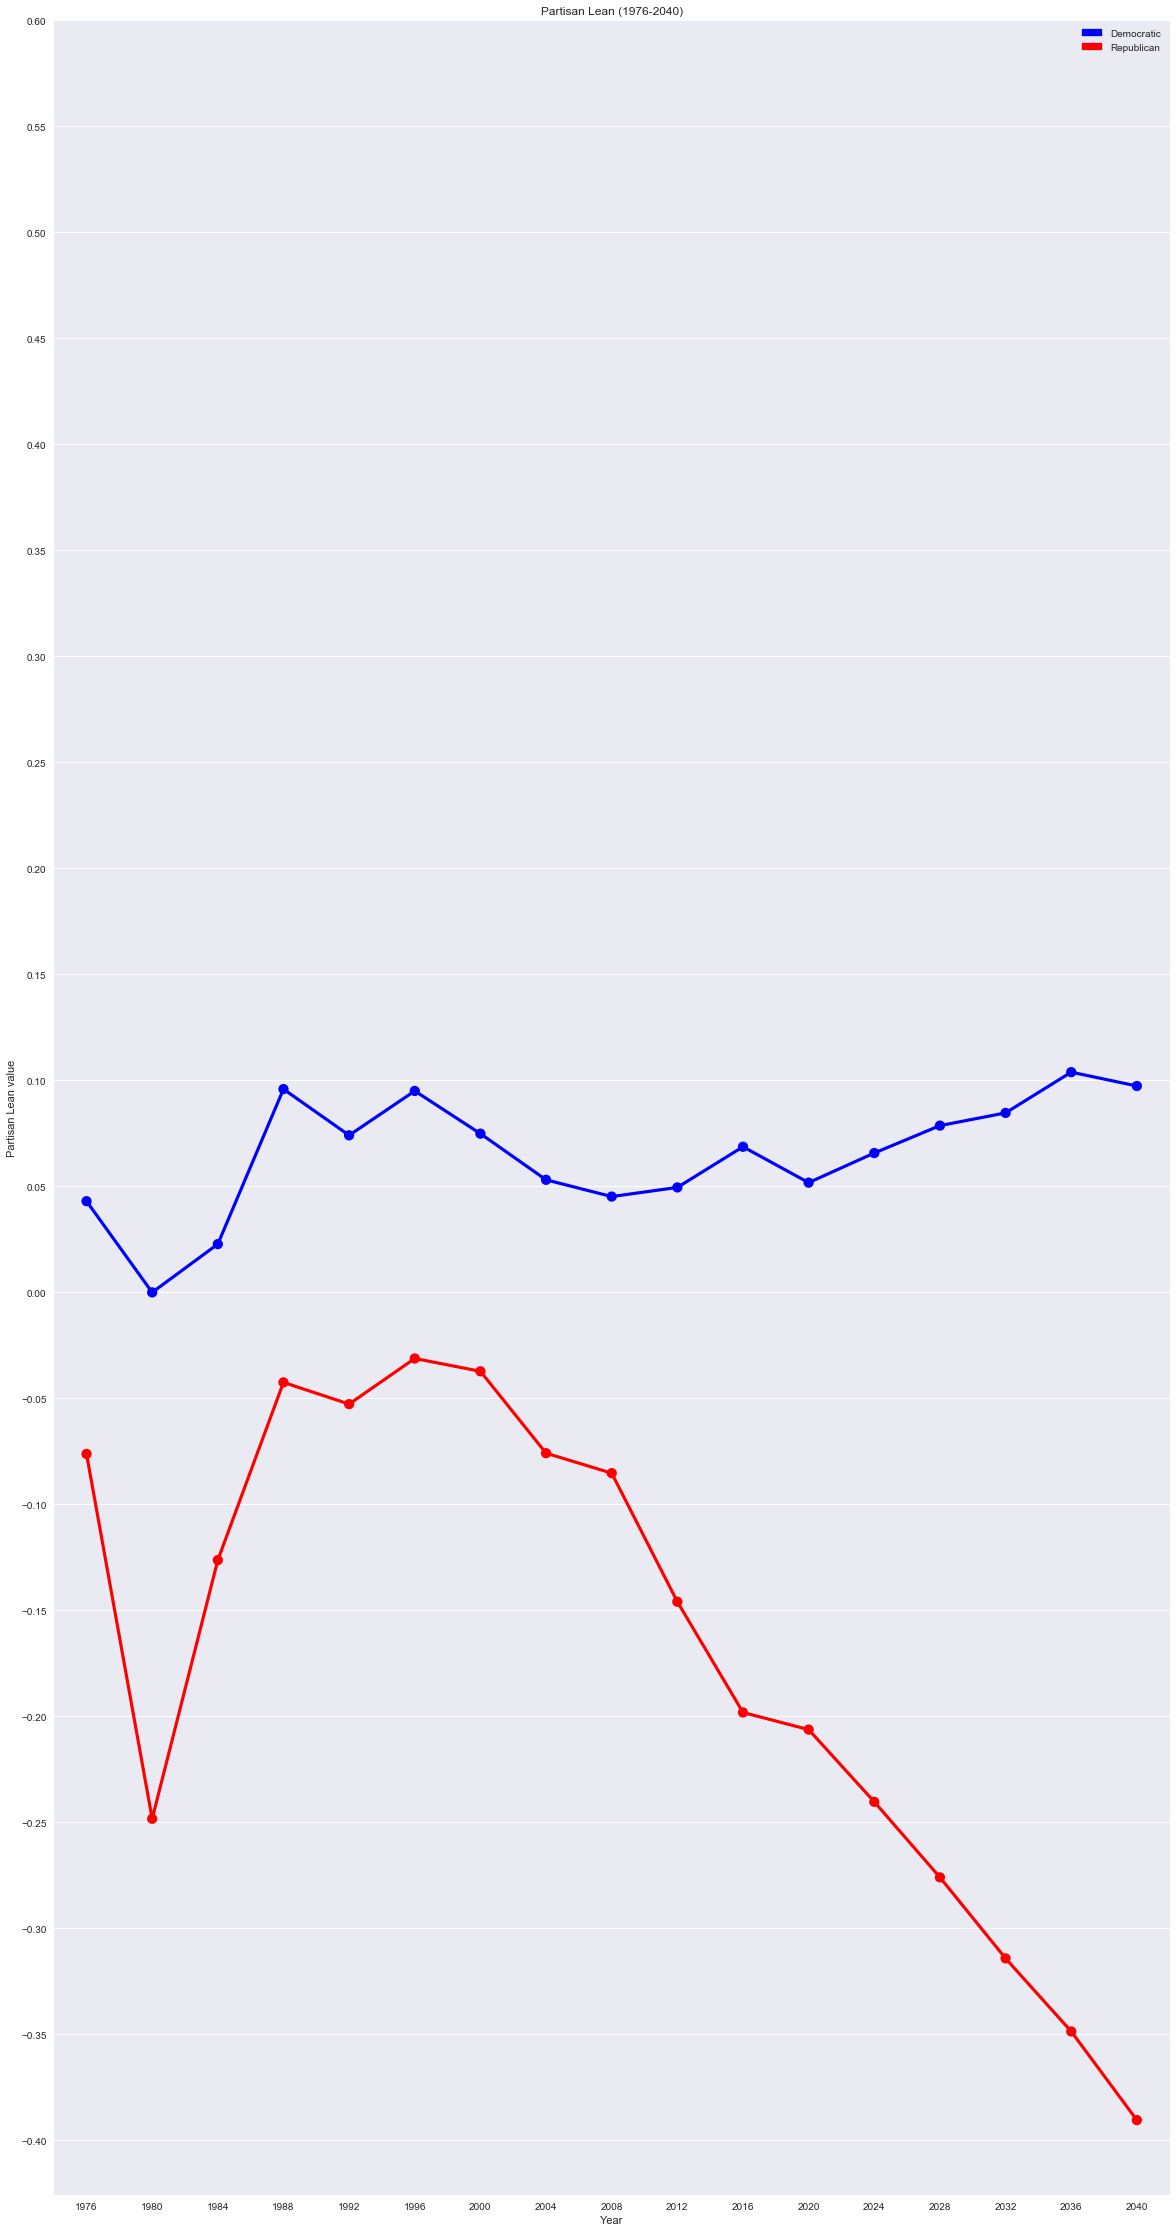

In [34]:
plotLeans(illinoisFrame)

In [35]:
californiaFrame = pd.read_csv("CaliforniaResults.csv")
californiaCounties = ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']

In [36]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0] == "6"):
         points.append(county["geometry"]["coordinates"][0])

In [37]:
geo = r'ca-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(californiaFrame), year=slider, loc=fixed((37.8, -120)),zoom=fixed(5), points=fixed(points))
None

In [38]:
geo = r'ca-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(californiaFrame), year=slider)
None

Year: 1976DemTotal: 2843363.63454RepTotal: 3023415.36546
Year: 1980DemTotal: 3043193.86555RepTotal: 4542212.13445
Year: 1984DemTotal: 3073817.50521RepTotal: 4430945.49479
Year: 1988DemTotal: 3713913.65012RepTotal: 4172968.34988
Year: 1992DemTotal: 5827944.76526RepTotal: 4303636.23474
Year: 1996DemTotal: 5075061.21878RepTotal: 3944020.78122
Year: 2000DemTotal: 5508061.42583RepTotal: 4457558.57417
Year: 2004DemTotal: 5559617.91807RepTotal: 4861980.08193
Year: 2008DemTotal: 7046250.38835RepTotal: 4536304.61165
Year: 2012DemTotal: 6649454.31475RepTotal: 4405585.68525
Year: 2016DemTotal: 7882676.4529RepTotal: 4353409.5471
Year: 2020DemTotal: 7562327.45366RepTotal: 5039698.76063
Year: 2024DemTotal: 7885773.31427RepTotal: 5230635.28097
Year: 2028DemTotal: 8209900.90756RepTotal: 5420890.06863
Year: 2032DemTotal: 8534708.27696RepTotal: 5610465.08018
Year: 2036DemTotal: 8860251.41461RepTotal: 5799304.32348
Year: 2040DemTotal: 9187011.98968RepTotal: 5986926.12936


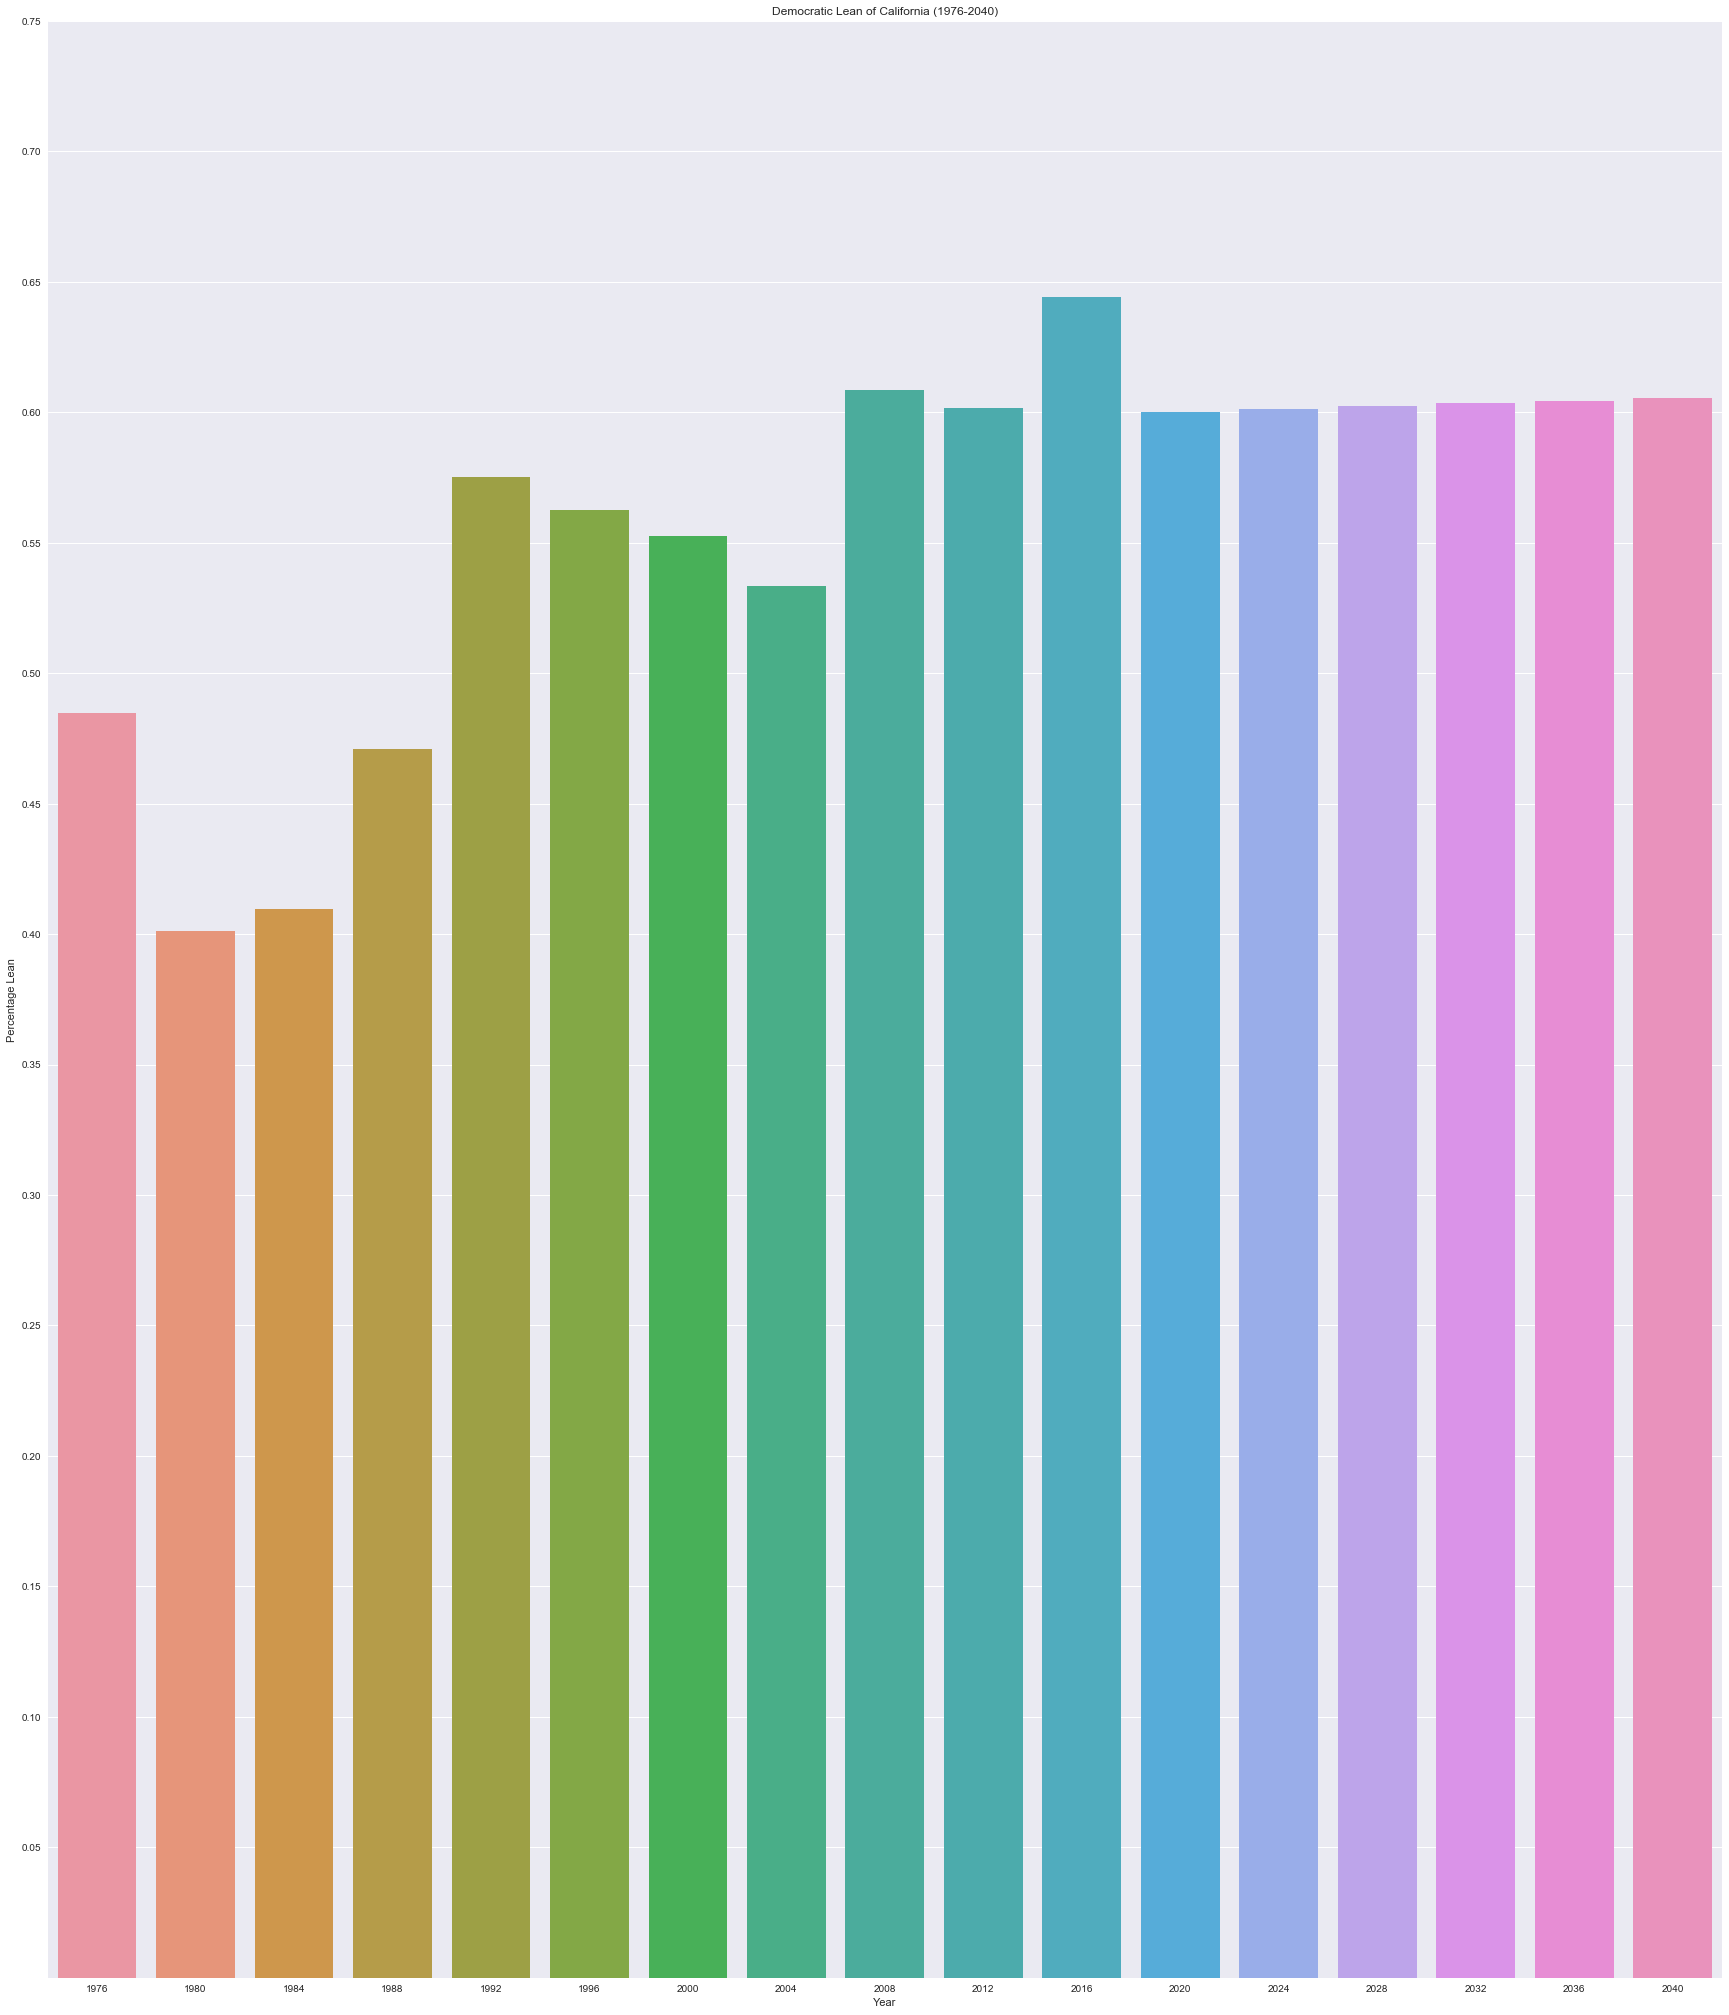

In [39]:
constructBarplot(californiaFrame, 1976, 2044, "Democratic Lean of California (1976-2040)")

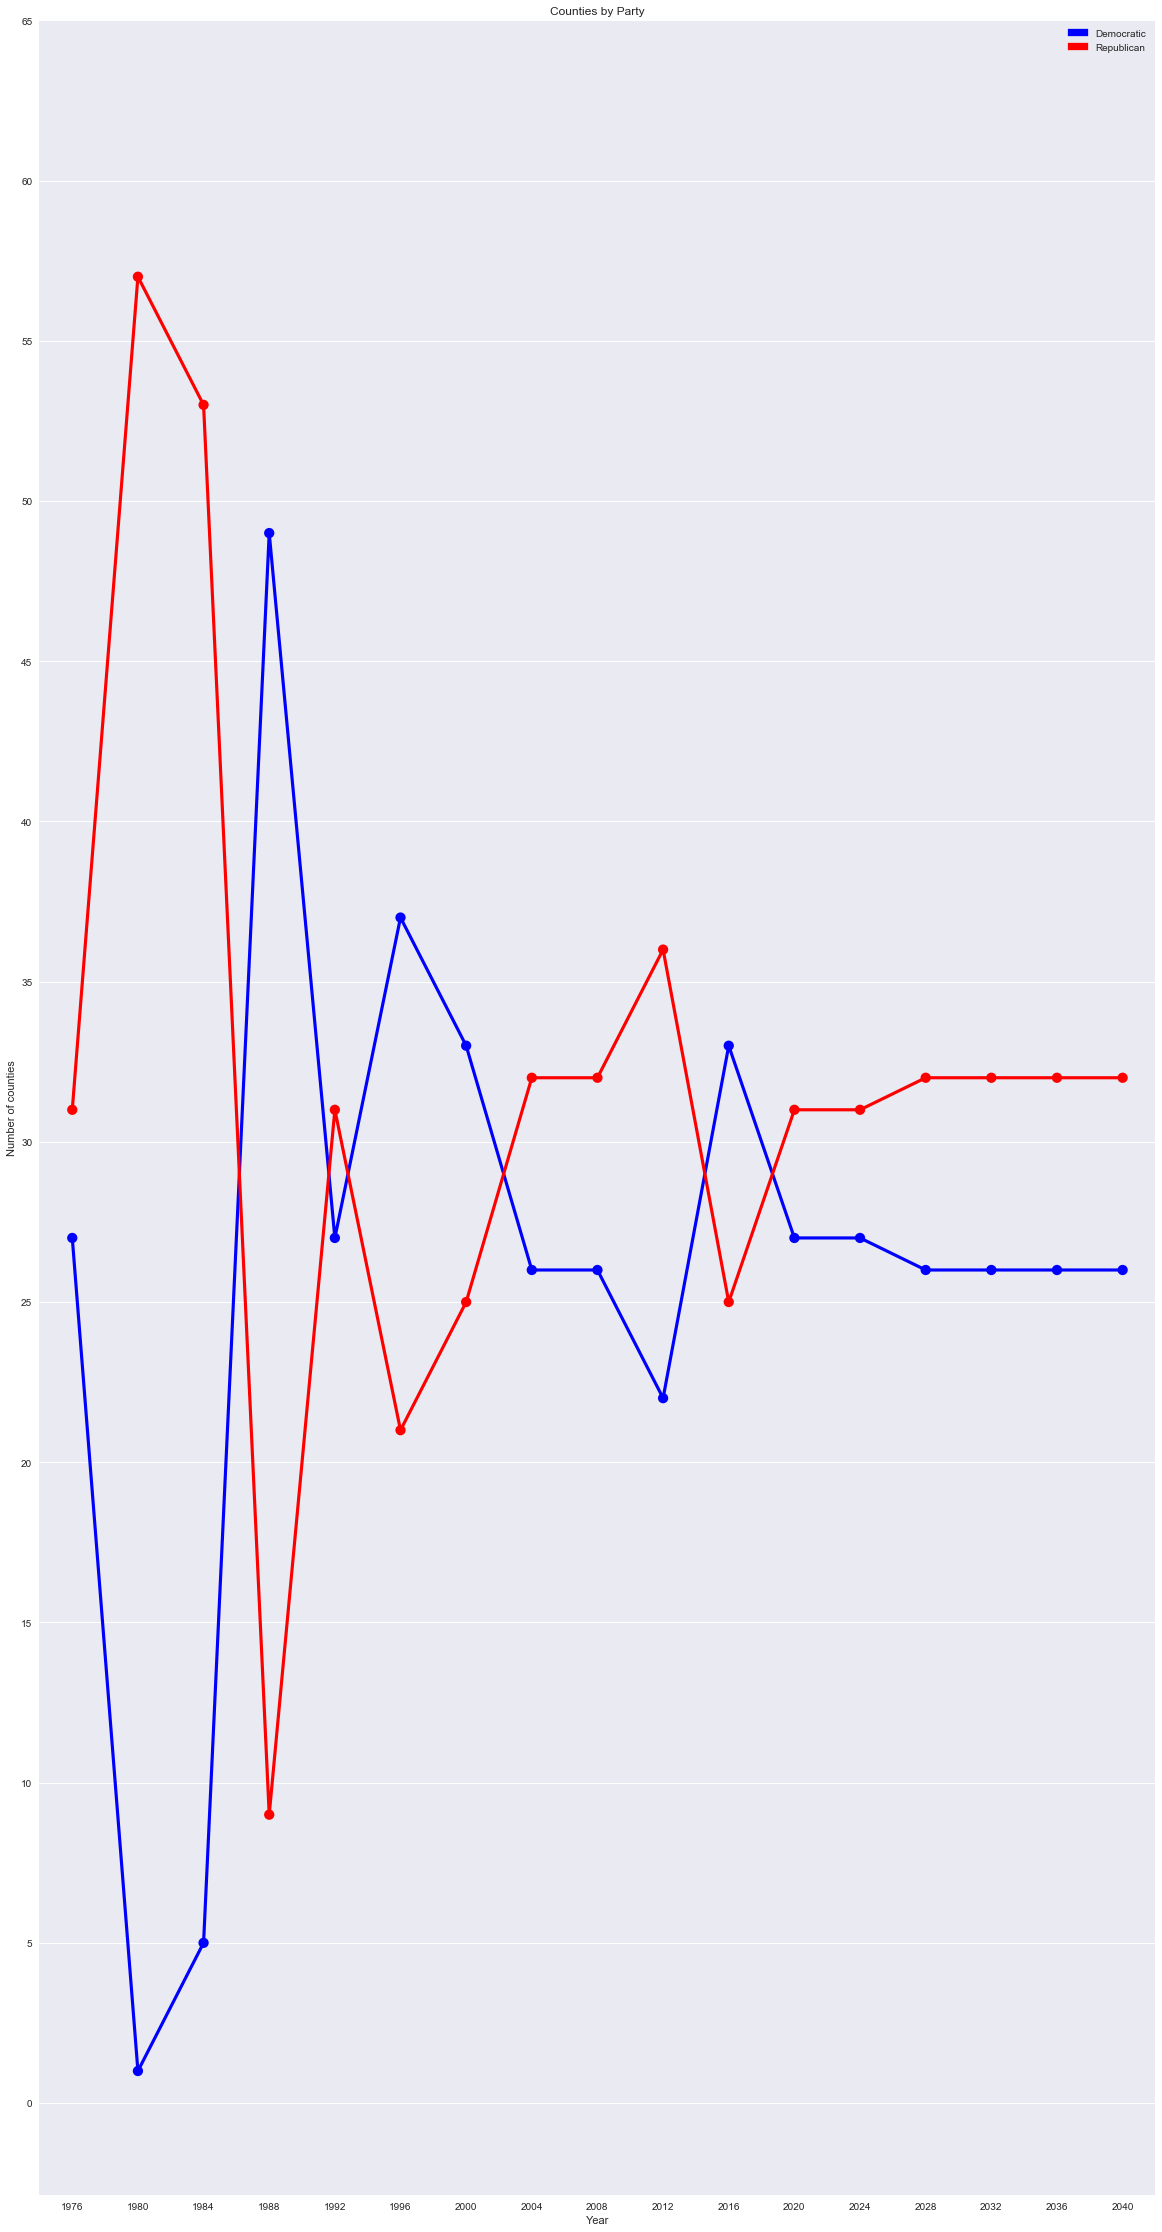

In [40]:
plotSums(californiaFrame)

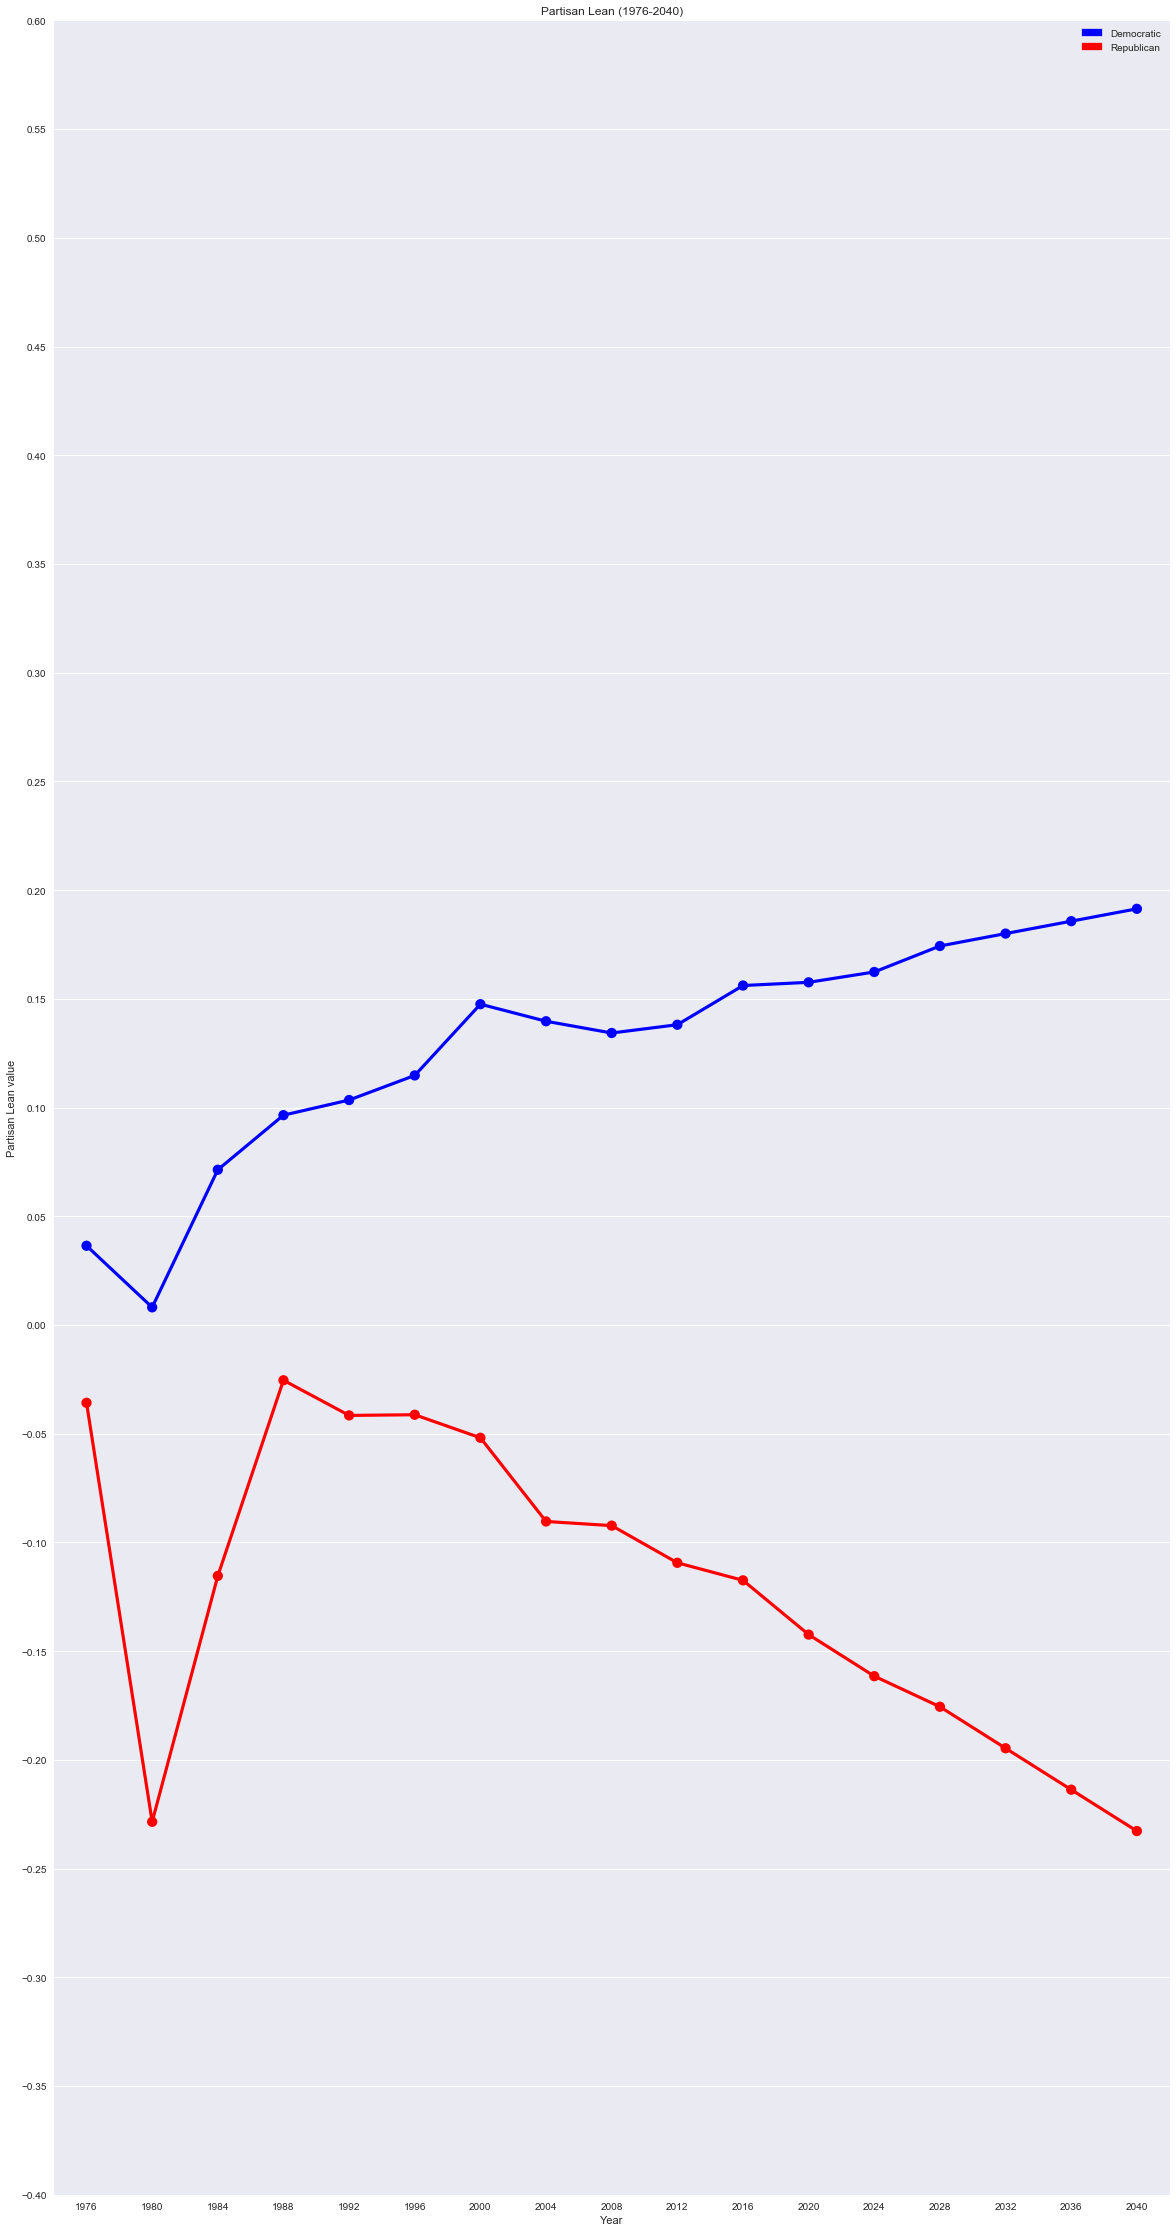

In [41]:
plotLeans(californiaFrame)

[0.3591745998954452, 0.033489044620683452, 0.13683256886326722, 0.83381024338895904, 0.58615205267568804, 0.81939170749306856, 0.90866348506164196, 0.6457023193563981, 0.64228695654801549, 0.49300771412857847, 0.90708638366876471, 0.68672043538214, 0.7764383078867656, 0.77142235104300039, 0.76864106957594369, 0.7660549703106786, 0.76364420376220854]


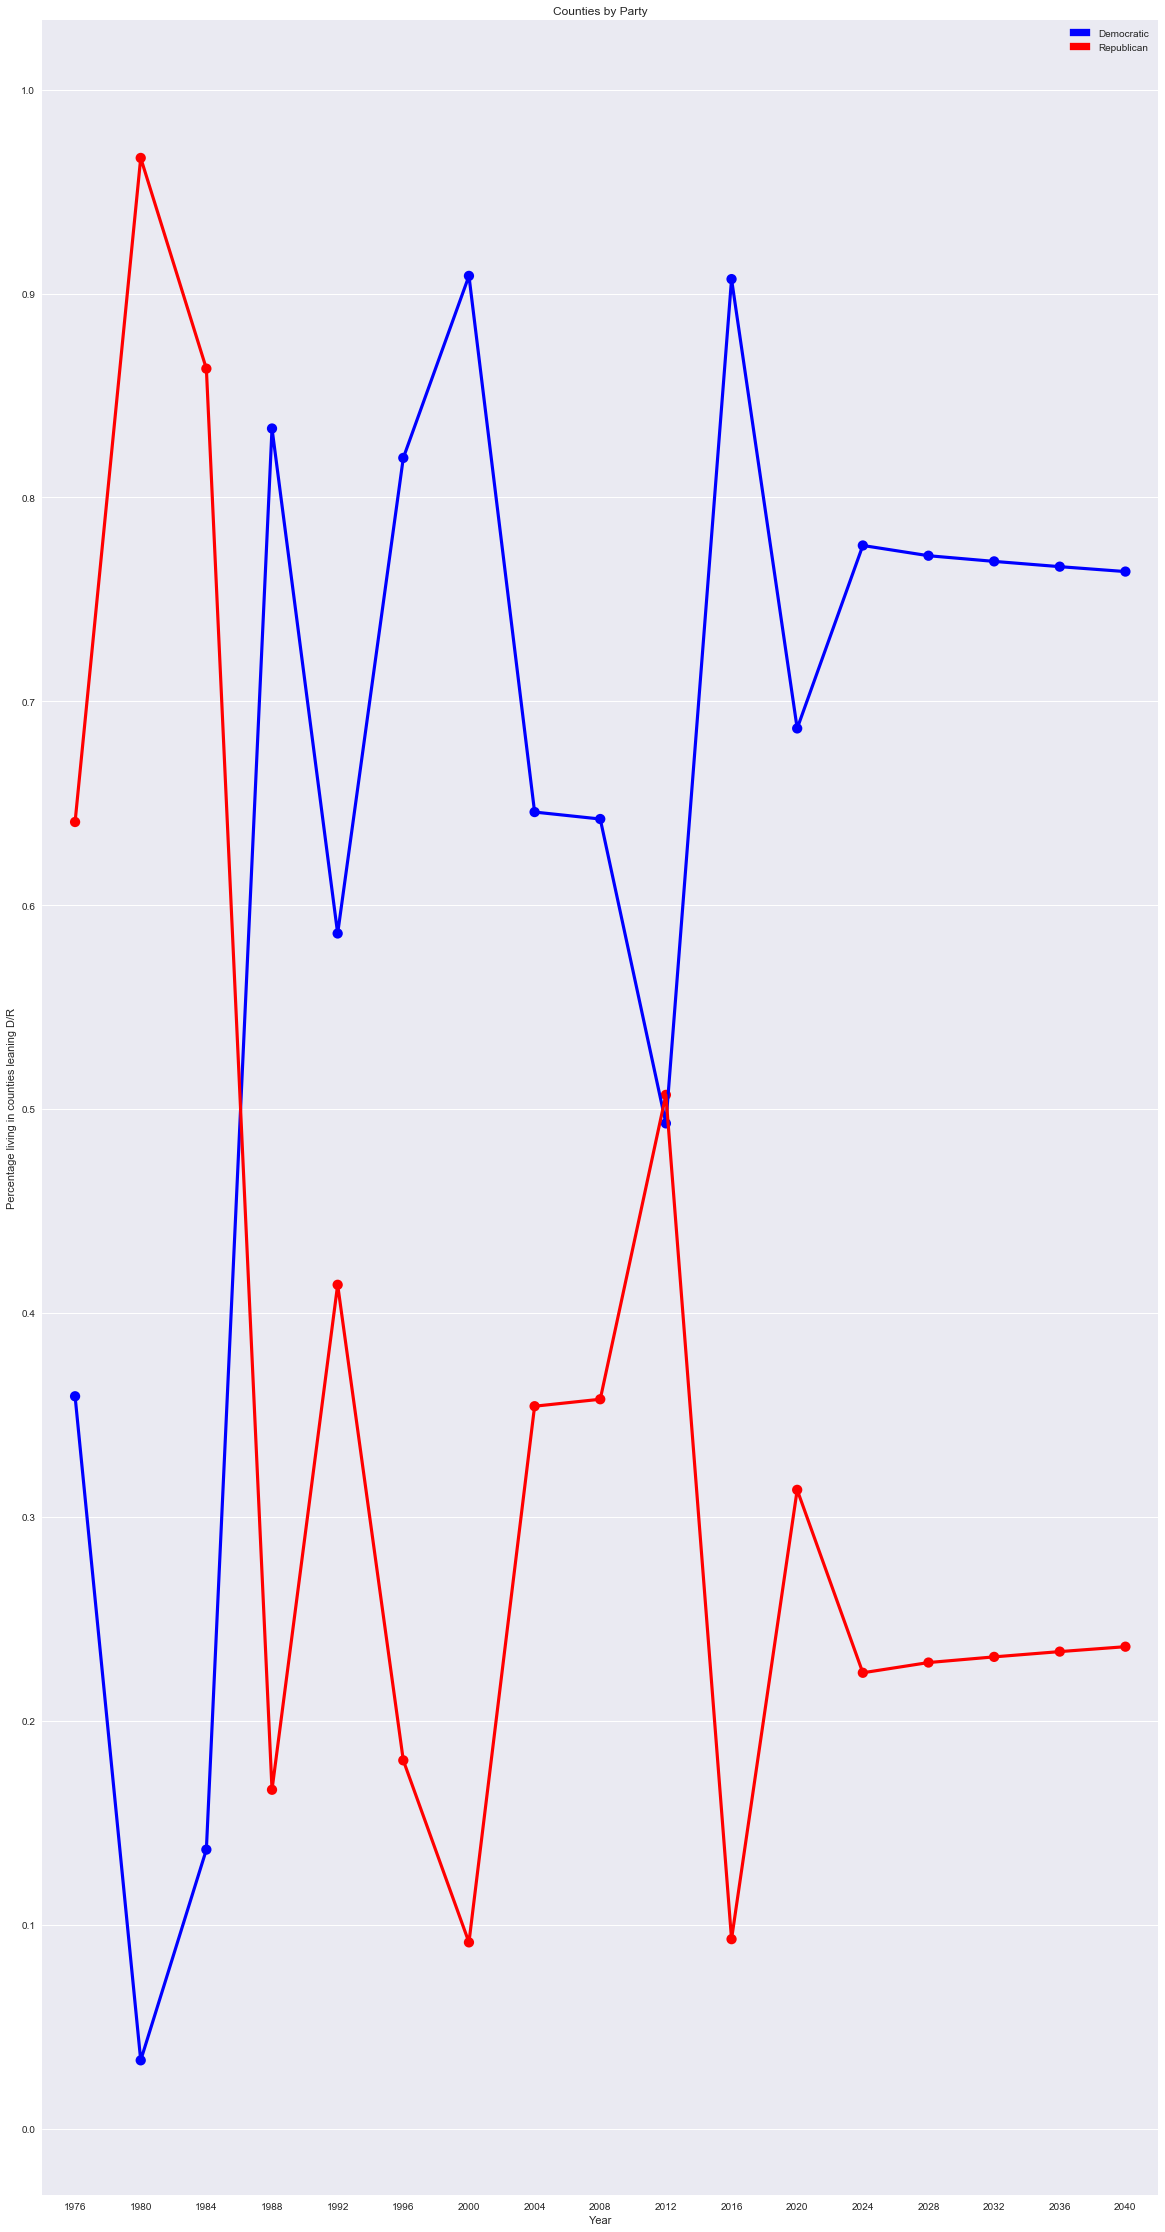

In [42]:
plotPercentages(californiaFrame)

In [43]:
newYorkFrame = pd.read_csv('newYorkResults.csv')
newYorkCounties = ["Albany","Allegany","Bronx","Broome","Cattaraugus","Cayuga","Chautauqua","Chemung","Chenango","Clinton","Columbia","Cortland","Delaware","Dutchess","Erie","Essex","Franklin","Fulton","Genesee","Greene","Hamilton","Herkimer","Jefferson","Kings","Lewis","Livingston","Madison","Monroe","Montgomery","Nassau","New York","Niagara","Oneida","Onondaga","Ontario","Orange","Orleans","Oswego","Otsego","Putnam","Queens","Rensselaer","Richmond","Rockland","Saratoga","Schenectady","Schoharie","Schuyler","Seneca","St. Lawrence","Steuben","Suffolk","Sullivan","Tioga","Tompkins","Ulster","Warren","Washington","Wayne","Westchester","Wyoming","Yates"]

In [44]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "36"):
        print(name)
        points.append(county["geometry"]["coordinates"][0])

Albany
Allegany
Bronx
Broome
Cattaraugus
Cayuga
Chautauqua
Chemung
Chenango
Clinton
Columbia
Cortland
Delaware
Dutchess
Erie
Essex
Franklin
Fulton
Genesee
Greene
Hamilton
Herkimer
Jefferson
Kings
Lewis
Livingston
Madison
Monroe
Montgomery
Nassau
New York
Niagara
Oneida
Onondaga
Ontario
Orange
Orleans
Oswego
Otsego
Putnam
Queens
Rensselaer
Rockland
St. Lawrence
Saratoga
Schenectady
Schoharie
Schuyler
Seneca
Steuben
Suffolk
Sullivan
Tioga
Tompkins
Ulster
Warren
Washington
Wayne
Westchester
Wyoming
Yates


In [45]:
geo = r'ny-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(newYorkFrame), year=slider, loc=fixed((42, -74)),zoom=fixed(6), points=fixed(points))
None

In [46]:
geo = r'ny-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(newYorkFrame), year=slider)
None

Year: 1976DemTotal: 3412802.11299RepTotal: 3121574.88701
Year: 1980DemTotal: 3005848.47562RepTotal: 3195652.52438
Year: 1984DemTotal: 3130330.32872RepTotal: 3676454.67128
Year: 1988DemTotal: 3377379.07578RepTotal: 3108224.92422
Year: 1992DemTotal: 4062274.57372RepTotal: 2864520.42628
Year: 1996DemTotal: 4142731.97009RepTotal: 2173251.02991
Year: 2000DemTotal: 4305866.99873RepTotal: 2525165.00127
Year: 2004DemTotal: 4379493.61223RepTotal: 3012263.38777
Year: 2008DemTotal: 4854662.3173RepTotal: 2786164.6827
Year: 2012DemTotal: 4550471.29743RepTotal: 2530908.70257
Year: 2016DemTotal: 4754423.36328RepTotal: 2966651.63672
Year: 2020DemTotal: 4758836.5418RepTotal: 3038138.60106
Year: 2024DemTotal: 4819447.16586RepTotal: 3143676.53652
Year: 2028DemTotal: 4879449.33785RepTotal: 3249822.92406
Year: 2032DemTotal: 4938844.74861RepTotal: 3356576.07282
Year: 2036DemTotal: 4997635.08043RepTotal: 3463934.30052
Year: 2040DemTotal: 5055822.00707RepTotal: 3571895.9334


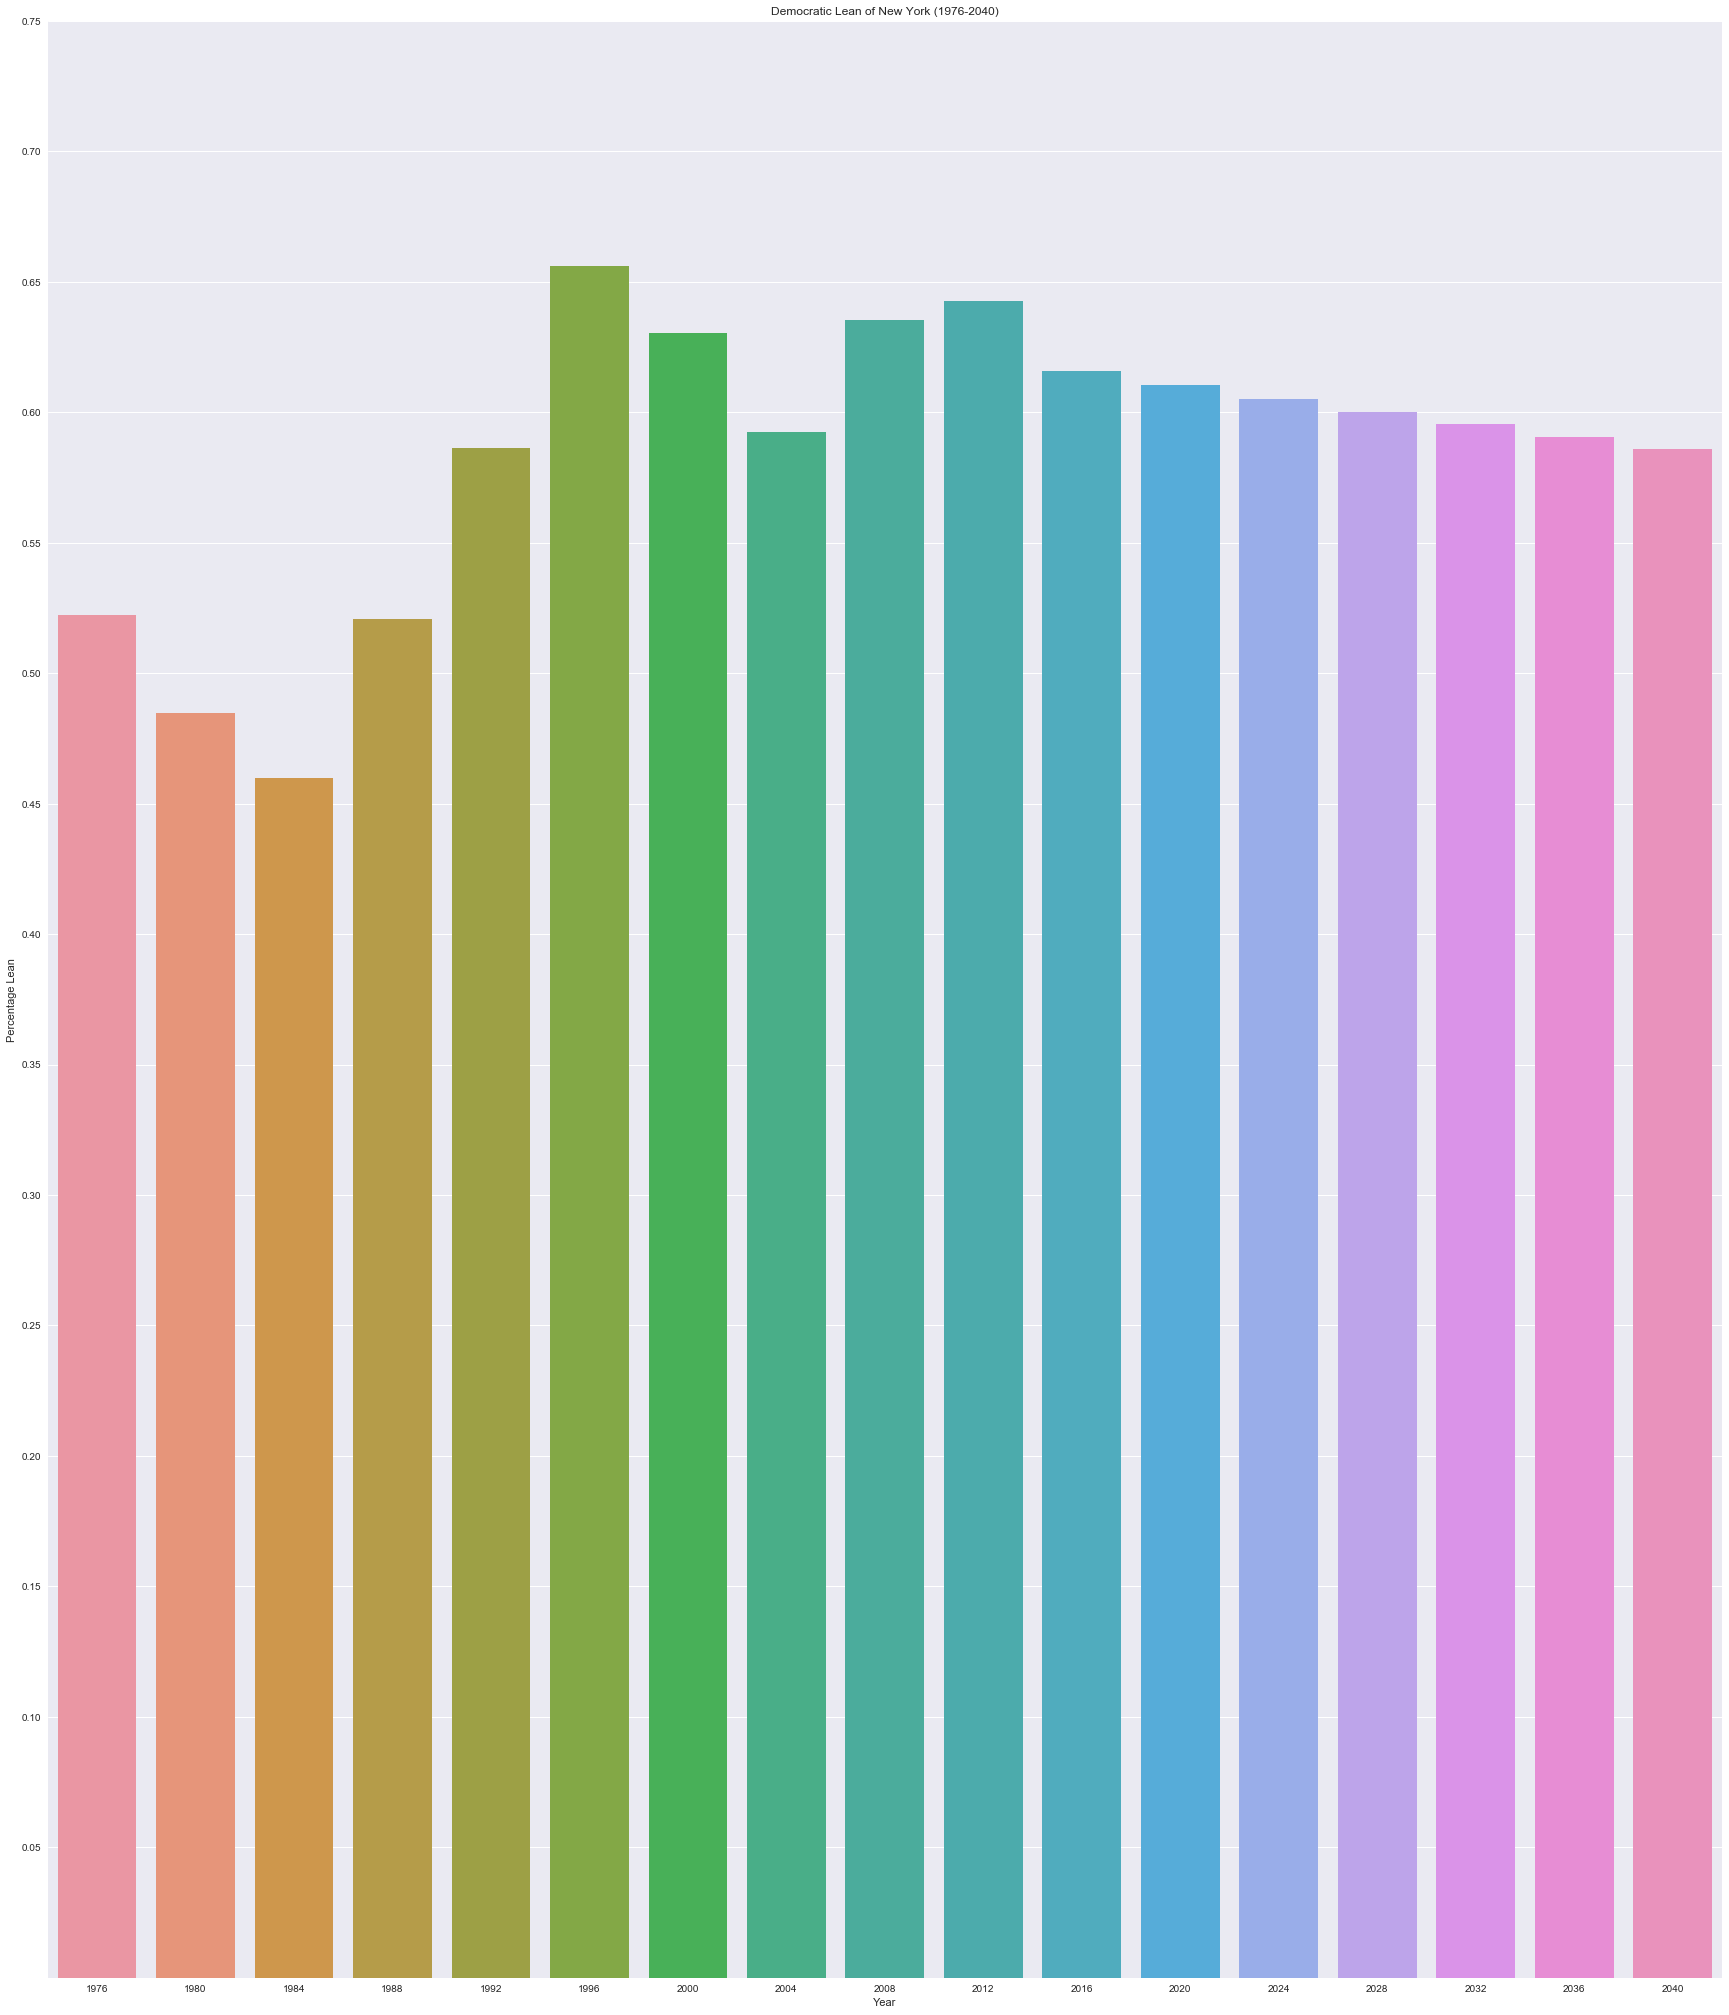

In [47]:
constructBarplot(newYorkFrame, 1976, 2044, "Democratic Lean of New York (1976-2040)")

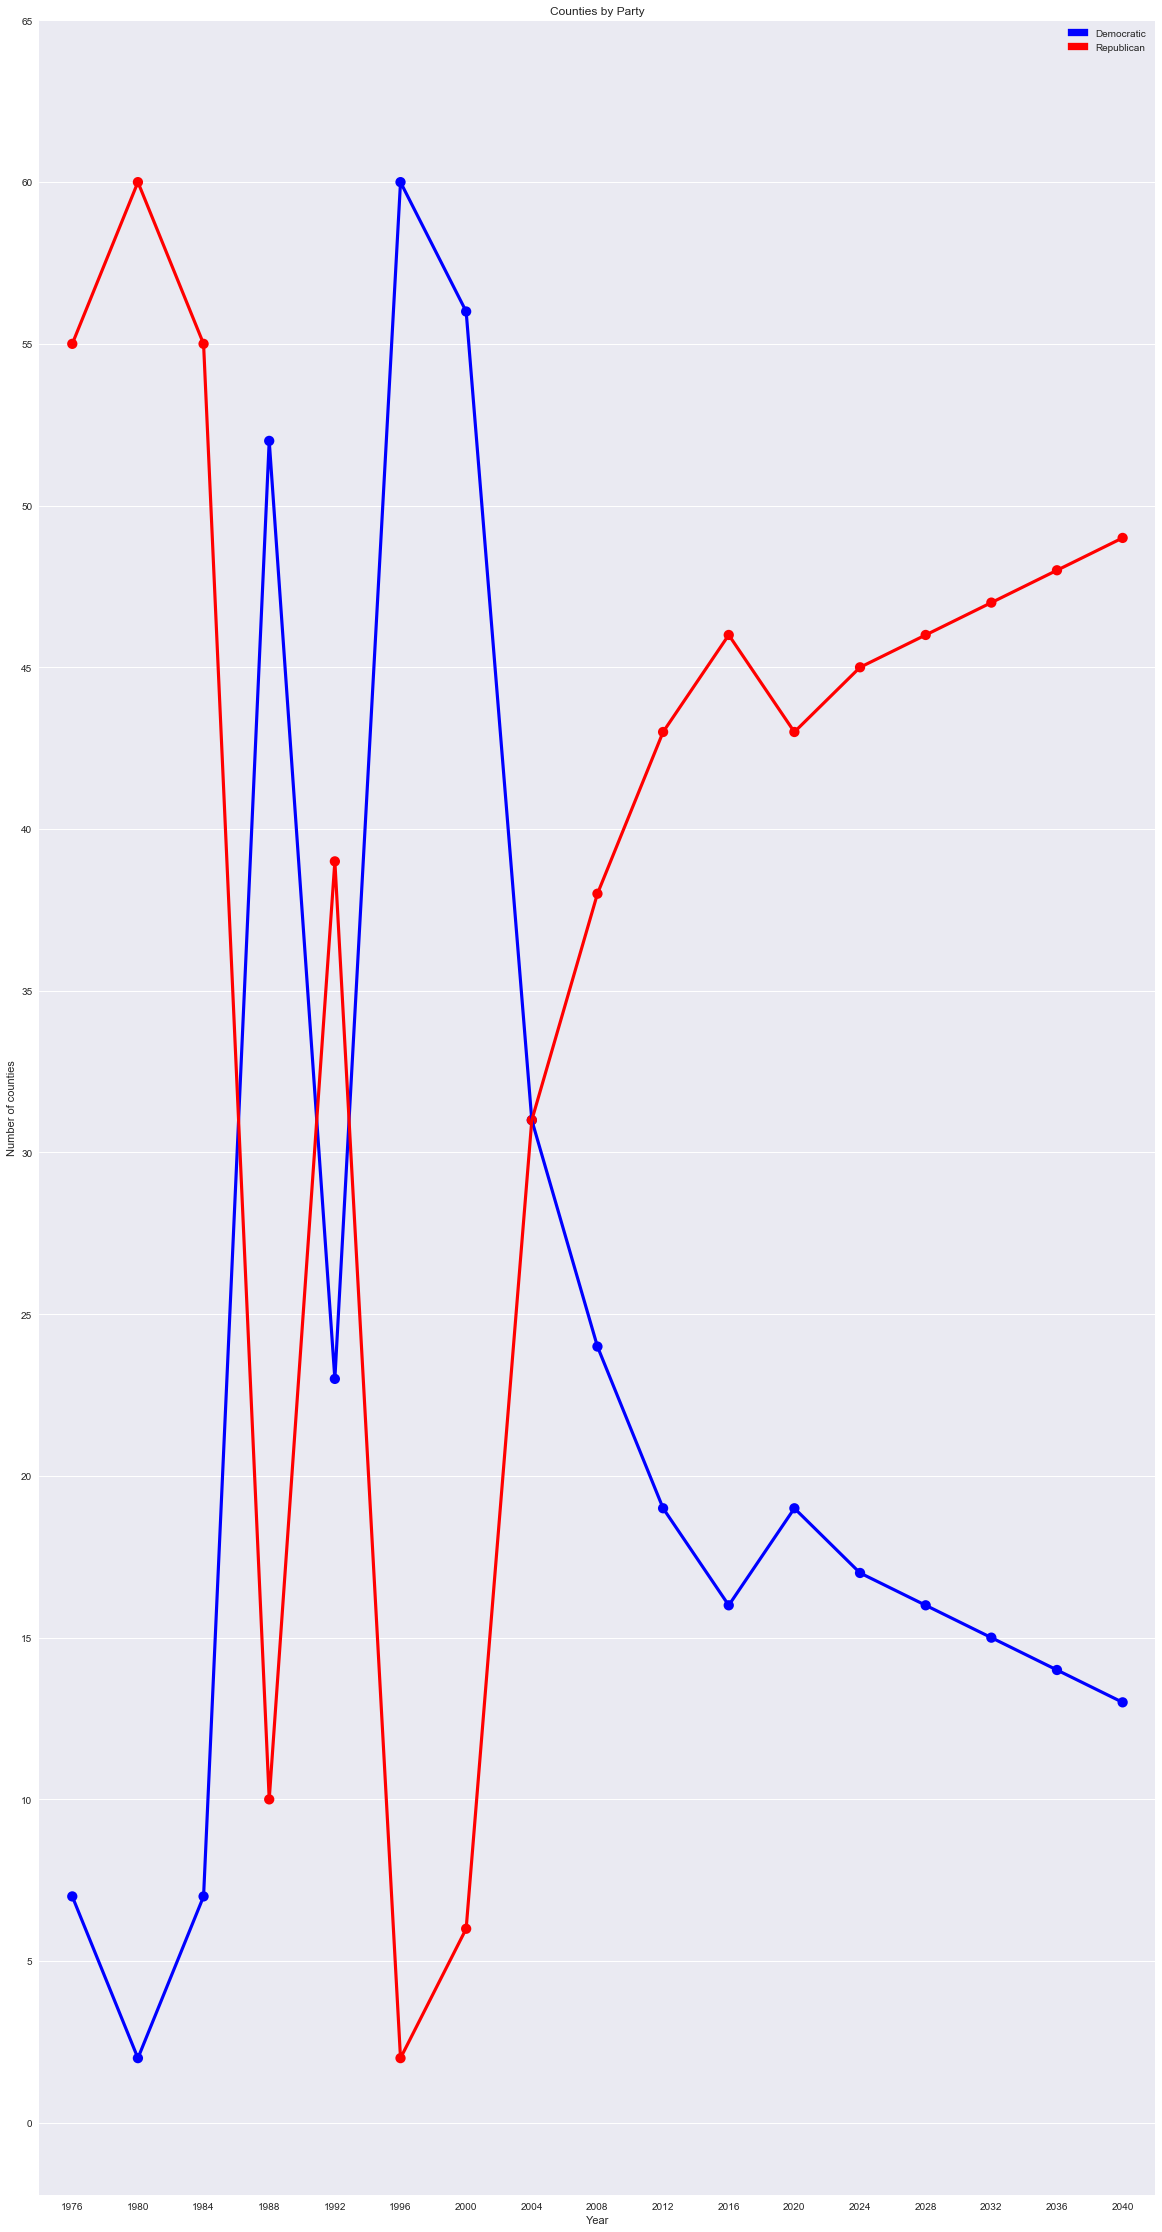

In [48]:
plotSums(newYorkFrame)

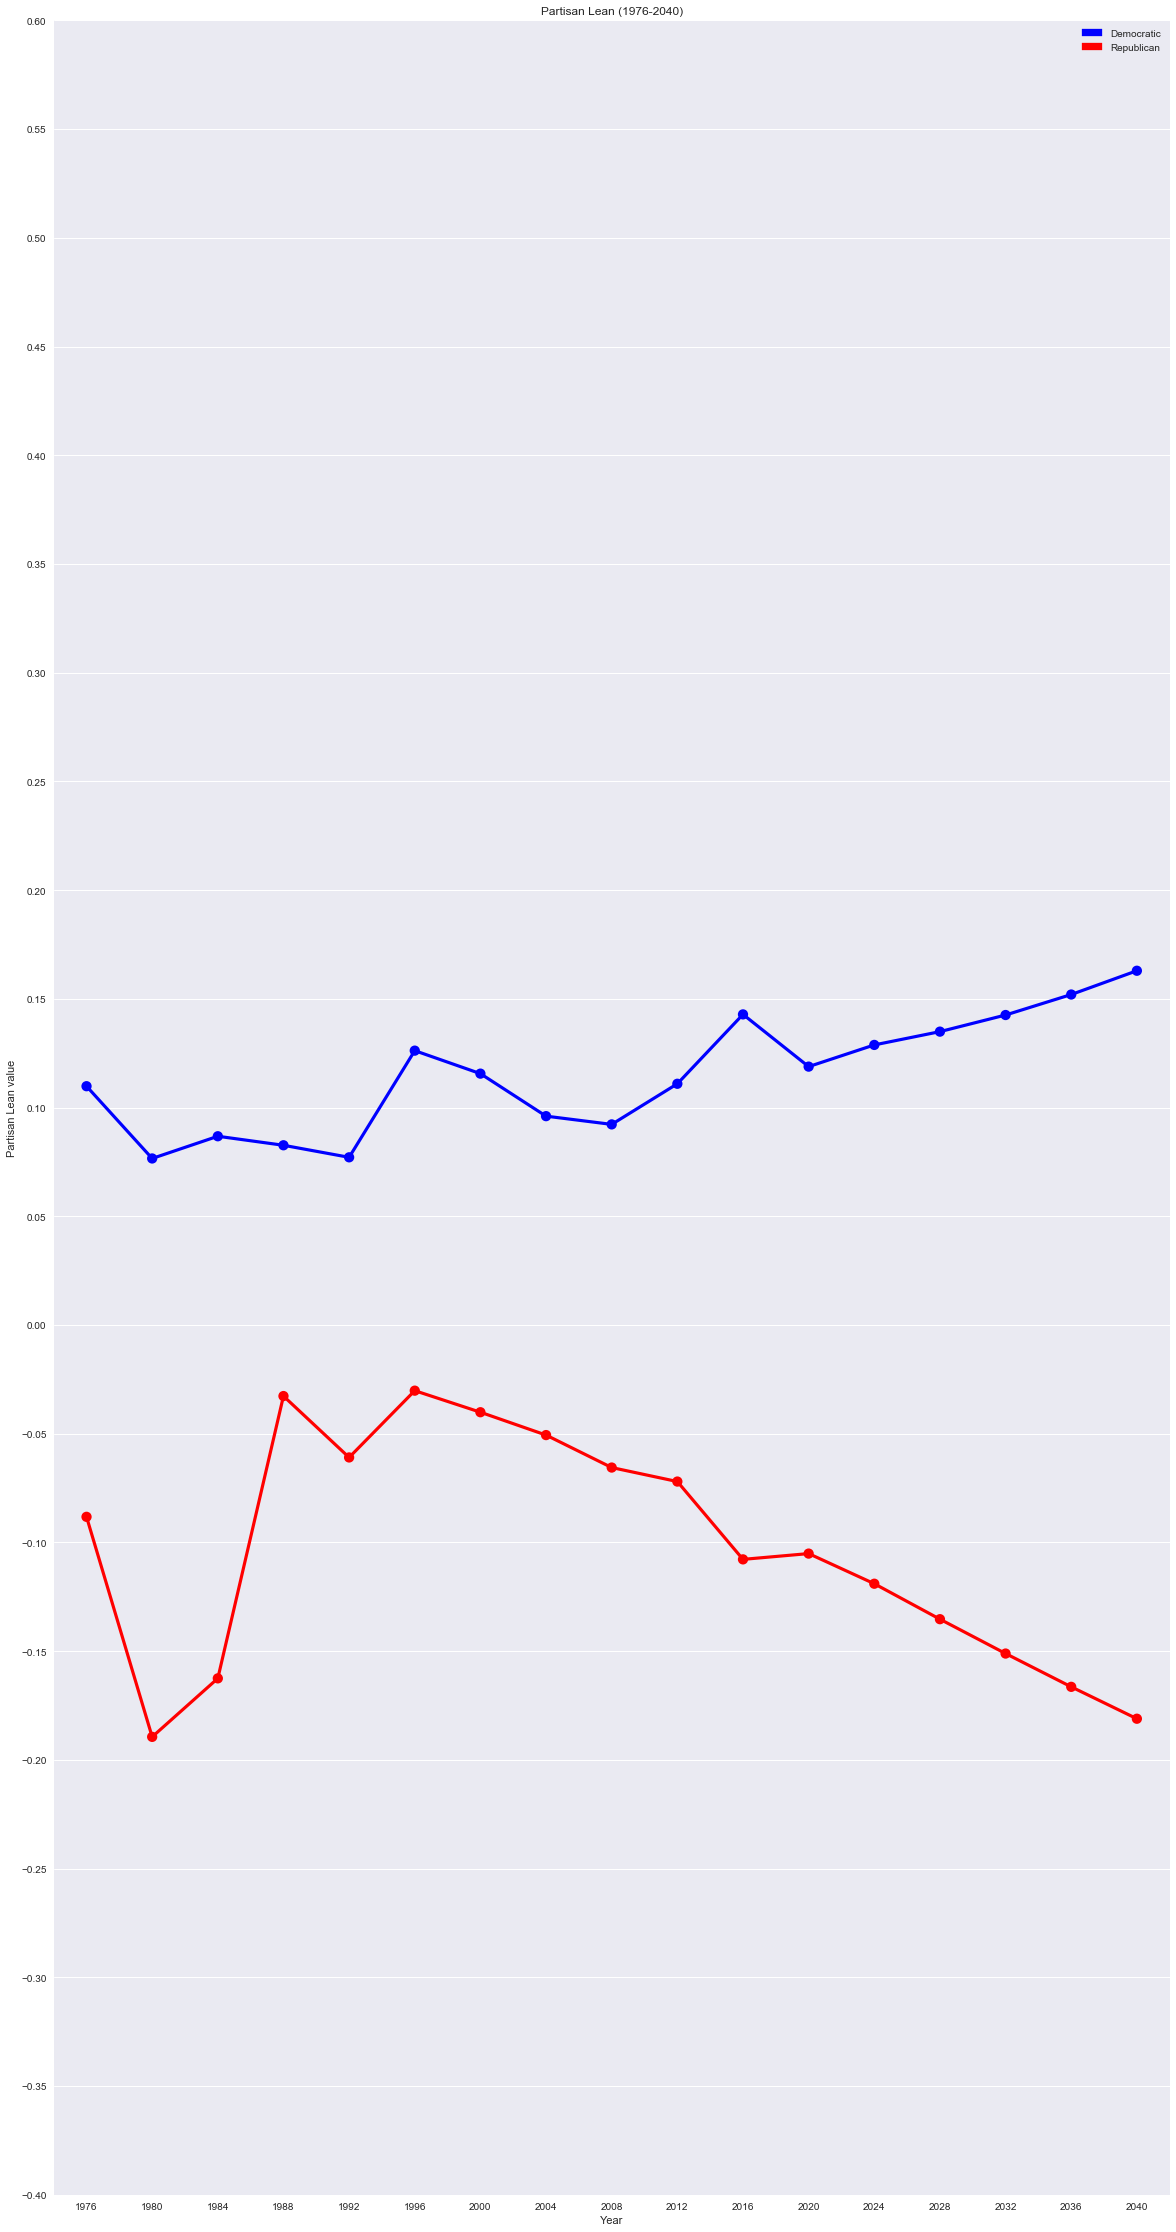

In [49]:
plotLeans(newYorkFrame)

In [50]:
arizonaCounties = ["Apache", "Cochise", "Coconino", "Gila", "Graham", "Greenlee", "La Paz", "Maricopa", "Mohave", "Navajo", "Pima", "Pinal", "Santa Cruz", "Yavapai", "Yuma"]
arizonaFrame = pd.read_csv('arizonaResults.csv')

In [51]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0] == "4"):
        print(name)
        points.append(county["geometry"]["coordinates"][0])

Apache
Cochise
Coconino
Gila
Graham
Greenlee
La Paz
Maricopa
Mohave
Navajo
Pima
Pinal
Santa Cruz
Yavapai
Yuma
Adair
Alfalfa
Atoka
Beaver
Beckham
Blaine
Bryan
Caddo
Canadian
Carter
Cherokee
Choctaw
Cimarron
Cleveland
Coal
Comanche
Cotton
Craig
Creek
Custer
Delaware
Dewey
Ellis
Garfield
Garvin
Grady
Grant
Greer
Harmon
Harper
Haskell
Hughes
Jackson
Jefferson
Johnston
Kay
Kingfisher
Kiowa
Latimer
Le Flore
Lincoln
Logan
Love
McClain
McCurtain
McIntosh
Major
Marshall
Mayes
Murray
Muskogee
Noble
Nowata
Okfuskee
Oklahoma
Okmulgee
Osage
Ottawa
Pawnee
Payne
Pittsburg
Pontotoc
Pottawatomie
Pushmataha
Roger Mills
Rogers
Seminole
Sequoyah
Stephens
Texas
Tillman
Tulsa
Wagoner
Washington
Washita
Woods
Woodward
Baker
Benton
Clackamas
Clatsop
Columbia
Coos
Crook
Curry
Deschutes
Douglas
Gilliam
Grant
Harney
Hood River
Jackson
Jefferson
Josephine
Klamath
Lake
Lane
Lincoln
Linn
Malheur
Marion
Morrow
Multnomah
Polk
Sherman
Tillamook
Umatilla
Union
Wallowa
Wasco
Washington
Wheeler
Yamhill
Adams
Allegheny
Ar

In [52]:
geo = r'az-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(arizonaFrame), year=slider, loc=fixed((37.8, -120)),zoom=fixed(5), points=fixed(points))
None

In [53]:
geo = r'az-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(arizonaFrame), year=slider)
None

Year: 1976DemTotal: 3412802.11299RepTotal: 3121574.88701
Year: 1980DemTotal: 3005848.47562RepTotal: 3195652.52438
Year: 1984DemTotal: 3130330.32872RepTotal: 3676454.67128
Year: 1988DemTotal: 3377379.07578RepTotal: 3108224.92422
Year: 1992DemTotal: 4062274.57372RepTotal: 2864520.42628
Year: 1996DemTotal: 4142731.97009RepTotal: 2173251.02991
Year: 2000DemTotal: 4305866.99873RepTotal: 2525165.00127
Year: 2004DemTotal: 4379493.61223RepTotal: 3012263.38777
Year: 2008DemTotal: 4854662.3173RepTotal: 2786164.6827
Year: 2012DemTotal: 4550471.29743RepTotal: 2530908.70257
Year: 2016DemTotal: 4754423.36328RepTotal: 2966651.63672
Year: 2020DemTotal: 4758836.5418RepTotal: 3038138.60106
Year: 2024DemTotal: 4819447.16586RepTotal: 3143676.53652
Year: 2028DemTotal: 4879449.33785RepTotal: 3249822.92406
Year: 2032DemTotal: 4938844.74861RepTotal: 3356576.07282
Year: 2036DemTotal: 4997635.08043RepTotal: 3463934.30052
Year: 2040DemTotal: 5055822.00707RepTotal: 3571895.9334


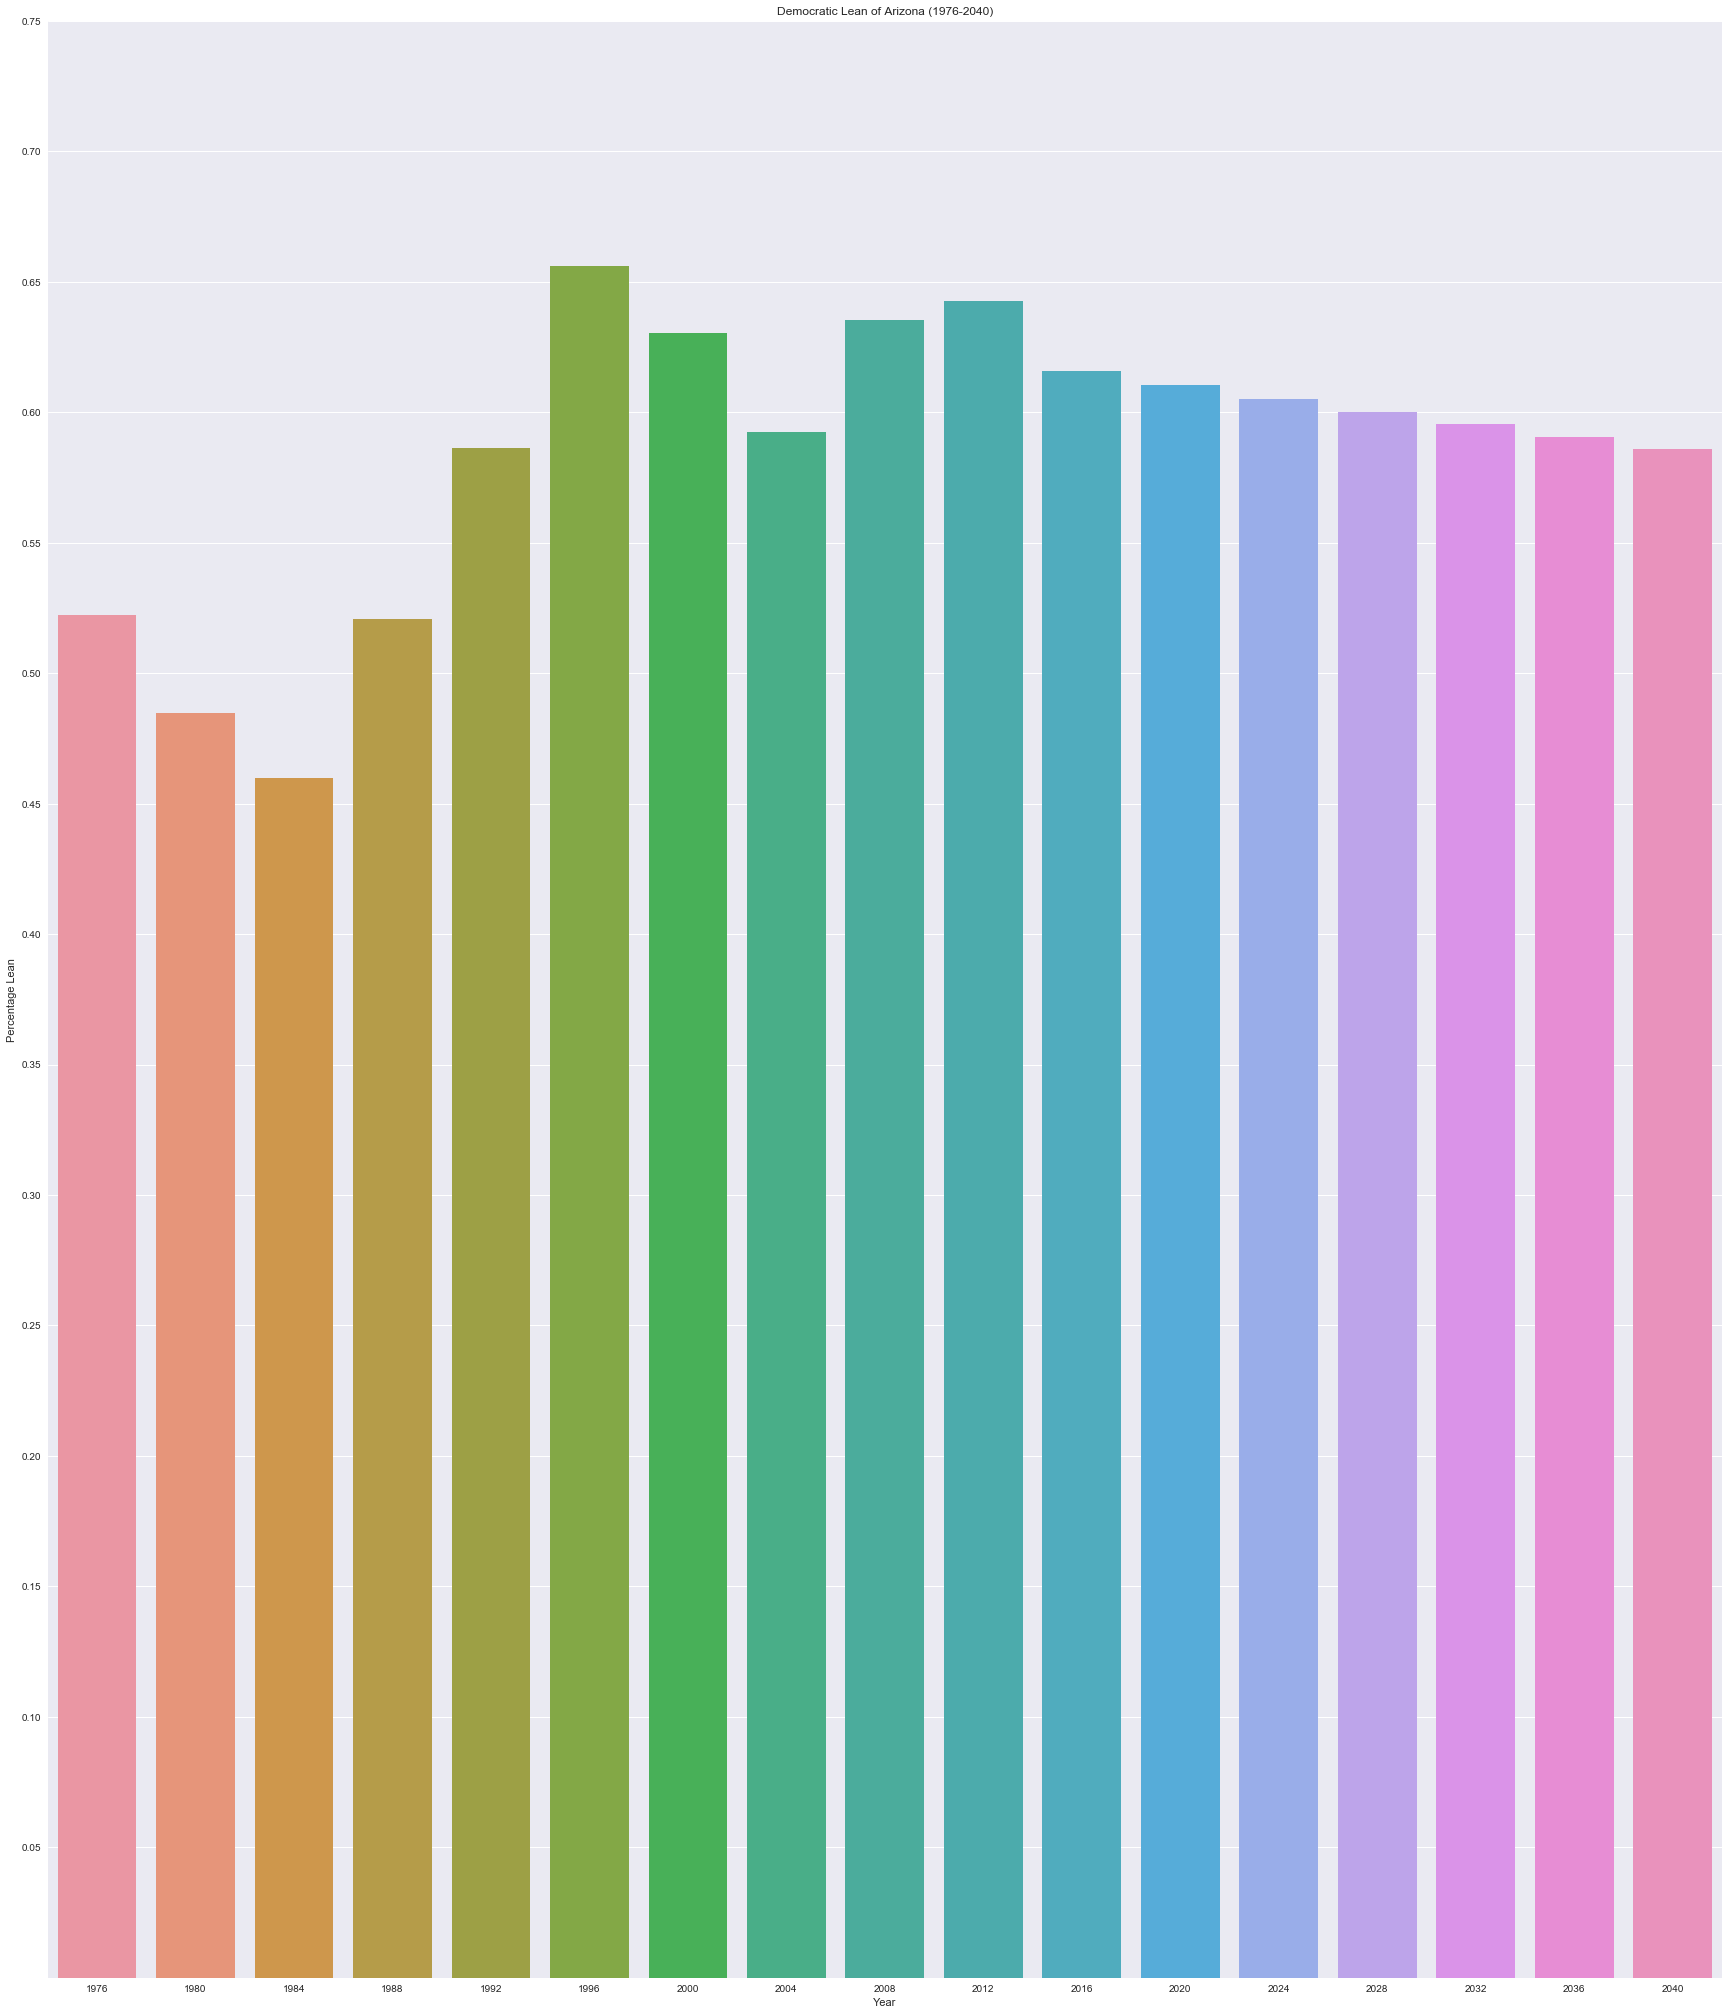

In [54]:
constructBarplot(newYorkFrame, 1976, 2044, "Democratic Lean of Arizona (1976-2040)")

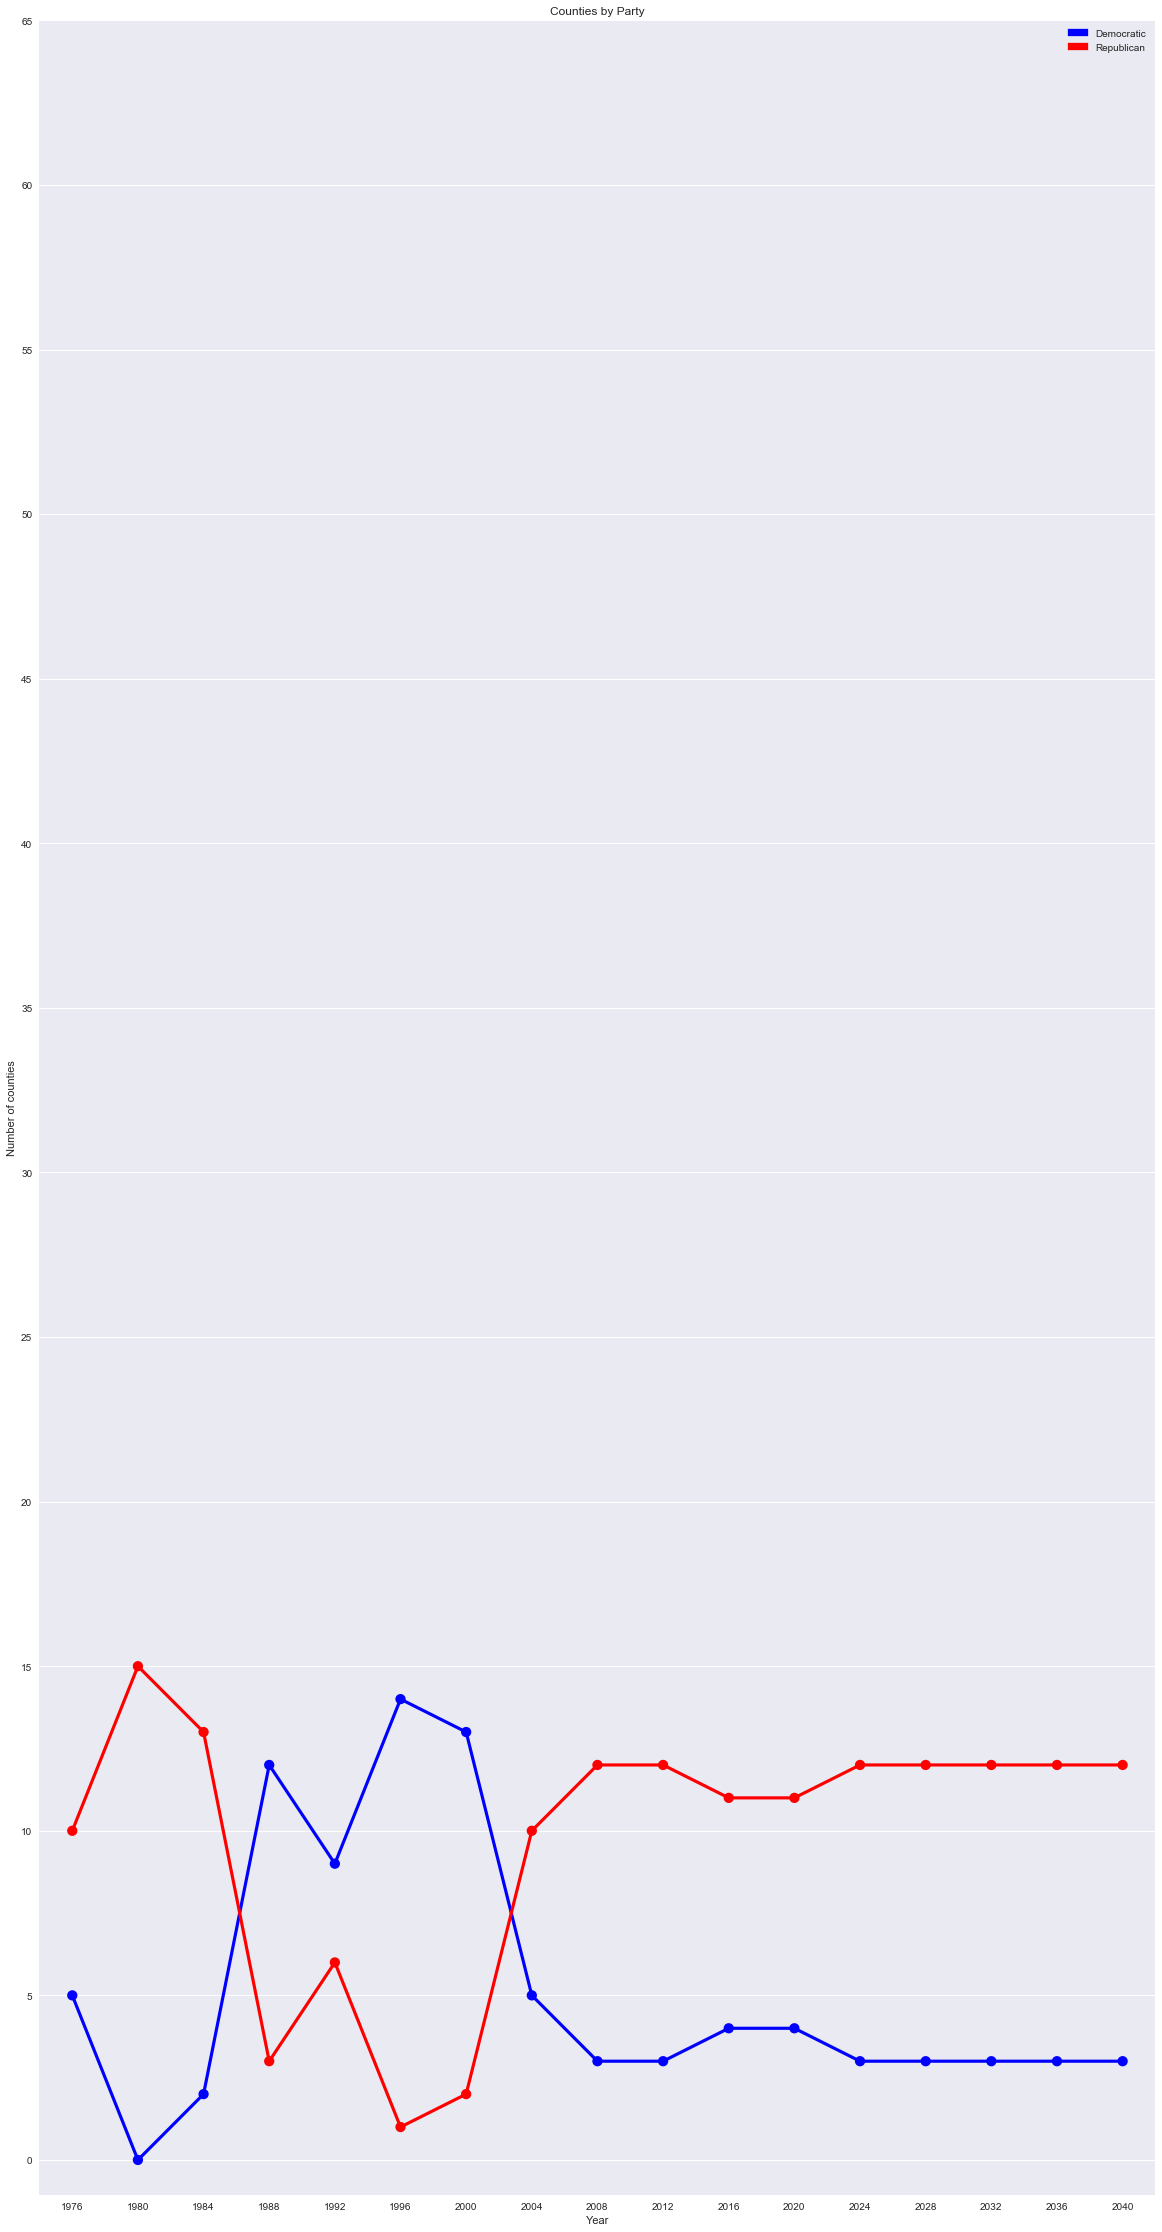

In [55]:
plotSums(arizonaFrame)

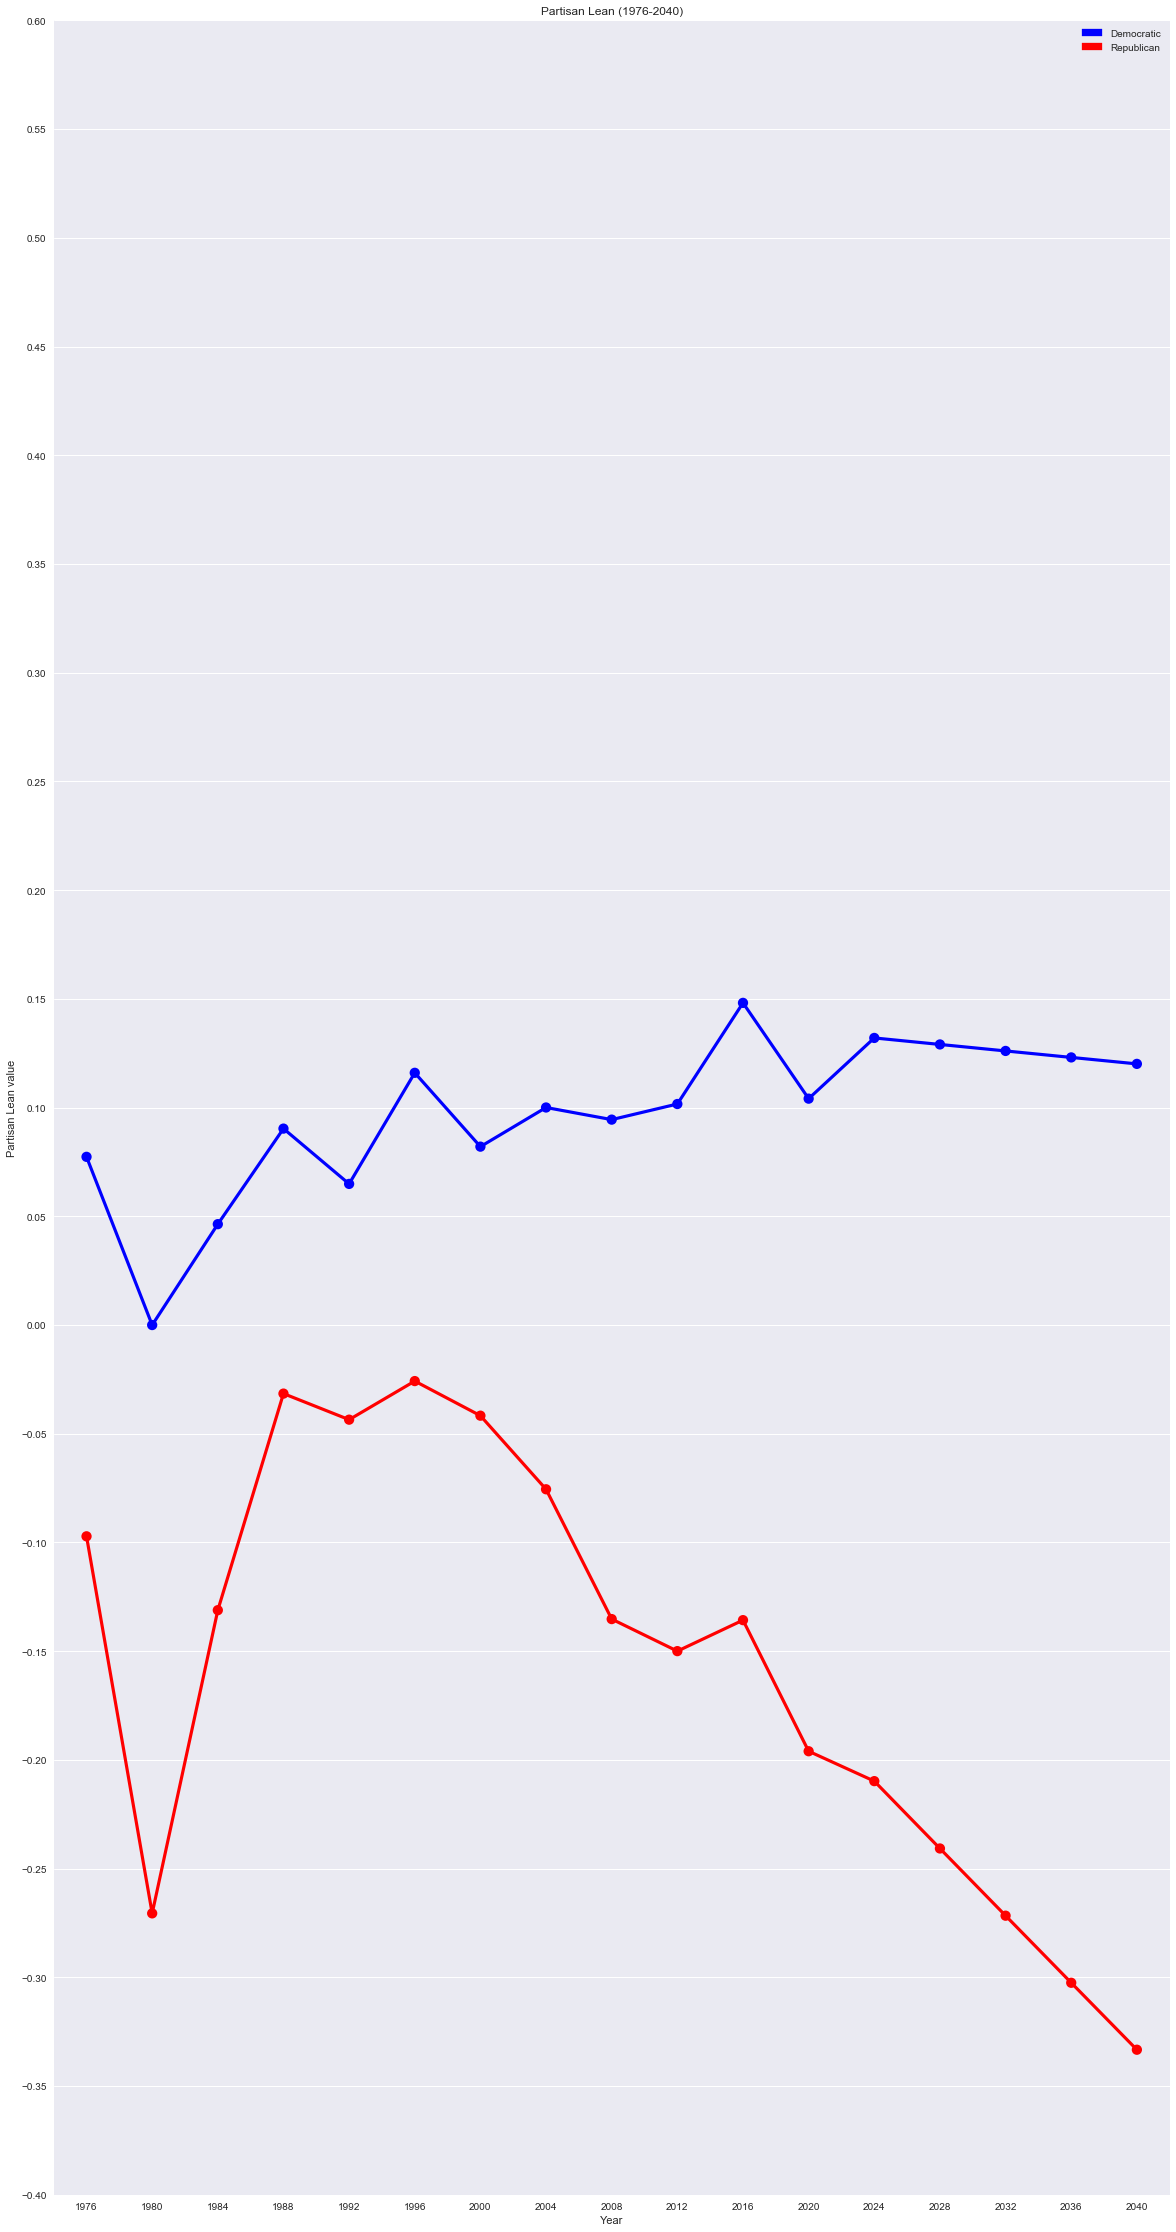

In [56]:
plotLeans(arizonaFrame)

In [57]:
coloradoCounties = ["Adams" ,"Alamosa" ,"Arapahoe" ,"Archuleta" ,"Baca" ,"Bent" ,"Boulder" ,"Broomfield" ,"Chaffee" ,"Cheyenne" ,"Clear Creek" ,"Conejos" ,"Costilla" ,"Crowley" ,"Custer" ,"Delta" ,"Denver" ,"Dolores" ,"Douglas" ,"Eagle" ,"El Paso" ,"Elbert" ,"Fremont" ,"Garfield" ,"Gilpin" ,"Grand" ,"Gunnison" ,"Hinsdale" ,"Huerfano" ,"Jackson" ,"Jefferson" ,"Kiowa" ,"Kit Carson" ,"La Plata" ,"Lake" ,"Larimer" ,"Las Animas" ,"Lincoln" ,"Logan" ,"Mesa" ,"Mineral" ,"Moffat" ,"Montezuma" ,"Montrose" ,"Morgan" ,"Otero" ,"Ouray" ,"Park" ,"Phillips" ,"Pitkin" ,"Prowers" ,"Pueblo" ,"Rio Blanco" ,"Rio Grande" ,"Routt" ,"Saguache" ,"San Juan" ,"San Miguel" ,"Sedgwick" ,"Summit" ,"Teller" ,"Washington" ,"Weld" ,"Yuma"]
coloradoFrame = pd.read_csv('coloradoResults.csv')
geo = r'co-counties.json'

In [58]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    if (county["id"][0] == "8" and len(county["id"]) == 4):
         points.append(county["geometry"]["coordinates"][0])

In [59]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(coloradoFrame), year=slider, loc=fixed((39.5, -105.7)),zoom=fixed(6), points=fixed(points))
None

In [60]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(coloradoFrame), year=slider)
None

Year: 1976DemTotal: 476360.60901RepTotal: 604647.43099
Year: 1980DemTotal: 428384.940117RepTotal: 755938.099883
Year: 1984DemTotal: 461914.269512RepTotal: 833391.770488
Year: 1988DemTotal: 632241.674704RepTotal: 740086.365296
Year: 1992DemTotal: 825004.664362RepTotal: 744155.375638
Year: 1996DemTotal: 744393.543146RepTotal: 766248.496854
Year: 2000DemTotal: 795108.060958RepTotal: 946196.979042
Year: 2004DemTotal: 1014841.17248RepTotal: 1115444.82752
Year: 2008DemTotal: 1310108.74675RepTotal: 1091273.25325
Year: 2012DemTotal: 1356645.6018RepTotal: 1215100.3982
Year: 2016DemTotal: 1463874.68332RepTotal: 1316190.31668
Year: 2020DemTotal: 1474302.96078RepTotal: 1495754.68208
Year: 2024DemTotal: 1565091.29382RepTotal: 1618397.99189
Year: 2028DemTotal: 1655361.81081RepTotal: 1741559.11776
Year: 2032DemTotal: 1745204.5131RepTotal: 1865148.05833
Year: 2036DemTotal: 1831936.01448RepTotal: 1991848.19981
Year: 2040DemTotal: 1914143.47955RepTotal: 2123072.3776


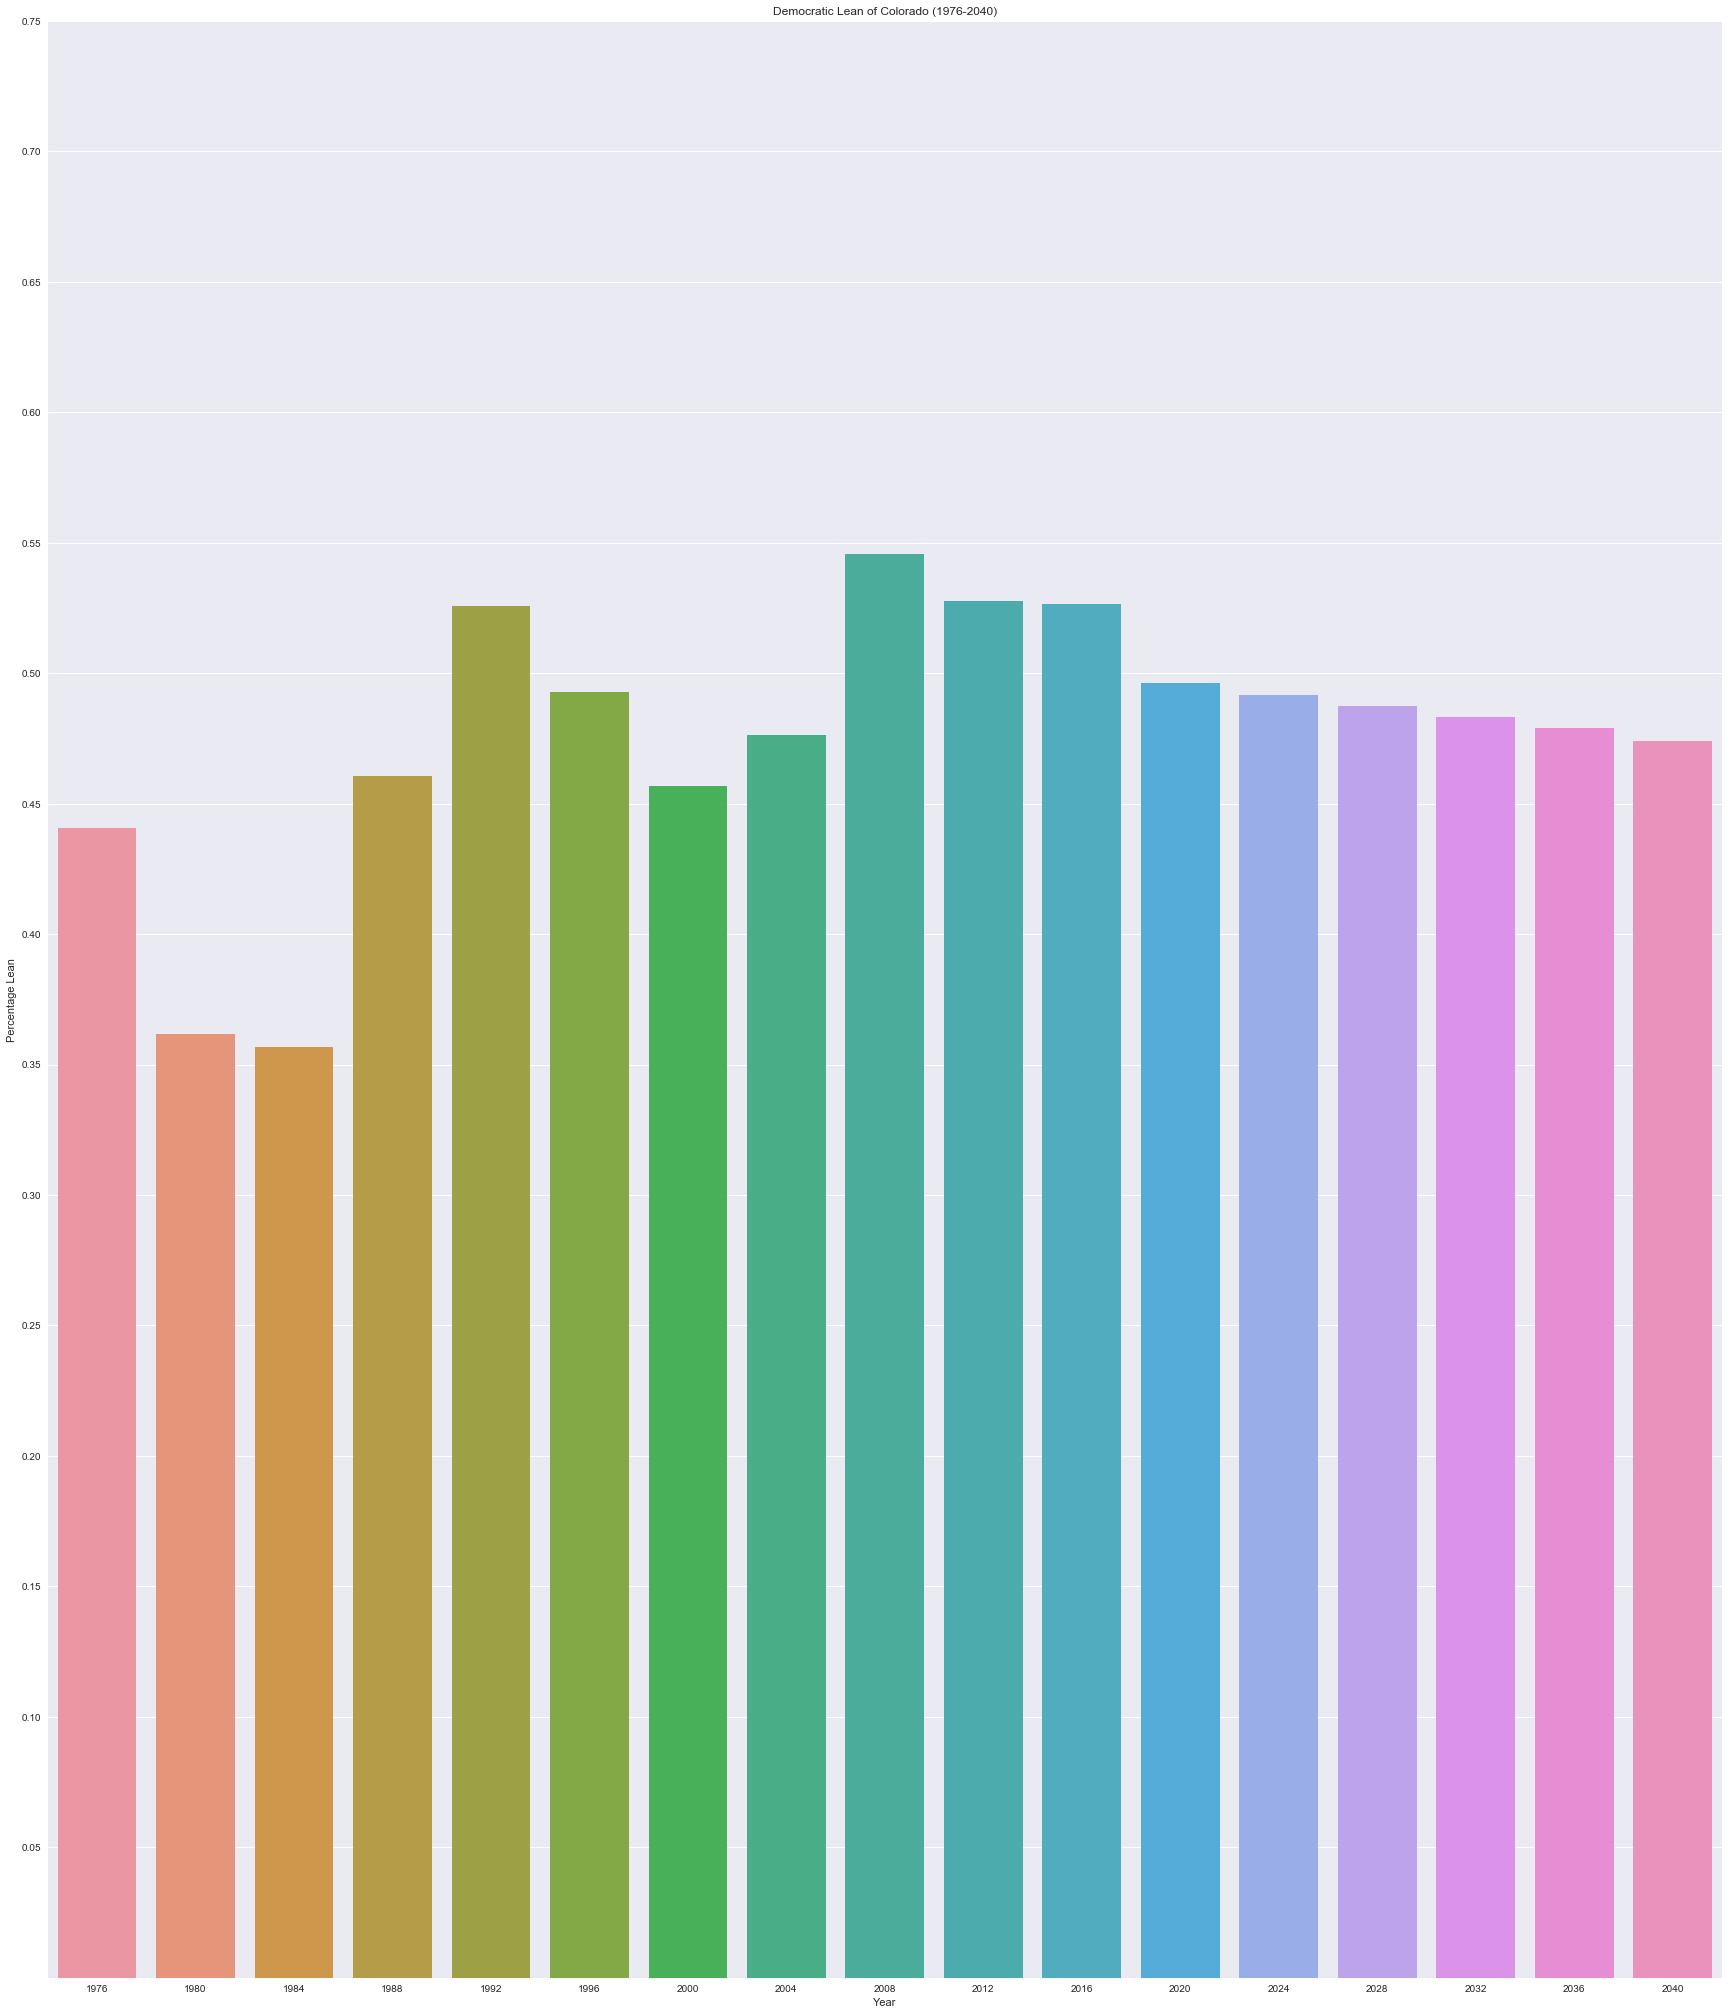

In [61]:
constructBarplot(coloradoFrame, 1976, 2044, "Democratic Lean of Colorado (1976-2040)")

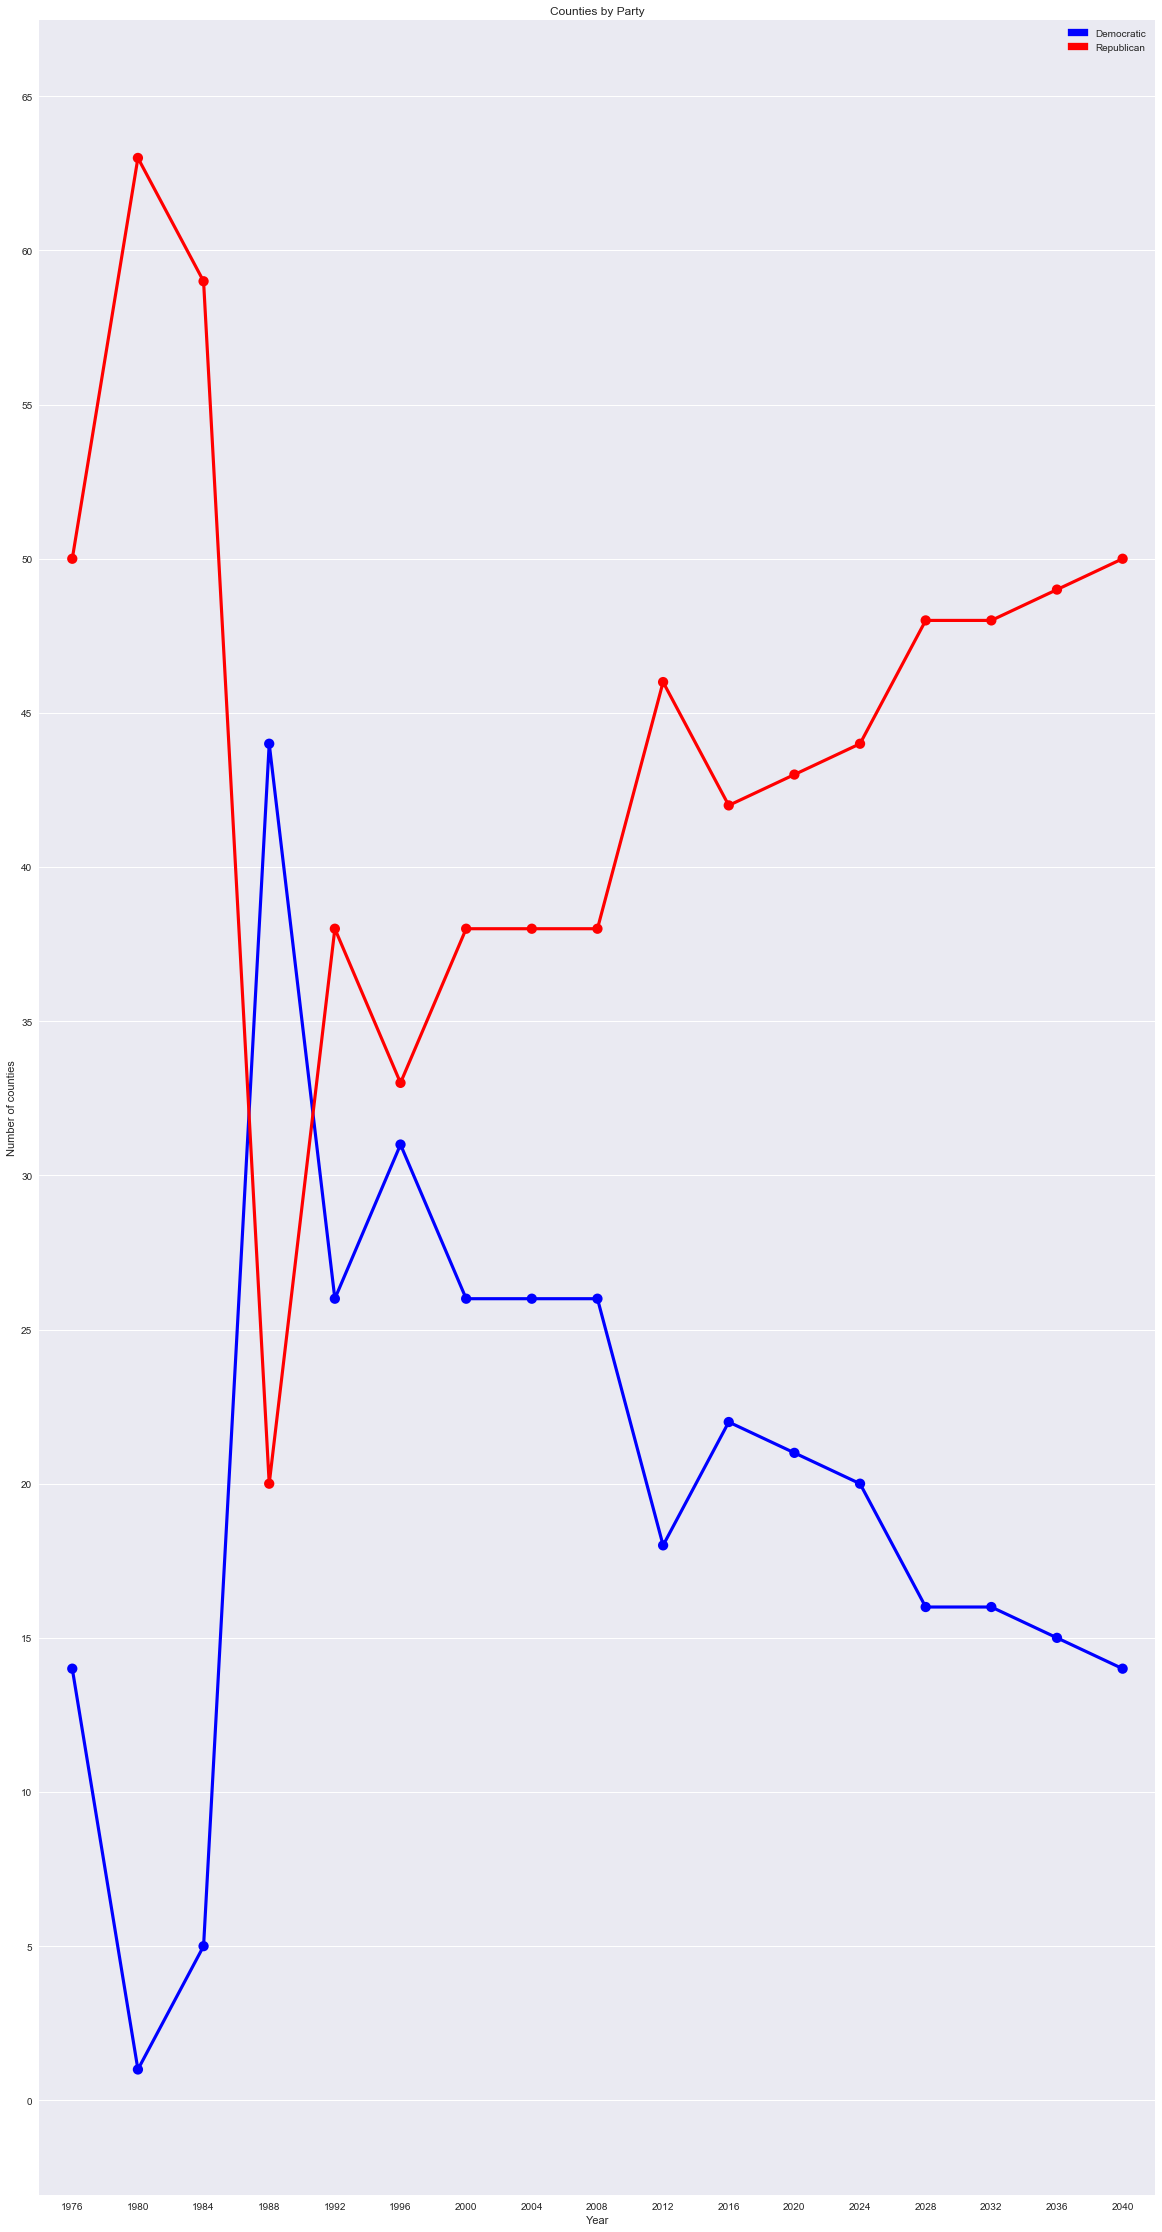

In [62]:
plotSums(coloradoFrame)

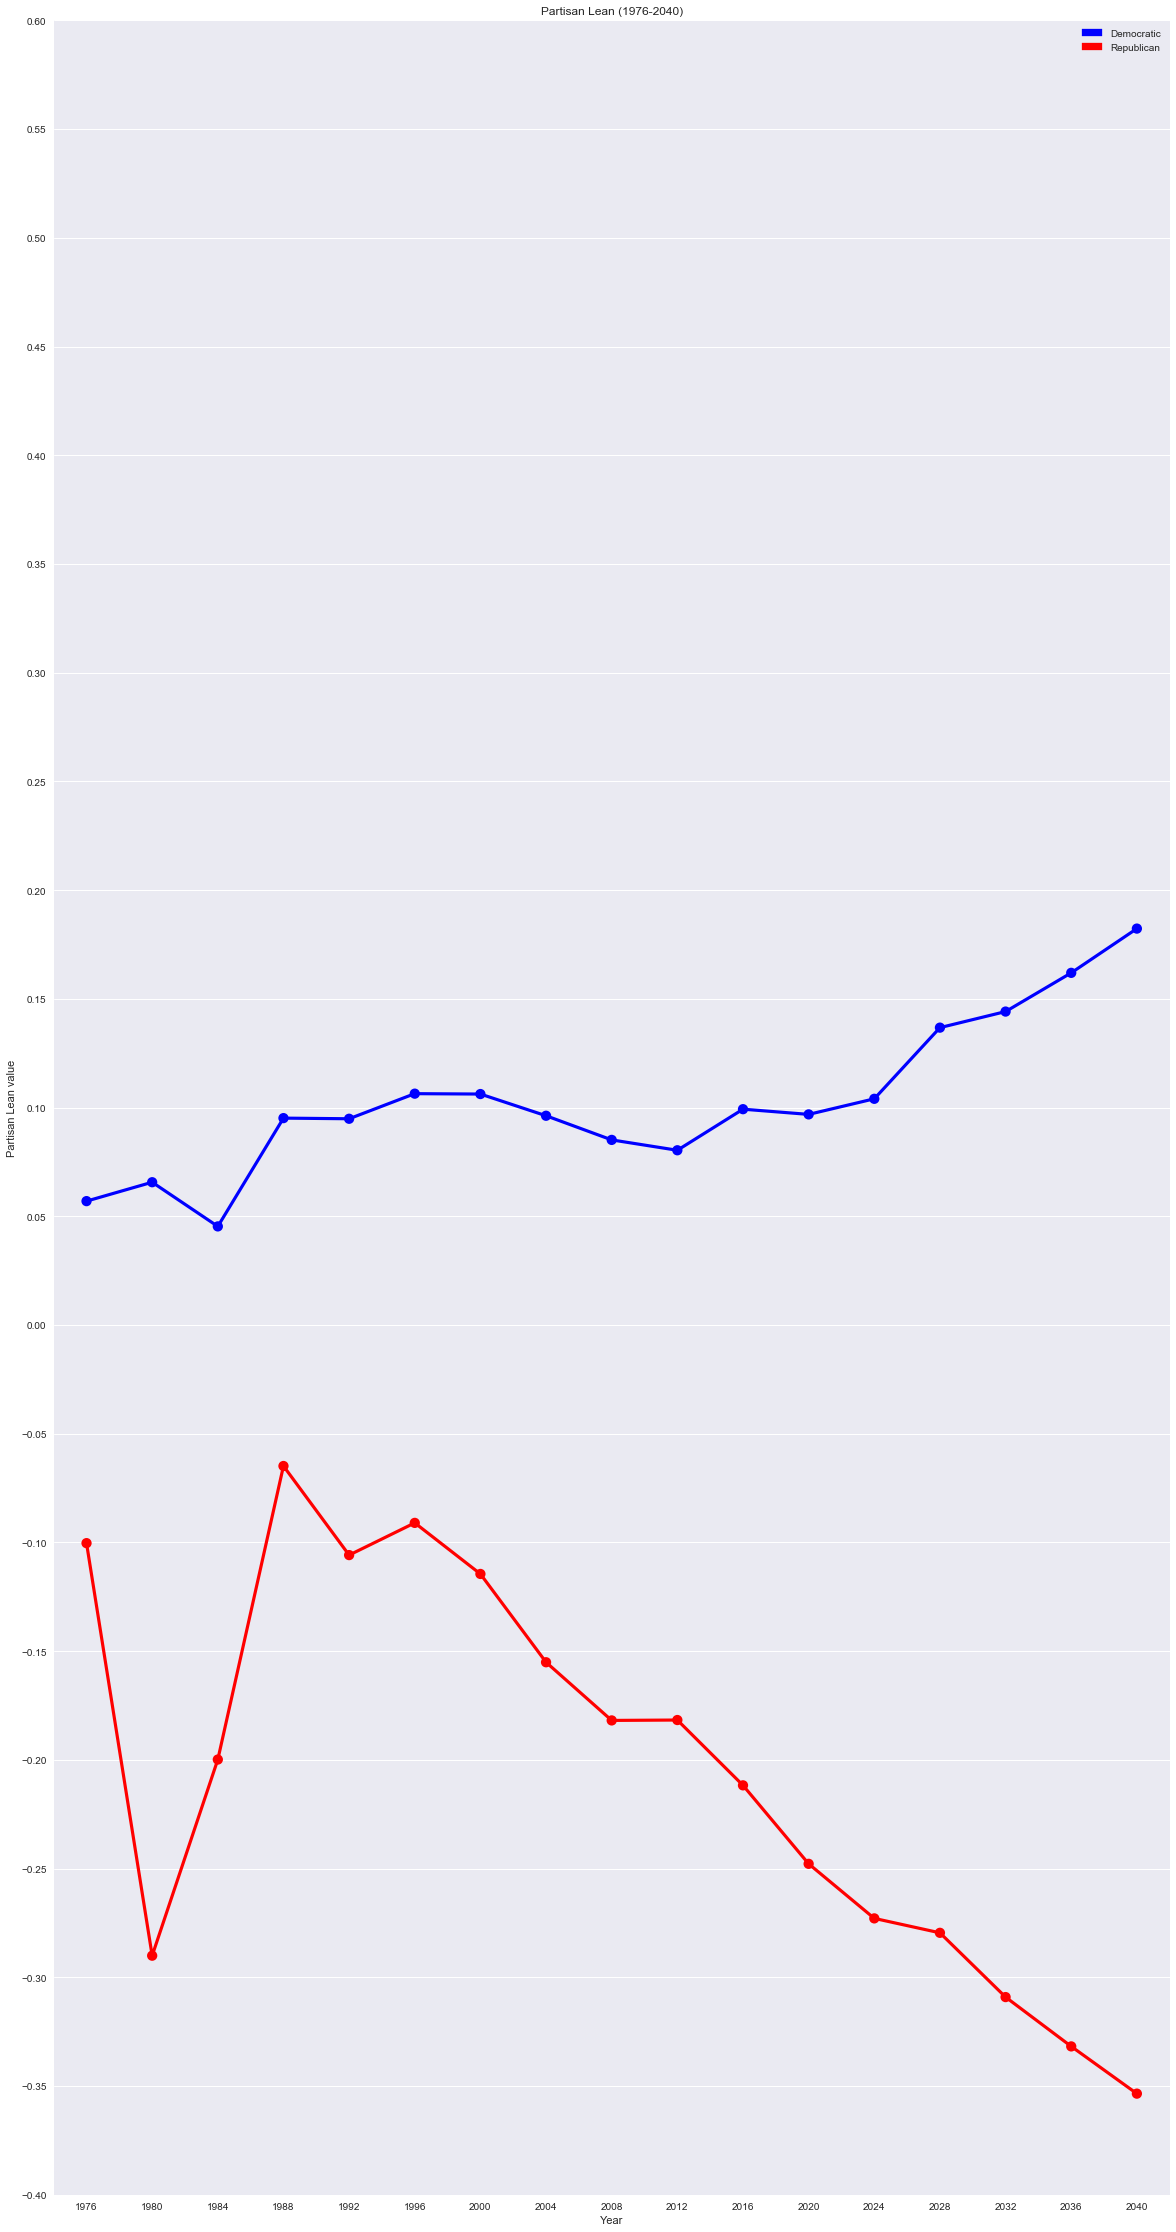

In [63]:
plotLeans(coloradoFrame)

[0.3514953608199739, 0.0013366263483418825, 0.21889388469769352, 0.84813783856652558, 0.45772902988983927, 0.70024770892414101, 0.66669404074066207, 0.66017755362425512, 0.65583193344499124, 0.43517166936392632, 0.61802583752538165, 0.54014634684699603, 0.53567574662572626, 0.45874103536018079, 0.45626538136283323, 0.45391129519120049, 0.34136648307597839]


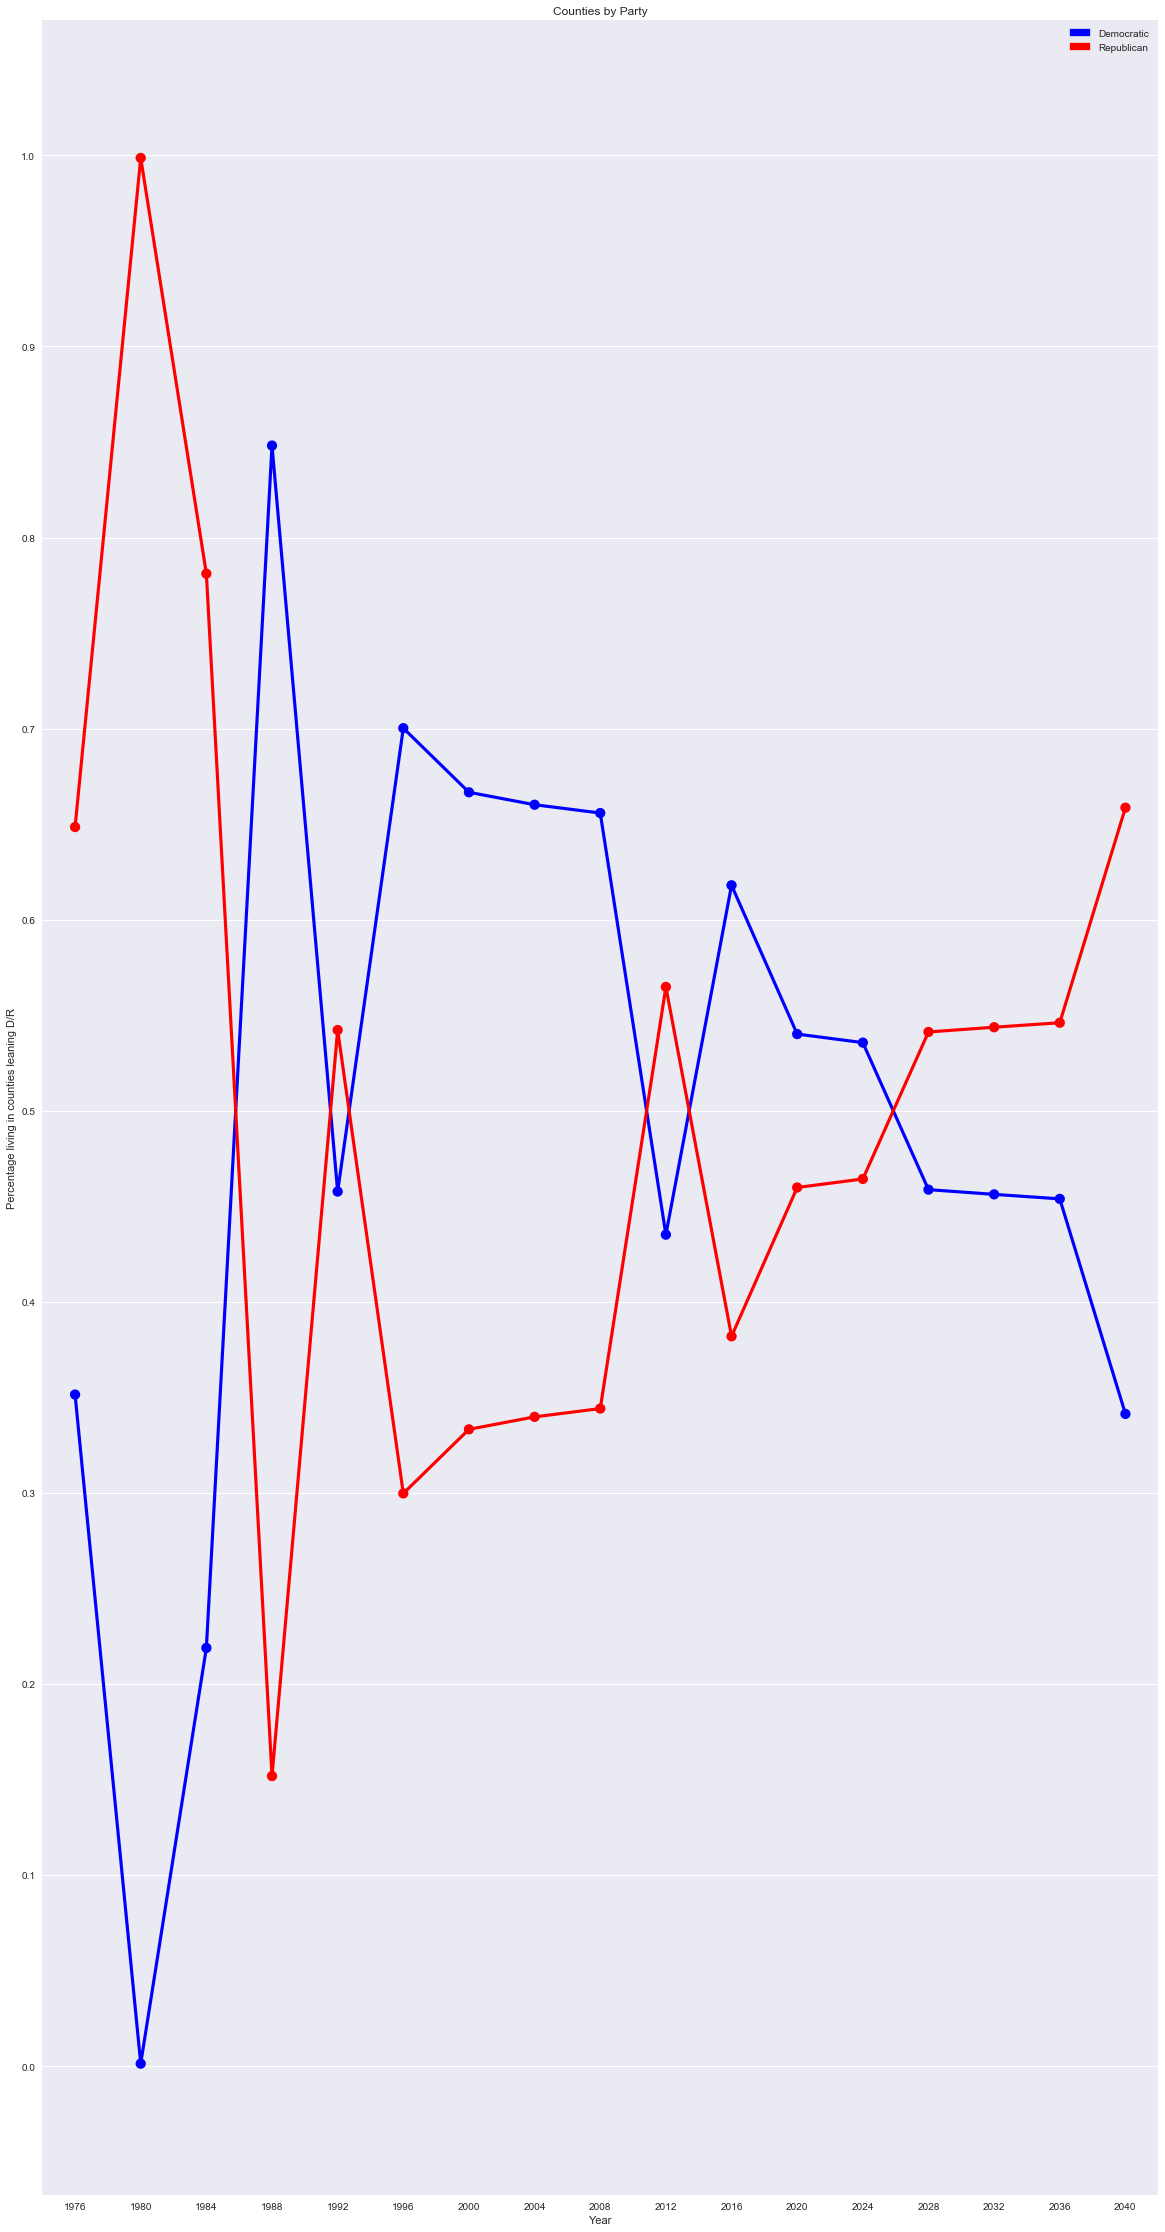

In [64]:
plotPercentages(coloradoFrame)